# `l2hmc`-qcd

- For 4D $SU(3)$ @ $\beta = 6.0$, $\langle U_{P}\rangle \approx 0.6$

In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '2'
!echo $CUDA_VISIBLE_DEVICES

2


In [2]:
# automatically detect and reload local changes to modules
%load_ext autoreload
%autoreload 2

import os
#!unset TF_XLA_FLAGS KMP_SETTINGS KMP_AFFINITY KMP_BLOCKTIME

import warnings
warnings.filterwarnings('ignore')

import os
devices = os.environ.get('CUDA_VISIBLE_DEVICES', None)
print(devices)
!getconf _NPROCESSORS_ONLN

2
256


In [3]:
os.environ['OMP_NUM_THREADS'] = '256'

In [4]:
import os
from __future__ import absolute_import, print_function, annotations, division

os.environ['MASTER_PORT'] = '12345'

from rich.pretty import install
install(expand_all=True)

import hydra
import torch
import tensorflow as tf
tf.config.run_functions_eagerly(True)
import numpy as np

from l2hmc.utils.dist import (
    setup_tensorflow,
    setup_torch
)

_ = setup_torch(
    precision='float64',
    backend='deepspeed',
    seed=1234,
)

#_ = setup_tensorflow(
#    precision='float64',
#)

from hydra.core.global_hydra import GlobalHydra
from l2hmc.utils.rich import print_config

import logging
from rich.logging import RichHandler
np.set_printoptions(threshold=5)
torch.set_printoptions(threshold=5, linewidth=120, precision=5)

--------------------------------------------------------------------------

  Local host:   thetagpu23
  Local device: mlx5_0
--------------------------------------------------------------------------


[2023-01-26 19:31:11,408] [INFO] [comm.py:638:init_distributed] Not using the DeepSpeed or dist launchers, attempting to detect MPI environment...
[2023-01-26 19:31:11,436] [INFO] [comm.py:690:mpi_discovery] Discovered MPI settings of world_rank=0, local_rank=0, world_size=1, master_addr=10.230.2.211, master_port=29500
[2023-01-26 19:31:11,437] [INFO] [comm.py:654:init_distributed] Initializing TorchBackend in DeepSpeed with backend nccl


In [5]:
import logging
from rich.style import Style
from rich.console import Console
from rich.logging import RichHandler
from l2hmc.utils.rich import get_console

console = get_console(width=120)
log = logging.getLogger()
handler = RichHandler(
    rich_tracebacks=True,
    tracebacks_show_locals=True,
    console=console,
    show_path=False,
    log_time_format='[%H:%m:%S]',
    enable_link_path=False,
)

log.handlers = [handler]

log.setLevel('INFO')

tlog = logging.getLogger('torch')
tlog.setLevel('ERROR')

wblog = logging.getLogger('wandb')
wblog.setLevel('CRITICAL')

In [6]:
from rich.pretty import install

install(expand_all=True)

#import horovod.tensorflow as hvdtf
#import horovod.torch as hvdpt

#hvdtf.size()
#hvdpt.size()

from __future__ import absolute_import, print_function, annotations, division
import os
import hydra

from typing import Optional
from pathlib import Path

from omegaconf import OmegaConf
from hydra import (
    initialize,
    initialize_config_module,
    initialize_config_dir,
    compose
)

from l2hmc.common import get_timestamp
from l2hmc.configs import CONF_DIR
from l2hmc.experiment.pytorch.experiment import Experiment as ptExperiment
from hydra.core.global_hydra import GlobalHydra
from l2hmc.utils.rich import print_config
import l2hmc.group.su3.pytorch.group as gpt
from l2hmc.distributions.pytorch.haarSUN import HaarSUN as HaarSUNpt

ptsu3 = gpt.SU3()

import l2hmc
l2hmc.__file__

'/lus/grand/projects/DLHMC/foremans/locations/thetaGPU/projects/l2hmc-qcd/src/l2hmc/__init__.py'

In [7]:
def qcd(
        u: tensor,
        b: int = 0,
        d: int = 0,
        t: int = 0,
        x: int = 0,
        y: int = 0,
        z: int = 0
):
    return u[b, d, t, x, y, z]

## Specify `overrides` for creating Experiment

In [8]:
GlobalHydra.instance().clear()

defaults_su3 = [
    'steps.nera=1',
    'steps.nepoch=10',
    'steps.test=50',
    # ------------------------------
    'conv=none',
    'network.activation_fn=tanh',
    'network.dropout_prob=0.0',
    'learning_rate.lr_init=0.0001',
    # ------------------------------
    'dynamics=su3',
    'dynamics.eps=0.01',
    'dynamics.nchains=2',
    'dynamics.nleapfrog=8',
    'dynamics.verbose=true',
    'dynamics.latvolume=[4, 4, 4, 8]',
    #'dynamics.use_split_xnets=false',
    #'dynamics.merge_directions=false',
    #'dynamics.use_separate_networks=false',
    # ------------------------------
    'net_weights.x.s=0.0',
    'net_weights.x.q=0.0',
    'net_weights.x.t=0.0',
    # ------------------------------
    'loss.charge_weight=0.0',
    'loss.plaq_weight=0.1',
    # ------------------------------
    'annealing_schedule.beta_init=1.0',
    'annealing_schedule.beta_final=1.0',
    #'net_weights.x.t=0.0',
    #'net_weights.x.q=0.0',
    # ------------------------------
]

In [9]:
import gc
import GPUtil

gc.collect()
with torch.no_grad():
    torch.cuda.empty_cache()
torch.clear_autocast_cache()
GPUtil.showUtilization()

| ID | GPU | MEM |
------------------
|  0 |  0% |  2% |
|  1 |  0% |  6% |
|  2 |  0% |  1% |
|  3 |  0% |  0% |
|  4 |  0% |  0% |
|  5 |  0% |  0% |
|  6 |  0% |  0% |
|  7 |  0% |  0% |


# Build `Experiment` objects

We can use the helper function `l2hmc.configs.get_experiment`,
which takes as input:

- `overrides (list[str])`: A list of strings of the form `'key=val'`, specifying which options from our `l2hmc.configs.ExperimentConfig` we wish to override

- `build_networks (Optional[bool])`: Whether or not to build NNs inside `Dynamics` object.

In [10]:
#from l2hmc.configs import get_experiment
#GlobalHydra.instance().clear()
#tfExpSU3 = get_experiment(
#    overrides=[
#        *defaults_su3,
#        'framework=tensorflow',
#        'init_wandb=False',
#        'init_aim=False',
#    ],
#    build_networks=True,
#)

In [11]:
from l2hmc.configs import get_experiment

ptExpSU3 = get_experiment(
    overrides=[
        *defaults_su3,
        'framework=pytorch',
        'backend=deepspeed',
        'init_wandb=False',
        'init_aim=False',
        'learning_rate.clip_norm=10',
    ],
    build_networks=True,
)

[19:01:39] INFO     Looking for checkpoints in:                                                                         
                     /lus/grand/projects/DLHMC/foremans/locations/thetaGPU/projects/l2hmc-qcd/src/l2hmc/checkpoints/SU3/
                    4-4-4-4-8-3-3/nlf-8/xsplit-True/sepnets-True/merge-True/net-16-16-16_dp-0.0_bn-False/pytorch

           WARNING  No checkpoints found to load from

           WARNING  Restoring global step from ckpt! self._gstep: 0

           WARNING  Using `torch.optim.SGD` optimizer

           INFO     Loaded DeepSpeed config from: /lus/grand/projects/DLHMC/foremans/locations/thetaGPU/projects/l2hmc-q
                    cd/src/l2hmc/conf/ds_config.json

           WARNING  Turning of `fp16` in ds_config!

{
  "dump_state": false,
  "prescale_gradients": false,
  "wall_clock_breakdown": true,
  "zero_allow_untested_optimizer": true,
  "flops_profiler": {
    "enabled": true,
    "profile_step": 1,
    "module_depth": -1,
    "top_modules": 1,
    "detailed": true,
    "output_file": null
  },
  "optimizer": {
    "type": "AdamW"
  },
  "fp16": {
    "enabled": false
  },
  "bf16": {
    "enabled": false
  },
  "comms_logger": {
    "enabled": false,
    "verbose": true,
    "prof_all": true,
    "debug": false
  },
  "wandb": {},
  "autotuning": {
    "enabled": false,
    "arg_mappings": {
      "train_micro_batch_size_per_gpu": "--per_device_train_batch_size",
      "gradient_accumulation_steps": "--gradient_accumulation_steps"
    }
  },
  "zero_optimization": {
    "stage": 2,
    "allgather_partitions": true,
    "reduce_scatter": true,
    "allgather_bucket_size": 500000000.0,
    "reduce_bucket_size": 500000000.0,
    "overlap_comm": true,
    "contiguous_gradients": true,
    "offload_param": {
      "device": "nvme",
      "nvme_path": "/raid/scratch"
    },
    "offload_optimizer": {
      "device": "cpu",
      "nvme_path": "/raid/scratch/",
      "pin_memory": false,
      "buffer_count": 4,
      "fast_init": true
    }
  },
  "amp": {
    "enabled": false
  },
  "gradient_accumulation_steps": 1,
  "train_micro_batch_size_per_gpu": 1,
  "train_batch_size": 1
}

[2023-01-26 19:31:39,089] [INFO] [logging.py:68:log_dist] [Rank 0] DeepSpeed info: version=0.8.0+95d9a1b6, git-hash=95d9a1b6, git-branch=master
[2023-01-26 19:31:39,402] [INFO] [logging.py:68:log_dist] [Rank 0] rank=0 | comm op: broadcast | time (ms): 301.28 | msg size: 4.5 MB | algbw (Gbps): 0.13  | busbw (Gbps): 0.13 
[2023-01-26 19:31:39,403] [INFO] [logging.py:68:log_dist] [Rank 0] rank=0 | comm op: broadcast | time (ms): 0.20 | msg size: 128.0 B | algbw (Gbps): 0.01  | busbw (Gbps): 0.01 
[2023-01-26 19:31:39,403] [INFO] [logging.py:68:log_dist] [Rank 0] rank=0 | comm op: broadcast | time (ms): 0.09 | msg size: 4.5 MB | algbw (Gbps): 424.33  | busbw (Gbps): 424.33 
[2023-01-26 19:31:39,404] [INFO] [logging.py:68:log_dist] [Rank 0] rank=0 | comm op: broadcast | time (ms): 0.18 | msg size: 128.0 B | algbw (Gbps): 0.01  | busbw (Gbps): 0.01 
[2023-01-26 19:31:39,405] [INFO] [logging.py:68:log_dist] [Rank 0] rank=0 | comm op: broadcast | time (ms): 0.08 | msg size: 2.0 KB | algbw (Gbp

## Training

<Figure size 1125x375 with 2 Axes>

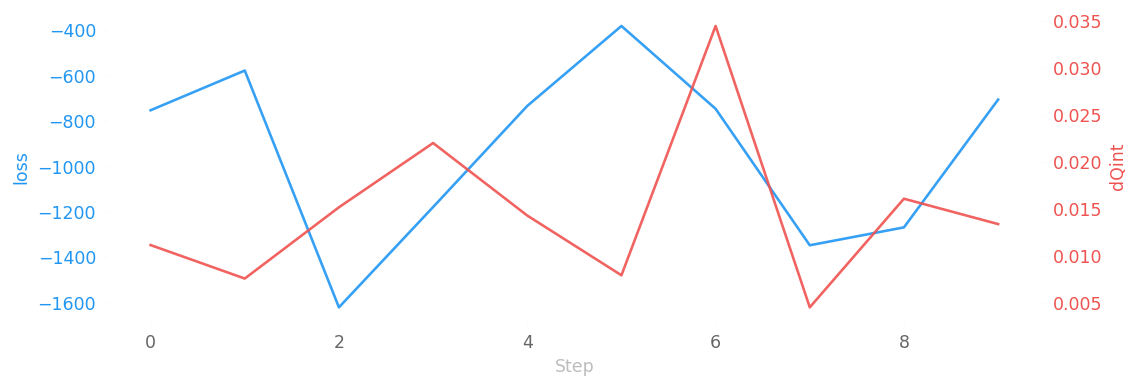

[19:01:52] INFO     [TRAINING] x.dtype: torch.complex128

           INFO     [TRAINING] self._dtype: torch.float64

────────────────────────────────── ERA: 0 / 0, BETA: 6.000 ──────────────────────────────────

Training:   0%|          | 0/10 [00:00<?, ?it/s]

[2023-01-26 19:32:49,345] [INFO] [logging.py:68:log_dist] [Rank 0] rank=0 | comm op: reduce | time (ms): 0.04 | msg size: 88.75 MB | algbw (Gbps): 20771.44  | busbw (Gbps): 20771.44 
[2023-01-26 19:32:49,397] [INFO] [logging.py:68:log_dist] [Rank 0] rank=0 | comm op: all_reduce | time (ms): 0.10 | msg size: 1.0 B | algbw (Gbps): 0.00  | busbw (Gbps): 0.00 
[2023-01-26 19:32:49,397] [INFO] [stage_1_and_2.py:1767:step] [deepspeed] OVERFLOW! Rank 0 Skipping step. Attempted loss scale: 4294967296, reducing to 2147483648.0
[2023-01-26 19:32:49,398] [INFO] [logging.py:68:log_dist] [Rank 0] rank=0 time (ms) | forward_microstep: 656.36 | backward_microstep: 1212.34 | backward_inner_microstep: 1150.94 | backward_allreduce_microstep: 61.28 | step_microstep: 1.85
[2023-01-26 19:32:49,399] [INFO] [logging.py:68:log_dist] [Rank 0] rank=0 time (ms) | forward: 0.00 | backward: 0.00 | backward_inner: 0.00 | backward_allreduce: 0.00 | step: 0.00


<Figure size 1125x375 with 2 Axes>

[19:01:57] INFO     era=0   epoch=0   tstep=1   dt=1.8854 beta=6.0000 loss=-752.1487 dQsin=0.0004 dQint=0.0112          
                    energy=-10825.4438 logprob=-119248.8826 logdet=108423.4388 sldf=147455.5398 sldb=0.4584             
                    sld=108423.4388 xeps=0.0100 veps=0.0100 acc=1.0000 sumlogdet=147455.9983 acc_mask=1.0000            
                    plaqs=0.5870 sinQ=0.0009 intQ=0.0276 lr=0.0001

[2023-01-26 19:32:59,706] [INFO] [logging.py:68:log_dist] [Rank 0] rank=0 | comm op: reduce | time (ms): 0.03 | msg size: 88.75 MB | algbw (Gbps): 22763.22  | busbw (Gbps): 22763.22 
[2023-01-26 19:32:59,758] [INFO] [logging.py:68:log_dist] [Rank 0] rank=0 | comm op: all_reduce | time (ms): 0.11 | msg size: 1.0 B | algbw (Gbps): 0.00  | busbw (Gbps): 0.00 
[2023-01-26 19:32:59,758] [INFO] [stage_1_and_2.py:1767:step] [deepspeed] OVERFLOW! Rank 0 Skipping step. Attempted loss scale: 2147483648.0, reducing to 1073741824.0

-------------------------- DeepSpeed Flops Profiler --------------------------
Profile Summary at step 2:
Notations:
data parallel size (dp_size), model parallel size(mp_size),
number of parameters (params), number of multiply-accumulate operations(MACs),
number of floating-point operations (flops), floating-point operations per second (FLOPS),
fwd latency (forward propagation latency), bwd latency (backward propagation latency),
step (weights update latency), iter lat

<Figure size 1125x375 with 2 Axes>

[19:01:08] INFO     era=0   epoch=1   tstep=2   dt=1.9945 beta=6.0000 loss=-577.3142 dQsin=0.0003 dQint=0.0076          
                    energy=-10591.0145 logprob=-119014.4217 logdet=108423.4072 sldf=147455.4573 sldb=0.5138             
                    sld=108423.4072 xeps=0.0100 veps=0.0100 acc=1.0000 sumlogdet=147455.9711 acc_mask=1.0000            
                    plaqs=0.5860 sinQ=0.0011 intQ=0.0334 lr=0.0001

[2023-01-26 19:33:10,264] [INFO] [logging.py:68:log_dist] [Rank 0] rank=0 | comm op: reduce | time (ms): 0.04 | msg size: 88.75 MB | algbw (Gbps): 20496.92  | busbw (Gbps): 20496.92 
[2023-01-26 19:33:10,315] [INFO] [logging.py:68:log_dist] [Rank 0] rank=0 | comm op: all_reduce | time (ms): 0.10 | msg size: 1.0 B | algbw (Gbps): 0.00  | busbw (Gbps): 0.00 
[2023-01-26 19:33:10,316] [INFO] [stage_1_and_2.py:1767:step] [deepspeed] OVERFLOW! Rank 0 Skipping step. Attempted loss scale: 1073741824.0, reducing to 536870912.0
[2023-01-26 19:33:10,317] [INFO] [logging.py:68:log_dist] [Rank 0] rank=0 time (ms) | forward_microstep: 748.60 | backward_microstep: 1099.00 | backward_inner_microstep: 1037.36 | backward_allreduce_microstep: 61.51 | step_microstep: 1.79
[2023-01-26 19:33:10,318] [INFO] [logging.py:68:log_dist] [Rank 0] rank=0 time (ms) | forward: 0.00 | backward: 0.00 | backward_inner: 0.00 | backward_allreduce: 0.00 | step: 0.00


<Figure size 1125x375 with 2 Axes>

[19:01:19] INFO     era=0   epoch=2   tstep=3   dt=1.8797 beta=6.0000 loss=-1619.8943 dQsin=0.0005 dQint=0.0152         
                    energy=-10883.3850 logprob=-119306.8426 logdet=108423.4576 sldf=147455.4410 sldb=0.7023             
                    sld=108423.4576 xeps=0.0100 veps=0.0100 acc=1.0000 sumlogdet=147456.1433 acc_mask=1.0000            
                    plaqs=0.5877 sinQ=0.0009 intQ=0.0258 lr=0.0001

[2023-01-26 19:33:20,806] [INFO] [logging.py:68:log_dist] [Rank 0] rank=0 | comm op: reduce | time (ms): 0.03 | msg size: 88.75 MB | algbw (Gbps): 22009.47  | busbw (Gbps): 22009.47 
[2023-01-26 19:33:20,858] [INFO] [logging.py:68:log_dist] [Rank 0] rank=0 | comm op: all_reduce | time (ms): 0.11 | msg size: 1.0 B | algbw (Gbps): 0.00  | busbw (Gbps): 0.00 
[2023-01-26 19:33:20,858] [INFO] [stage_1_and_2.py:1767:step] [deepspeed] OVERFLOW! Rank 0 Skipping step. Attempted loss scale: 536870912.0, reducing to 268435456.0
[2023-01-26 19:33:20,859] [INFO] [logging.py:68:log_dist] [Rank 0] rank=0 time (ms) | forward_microstep: 739.21 | backward_microstep: 1090.40 | backward_inner_microstep: 1027.19 | backward_allreduce_microstep: 62.22 | step_microstep: 1.68
[2023-01-26 19:33:20,860] [INFO] [logging.py:68:log_dist] [Rank 0] rank=0 time (ms) | forward: 0.00 | backward: 0.00 | backward_inner: 0.00 | backward_allreduce: 0.00 | step: 0.00


<Figure size 1125x375 with 2 Axes>

[19:01:30] INFO     era=0   epoch=3   tstep=4   dt=1.8637 beta=6.0000 loss=-1178.3362 dQsin=0.0008 dQint=0.0220         
                    energy=-10810.4668 logprob=-119233.7791 logdet=108423.3123 sldf=147455.2773 sldb=0.7025             
                    sld=108423.3123 xeps=0.0100 veps=0.0100 acc=1.0000 sumlogdet=147455.9798 acc_mask=1.0000            
                    plaqs=0.5919 sinQ=0.0004 intQ=0.0106 lr=0.0001

[2023-01-26 19:33:31,932] [INFO] [logging.py:68:log_dist] [Rank 0] rank=0 | comm op: reduce | time (ms): 0.03 | msg size: 88.75 MB | algbw (Gbps): 22875.13  | busbw (Gbps): 22875.13 
[2023-01-26 19:33:31,984] [INFO] [logging.py:68:log_dist] [Rank 0] rank=0 | comm op: all_reduce | time (ms): 0.11 | msg size: 1.0 B | algbw (Gbps): 0.00  | busbw (Gbps): 0.00 
[2023-01-26 19:33:31,984] [INFO] [stage_1_and_2.py:1767:step] [deepspeed] OVERFLOW! Rank 0 Skipping step. Attempted loss scale: 268435456.0, reducing to 134217728.0
[2023-01-26 19:33:31,985] [INFO] [logging.py:68:log_dist] [Rank 0] rank=0 time (ms) | forward_microstep: 734.10 | backward_microstep: 1050.06 | backward_inner_microstep: 988.84 | backward_allreduce_microstep: 61.11 | step_microstep: 1.71
[2023-01-26 19:33:31,986] [INFO] [logging.py:68:log_dist] [Rank 0] rank=0 time (ms) | forward: 0.00 | backward: 0.00 | backward_inner: 0.00 | backward_allreduce: 0.00 | step: 0.00


<Figure size 1125x375 with 2 Axes>

[19:01:40] INFO     era=0   epoch=4   tstep=5   dt=1.8209 beta=6.0000 loss=-733.0897 dQsin=0.0005 dQint=0.0143          
                    energy=-10935.3829 logprob=-119358.7104 logdet=108423.3275 sldf=147455.2815 sldb=0.6102             
                    sld=108423.3275 xeps=0.0100 veps=0.0100 acc=1.0000 sumlogdet=147455.8917 acc_mask=1.0000            
                    plaqs=0.5925 sinQ=0.0011 intQ=0.0327 lr=0.0001

[2023-01-26 19:33:42,691] [INFO] [logging.py:68:log_dist] [Rank 0] rank=0 | comm op: reduce | time (ms): 0.03 | msg size: 88.75 MB | algbw (Gbps): 22219.68  | busbw (Gbps): 22219.68 
[2023-01-26 19:33:42,743] [INFO] [logging.py:68:log_dist] [Rank 0] rank=0 | comm op: all_reduce | time (ms): 0.11 | msg size: 1.0 B | algbw (Gbps): 0.00  | busbw (Gbps): 0.00 
[2023-01-26 19:33:42,744] [INFO] [stage_1_and_2.py:1767:step] [deepspeed] OVERFLOW! Rank 0 Skipping step. Attempted loss scale: 134217728.0, reducing to 67108864.0
[2023-01-26 19:33:42,745] [INFO] [logging.py:68:log_dist] [Rank 0] rank=0 time (ms) | forward_microstep: 736.77 | backward_microstep: 1081.42 | backward_inner_microstep: 1020.04 | backward_allreduce_microstep: 61.26 | step_microstep: 1.74
[2023-01-26 19:33:42,745] [INFO] [logging.py:68:log_dist] [Rank 0] rank=0 time (ms) | forward: 0.00 | backward: 0.00 | backward_inner: 0.00 | backward_allreduce: 0.00 | step: 0.00


<Figure size 1125x375 with 2 Axes>

[19:01:51] INFO     era=0   epoch=5   tstep=6   dt=1.8558 beta=6.0000 loss=-381.1109 dQsin=0.0003 dQint=0.0080          
                    energy=-10863.8966 logprob=-119287.3216 logdet=108423.4250 sldf=147455.4537 sldb=0.4997             
                    sld=108423.4250 xeps=0.0100 veps=0.0100 acc=1.0000 sumlogdet=147455.9534 acc_mask=1.0000            
                    plaqs=0.5912 sinQ=0.0012 intQ=0.0342 lr=0.0001

[2023-01-26 19:33:53,652] [INFO] [logging.py:68:log_dist] [Rank 0] rank=0 | comm op: reduce | time (ms): 0.03 | msg size: 88.75 MB | algbw (Gbps): 21560.71  | busbw (Gbps): 21560.71 
[2023-01-26 19:33:53,703] [INFO] [logging.py:68:log_dist] [Rank 0] rank=0 | comm op: all_reduce | time (ms): 0.11 | msg size: 1.0 B | algbw (Gbps): 0.00  | busbw (Gbps): 0.00 
[2023-01-26 19:33:53,704] [INFO] [stage_1_and_2.py:1767:step] [deepspeed] OVERFLOW! Rank 0 Skipping step. Attempted loss scale: 67108864.0, reducing to 33554432.0
[2023-01-26 19:33:53,705] [INFO] [logging.py:68:log_dist] [Rank 0] rank=0 time (ms) | forward_microstep: 746.87 | backward_microstep: 1251.73 | backward_inner_microstep: 1190.47 | backward_allreduce_microstep: 61.14 | step_microstep: 1.72
[2023-01-26 19:33:53,705] [INFO] [logging.py:68:log_dist] [Rank 0] rank=0 time (ms) | forward: 0.00 | backward: 0.00 | backward_inner: 0.00 | backward_allreduce: 0.00 | step: 0.00


<Figure size 1125x375 with 2 Axes>

[19:01:02] INFO     era=0   epoch=6   tstep=7   dt=2.0356 beta=6.0000 loss=-745.7219 dQsin=0.0012 dQint=0.0345          
                    energy=-10977.1791 logprob=-119400.5914 logdet=108423.4123 sldf=147455.3655 sldb=0.6921             
                    sld=108423.4123 xeps=0.0100 veps=0.0100 acc=1.0000 sumlogdet=147456.0576 acc_mask=1.0000            
                    plaqs=0.5913 sinQ=0.0009 intQ=0.0263 lr=0.0001

[2023-01-26 19:34:04,184] [INFO] [logging.py:68:log_dist] [Rank 0] rank=0 | comm op: reduce | time (ms): 0.03 | msg size: 88.75 MB | algbw (Gbps): 21926.49  | busbw (Gbps): 21926.49 
[2023-01-26 19:34:04,236] [INFO] [logging.py:68:log_dist] [Rank 0] rank=0 | comm op: all_reduce | time (ms): 0.13 | msg size: 1.0 B | algbw (Gbps): 0.00  | busbw (Gbps): 0.00 
[2023-01-26 19:34:04,237] [INFO] [stage_1_and_2.py:1767:step] [deepspeed] OVERFLOW! Rank 0 Skipping step. Attempted loss scale: 33554432.0, reducing to 16777216.0
[2023-01-26 19:34:04,238] [INFO] [logging.py:68:log_dist] [Rank 0] rank=0 time (ms) | forward_microstep: 742.68 | backward_microstep: 1017.14 | backward_inner_microstep: 953.03 | backward_allreduce_microstep: 63.10 | step_microstep: 1.81
[2023-01-26 19:34:04,239] [INFO] [logging.py:68:log_dist] [Rank 0] rank=0 time (ms) | forward: 0.00 | backward: 0.00 | backward_inner: 0.00 | backward_allreduce: 0.00 | step: 0.00


<Figure size 1125x375 with 2 Axes>

[19:01:13] INFO     era=0   epoch=7   tstep=8   dt=1.7967 beta=6.0000 loss=-1346.5832 dQsin=0.0002 dQint=0.0045         
                    energy=-10915.6159 logprob=-119338.9450 logdet=108423.3292 sldf=147455.2888 sldb=0.6568             
                    sld=108423.3292 xeps=0.0100 veps=0.0100 acc=1.0000 sumlogdet=147455.9456 acc_mask=1.0000            
                    plaqs=0.5921 sinQ=0.0015 intQ=0.0430 lr=0.0001

[2023-01-26 19:34:15,332] [INFO] [logging.py:68:log_dist] [Rank 0] rank=0 | comm op: reduce | time (ms): 0.03 | msg size: 88.75 MB | algbw (Gbps): 21864.67  | busbw (Gbps): 21864.67 
[2023-01-26 19:34:15,384] [INFO] [logging.py:68:log_dist] [Rank 0] rank=0 | comm op: all_reduce | time (ms): 0.11 | msg size: 1.0 B | algbw (Gbps): 0.00  | busbw (Gbps): 0.00 
[2023-01-26 19:34:15,385] [INFO] [stage_1_and_2.py:1767:step] [deepspeed] OVERFLOW! Rank 0 Skipping step. Attempted loss scale: 16777216.0, reducing to 8388608.0
[2023-01-26 19:34:15,386] [INFO] [logging.py:68:log_dist] [Rank 0] rank=0 time (ms) | forward_microstep: 744.75 | backward_microstep: 1006.06 | backward_inner_microstep: 943.84 | backward_allreduce_microstep: 62.07 | step_microstep: 1.86
[2023-01-26 19:34:15,387] [INFO] [logging.py:68:log_dist] [Rank 0] rank=0 time (ms) | forward: 0.00 | backward: 0.00 | backward_inner: 0.00 | backward_allreduce: 0.00 | step: 0.00


<Figure size 1125x375 with 2 Axes>

[19:01:24] INFO     era=0   epoch=8   tstep=9   dt=1.7860 beta=6.0000 loss=-1267.8662 dQsin=0.0006 dQint=0.0161         
                    energy=-10934.4123 logprob=-119357.7547 logdet=108423.3424 sldf=147455.4124 sldb=0.5151             
                    sld=108423.3424 xeps=0.0100 veps=0.0100 acc=1.0000 sumlogdet=147455.9275 acc_mask=1.0000            
                    plaqs=0.5906 sinQ=0.0014 intQ=0.0406 lr=0.0001

[2023-01-26 19:34:26,241] [INFO] [logging.py:68:log_dist] [Rank 0] rank=0 | comm op: reduce | time (ms): 0.03 | msg size: 88.75 MB | algbw (Gbps): 21520.82  | busbw (Gbps): 21520.82 
[2023-01-26 19:34:26,294] [INFO] [logging.py:68:log_dist] [Rank 0] rank=0 | comm op: all_reduce | time (ms): 0.14 | msg size: 1.0 B | algbw (Gbps): 0.00  | busbw (Gbps): 0.00 
[2023-01-26 19:34:26,294] [INFO] [stage_1_and_2.py:1767:step] [deepspeed] OVERFLOW! Rank 0 Skipping step. Attempted loss scale: 8388608.0, reducing to 4194304.0
[2023-01-26 19:34:26,295] [INFO] [logging.py:68:log_dist] [Rank 0] step=10, skipped=10, lr=[0.001], mom=[(0.9, 0.999)]
[2023-01-26 19:34:26,296] [INFO] [timer.py:196:stop] epoch=0/micro_step=10/global_step=10, RunningAvgSamplesPerSec=0.5483661134239045, CurrSamplesPerSec=0.5676934893903557, MemAllocated=0.56GB, MaxMemAllocated=8.94GB
[2023-01-26 19:34:26,297] [INFO] [logging.py:68:log_dist] [Rank 0] rank=0 time (ms) | forward_microstep: 776.36 | backward_microstep: 978.78 | b

<Figure size 1125x375 with 2 Axes>

[19:01:35] INFO     era=0   epoch=9   tstep=10  dt=1.7947 beta=6.0000 loss=-705.3554 dQsin=0.0005 dQint=0.0134          
                    energy=-10933.0368 logprob=-119356.4889 logdet=108423.4521 sldf=147455.6153 sldb=0.4651             
                    sld=108423.4521 xeps=0.0100 veps=0.0100 acc=1.0000 sumlogdet=147456.0804 acc_mask=1.0000            
                    plaqs=0.5903 sinQ=0.0008 intQ=0.0245 lr=0.0001

[19:01:37] INFO     Saving checkpoint to: /lus/grand/projects/DLHMC/foremans/locations/thetaGPU/projects/l2hmc-qcd/src/l
                    2hmc/checkpoints/SU3/4-4-4-4-8-3-3/nlf-8/xsplit-True/sepnets-True/merge-True/net-16-16-16_dp-0.0_bn-
                    False/pytorch/ckpt-0-0-10-2023-01-26-193435.tar

           INFO     Saving modelfile to: /lus/grand/projects/DLHMC/foremans/locations/thetaGPU/projects/l2hmc-qcd/src/l2
                    hmc/checkpoints/SU3/4-4-4-4-8-3-3/nlf-8/xsplit-True/sepnets-True/merge-True/net-16-16-16_dp-0.0_bn-F
                    alse/pytorch/model-0-0-10-2023-01-26-193435.pth

           INFO     Saving took: 2.16225s

           INFO     Era 0 took: 165.136s

[19:01:44] WARNING  Saving figure to: /lus/grand/projects/DLHMC/foremans/locations/thetaGPU/projects/l2hmc-qcd/src/l2hmc
                    /notebooks/outputs/2023-01-26-193137/pytorch/train/plots/ridgeplots/svgs/energy_ridgeplot.svg

[19:01:45] INFO     Ridgeplot for energy took 2.767s

[19:01:46] WARNING  Saving figure to: /lus/grand/projects/DLHMC/foremans/locations/thetaGPU/projects/l2hmc-qcd/src/l2hmc
                    /notebooks/outputs/2023-01-26-193137/pytorch/train/plots/ridgeplots/svgs/logprob_ridgeplot.svg

[19:01:47] INFO     Ridgeplot for logprob took 1.892s

[19:01:48] WARNING  Saving figure to: /lus/grand/projects/DLHMC/foremans/locations/thetaGPU/projects/l2hmc-qcd/src/l2hmc
                    /notebooks/outputs/2023-01-26-193137/pytorch/train/plots/ridgeplots/svgs/logdet_ridgeplot.svg

[19:01:49] INFO     Ridgeplot for logdet took 1.986s

[19:01:50] WARNING  Saving figure to: /lus/grand/projects/DLHMC/foremans/locations/thetaGPU/projects/l2hmc-qcd/src/l2hmc
                    /notebooks/outputs/2023-01-26-193137/pytorch/train/plots/ridgeplots/svgs/sldf_ridgeplot.svg

[19:01:51] INFO     Ridgeplot for sldf took 2.055s

[19:01:53] WARNING  Saving figure to: /lus/grand/projects/DLHMC/foremans/locations/thetaGPU/projects/l2hmc-qcd/src/l2hmc
                    /notebooks/outputs/2023-01-26-193137/pytorch/train/plots/ridgeplots/svgs/sldb_ridgeplot.svg

           INFO     Ridgeplot for sldb took 2.302s

[19:01:55] WARNING  Saving figure to: /lus/grand/projects/DLHMC/foremans/locations/thetaGPU/projects/l2hmc-qcd/src/l2hmc
                    /notebooks/outputs/2023-01-26-193137/pytorch/train/plots/ridgeplots/svgs/sld_ridgeplot.svg

           INFO     Ridgeplot for sld took 1.999s

[19:01:05] INFO     Saving dataset to: /lus/grand/projects/DLHMC/foremans/locations/thetaGPU/projects/l2hmc-qcd/src/l2hm
                    c/notebooks/outputs/2023-01-26-193137/pytorch/train/data/train_data.h5

           INFO     Done saving and analyzing data.

           INFO     Creating summaries for WandB, Aim

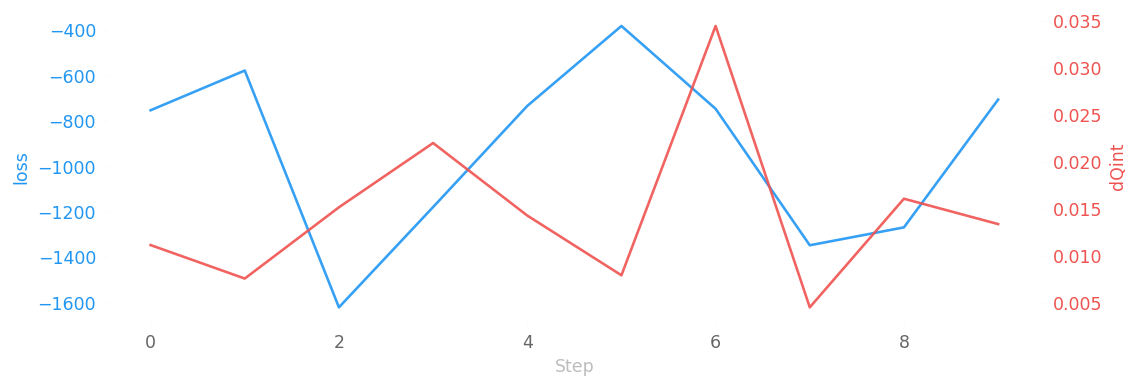

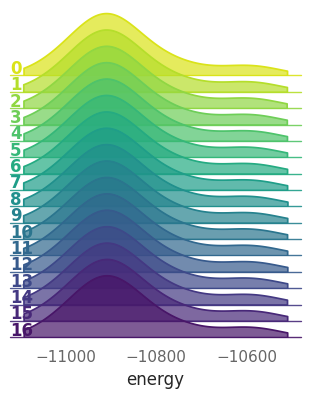

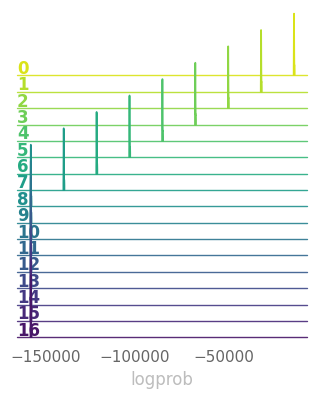

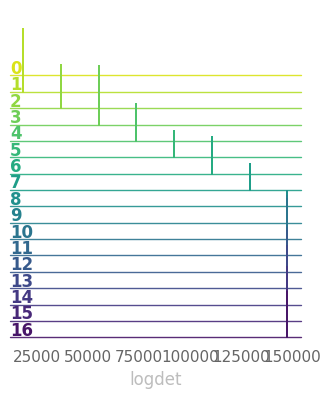

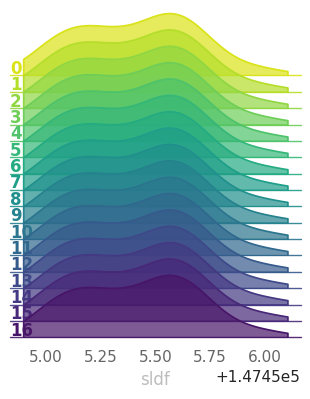

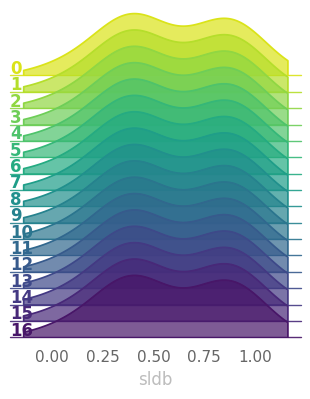

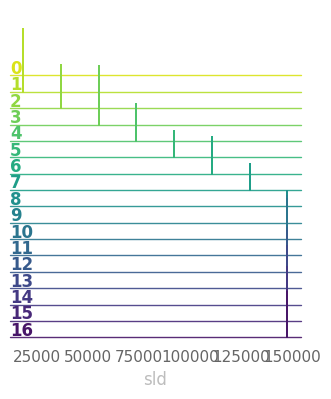

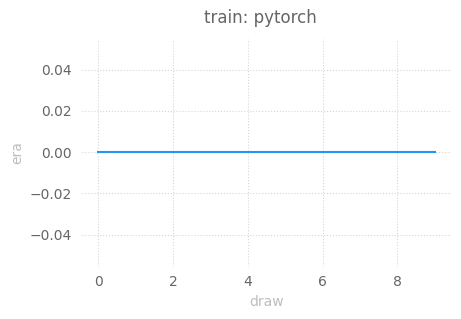

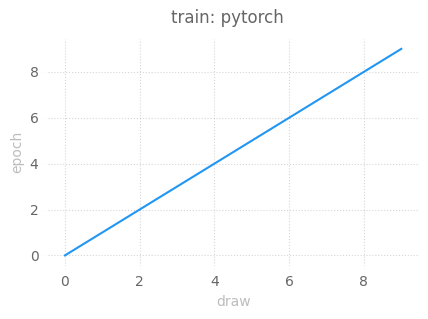

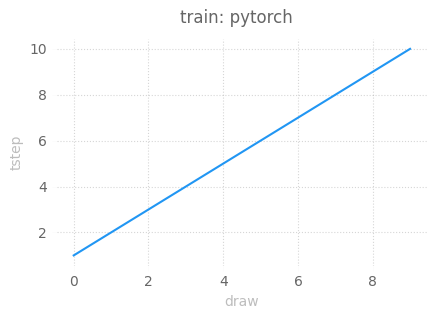

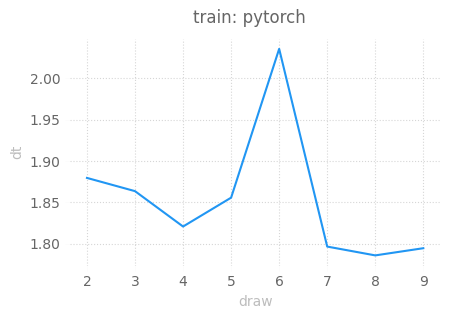

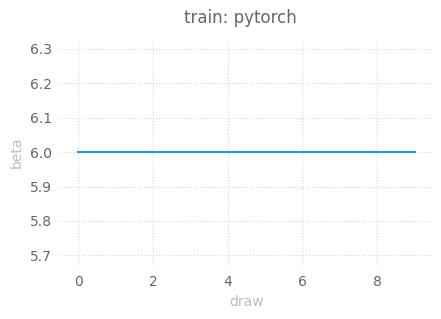

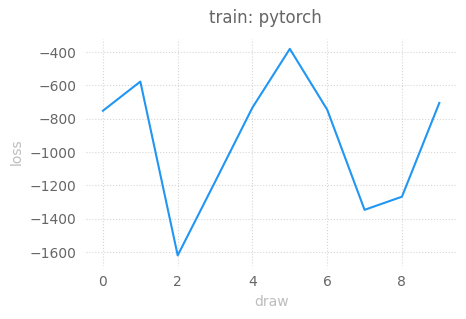

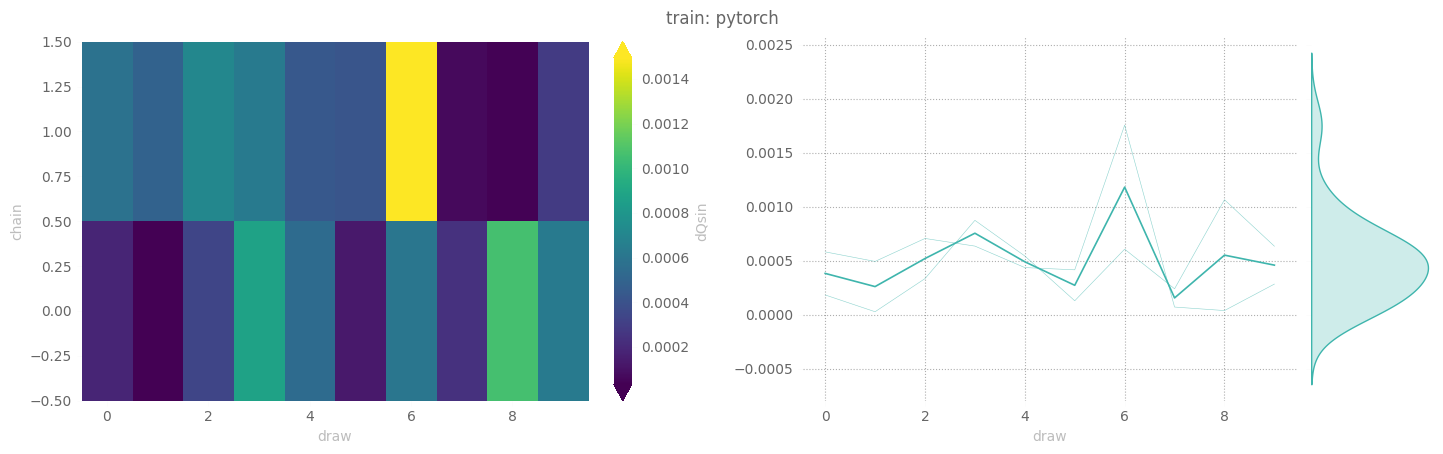

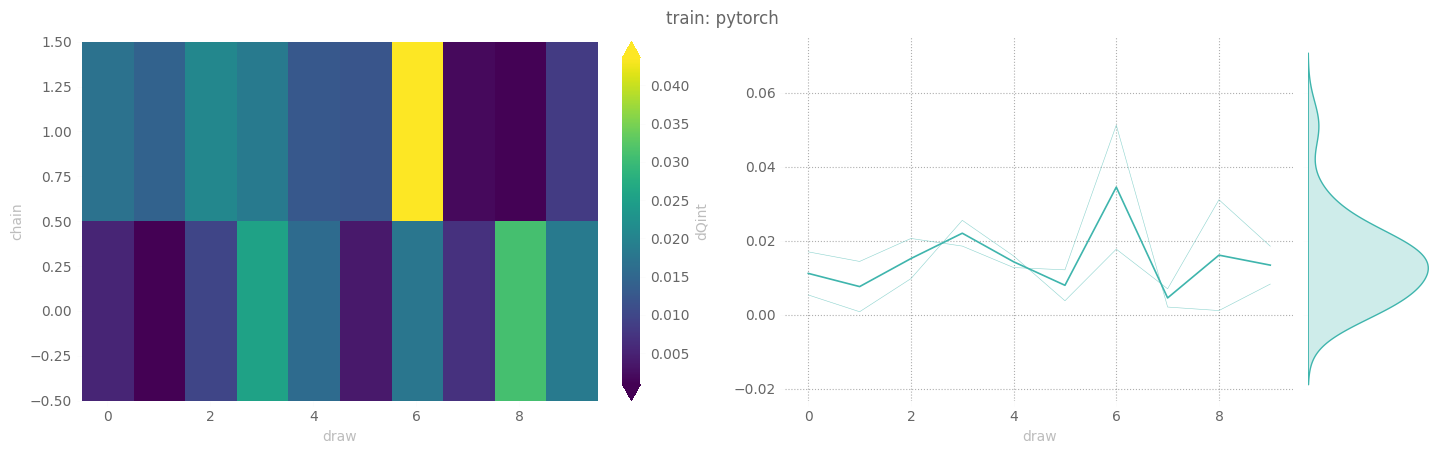

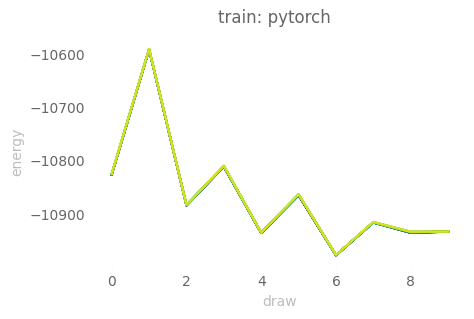

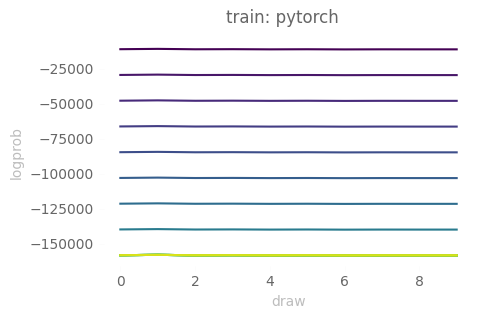

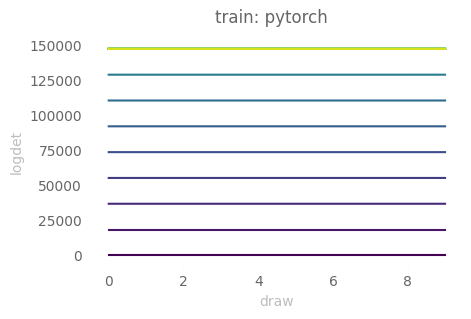

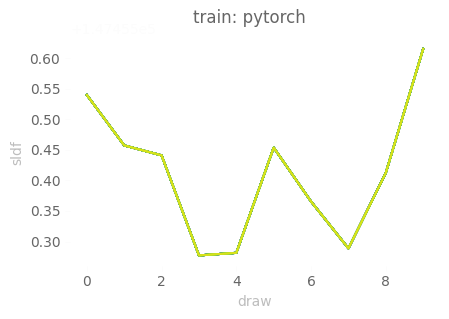

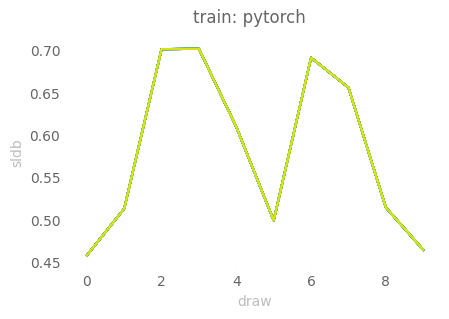

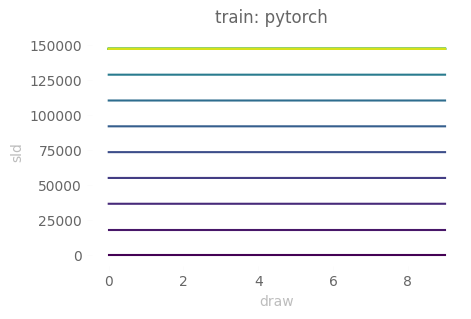

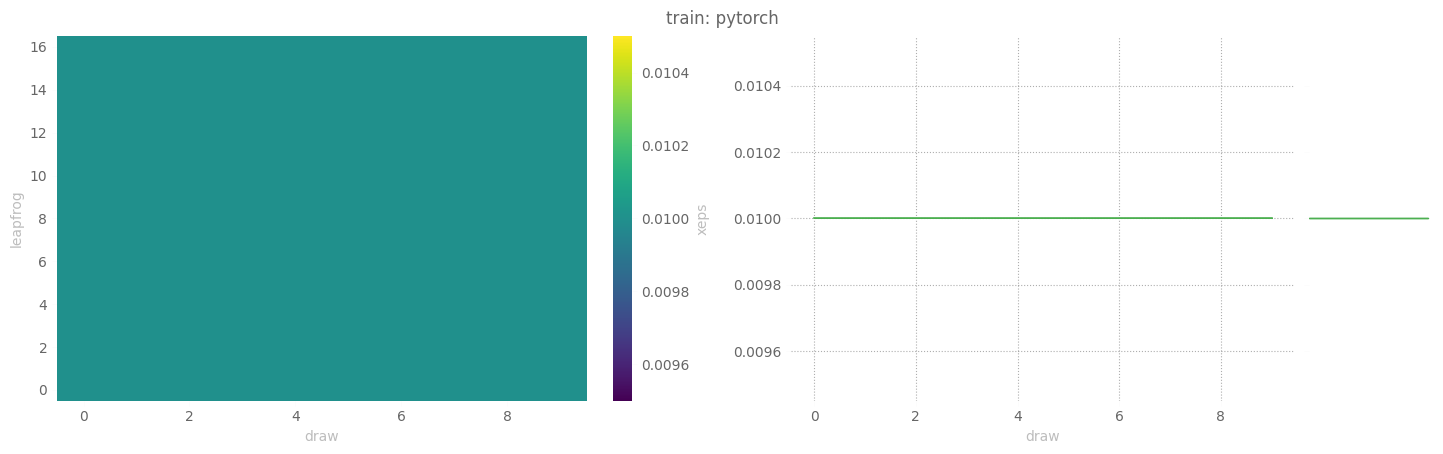

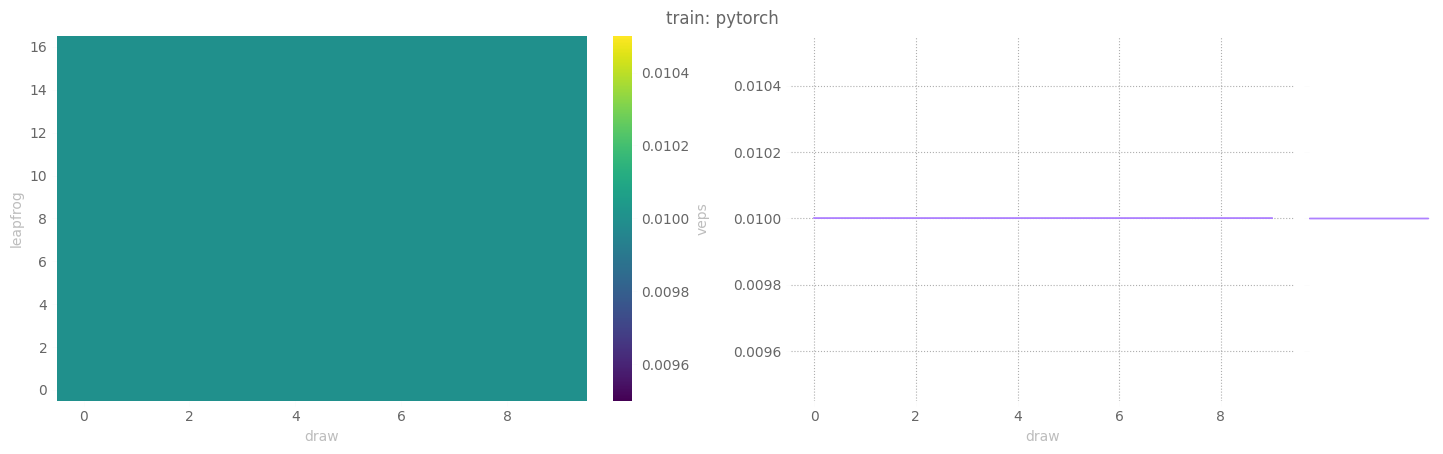

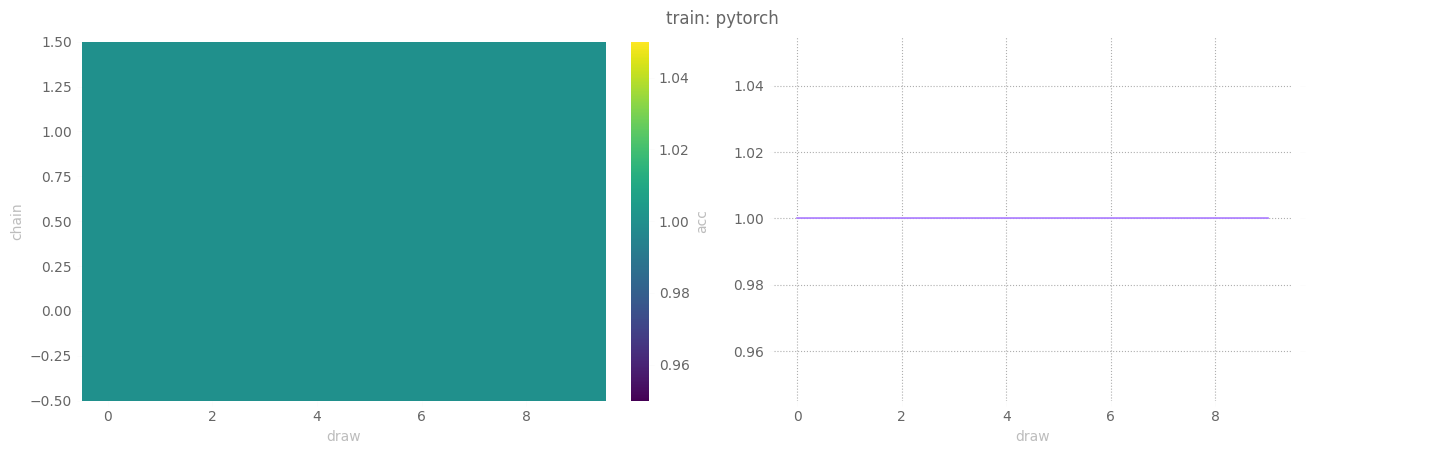

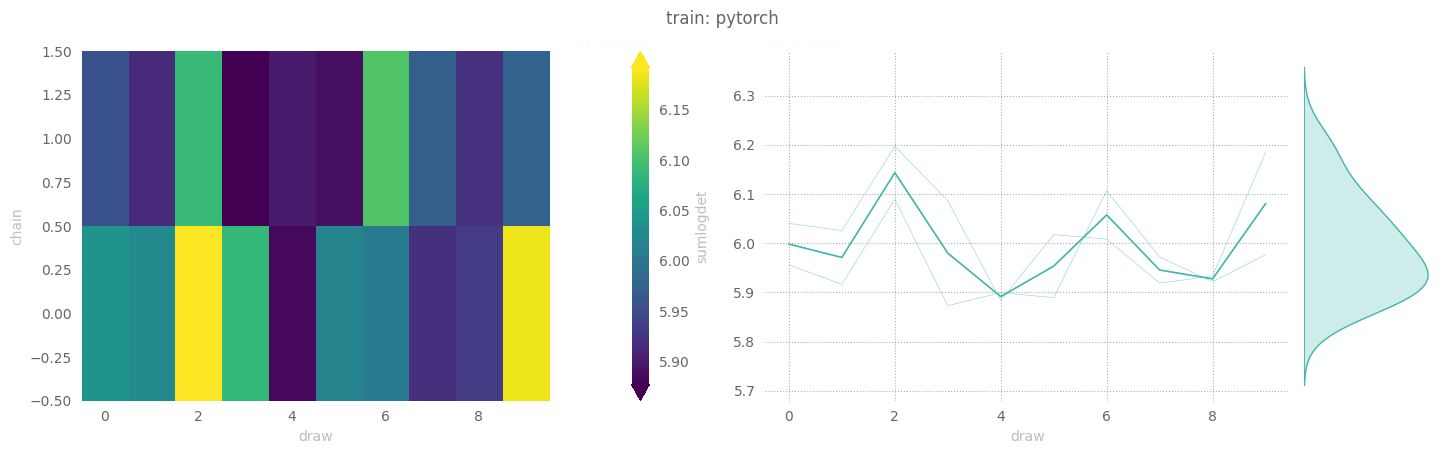

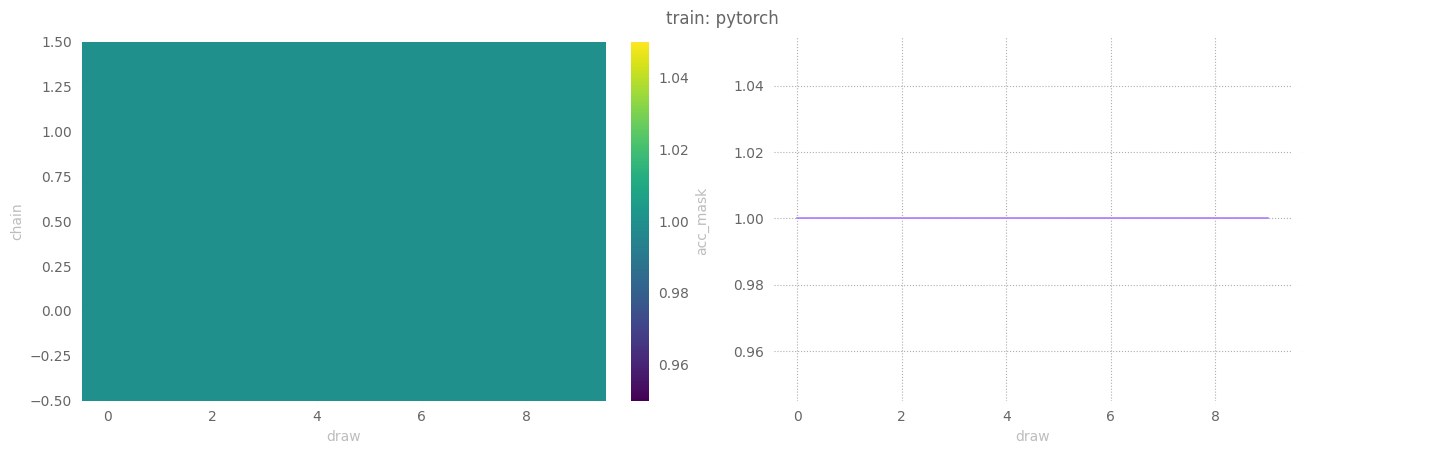

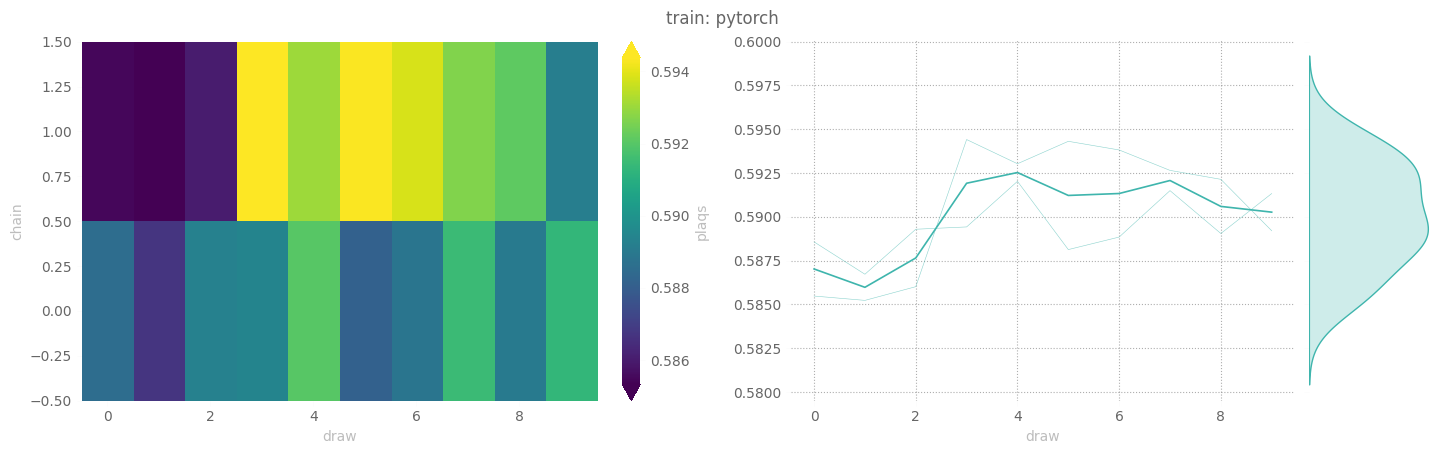

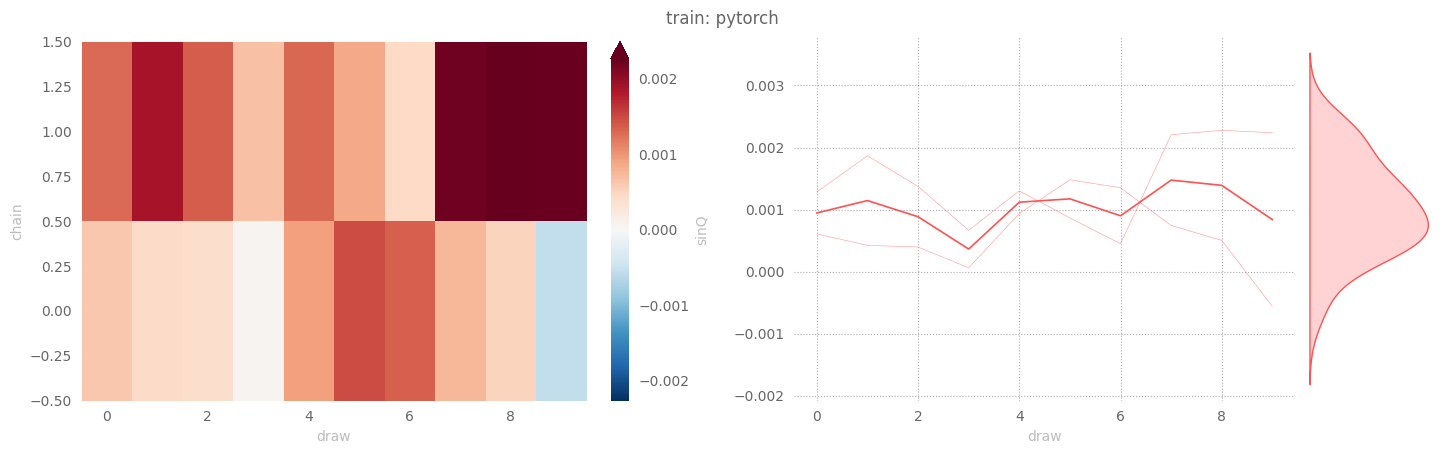

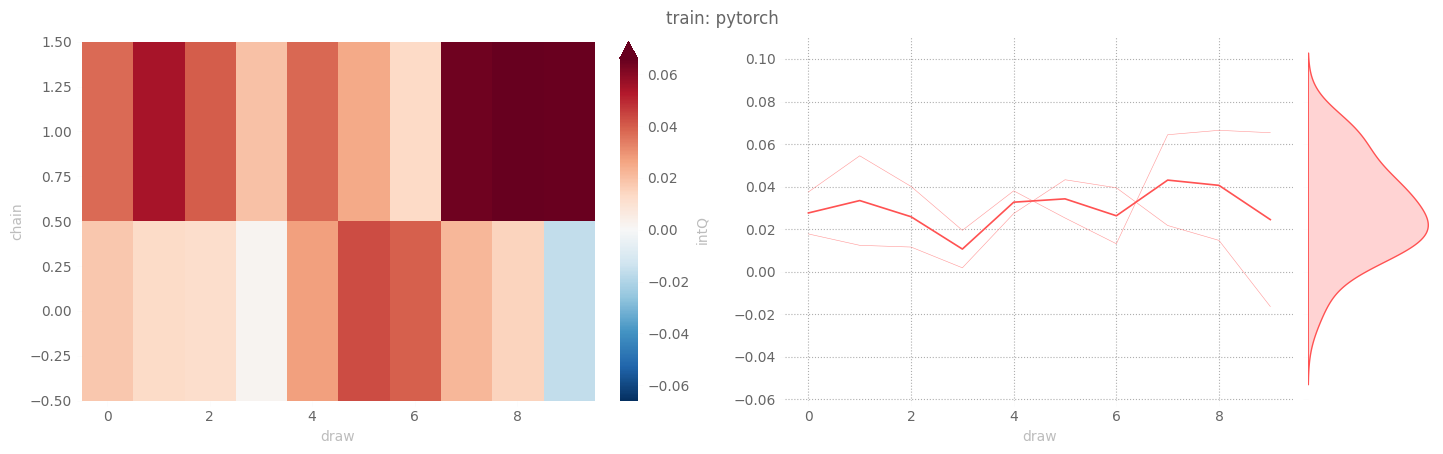

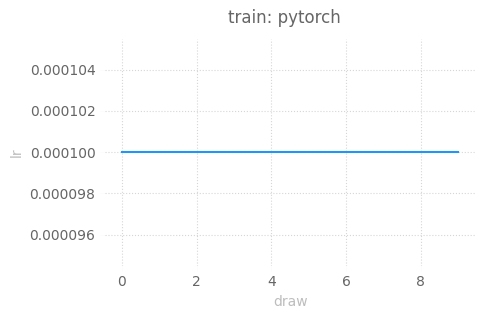

In [12]:
%matplotlib widget
from l2hmc.utils.plot_helpers import set_plot_style

set_plot_style()

train_out = ptExpSU3.train(beta=6.0)

## Evaluation

Run inference on trained model

In [13]:
torch.set_printoptions(precision=3)
np.set_printoptions(precision=3, suppress=True)

In [14]:
_ = tfExpSU3.evaluate(job_type='hmc', beta=6.0, eval_steps=100, nprint=1, eps=0.100)

NameError: name 'tfExpSU3' is not defined

In [16]:
from rich import print
from l2hmc.utils.rich import get_console
from l2hmc.network.tensorflow.network import zero_weights

console = get_console()
state_tf = tfExpSU3.trainer.dynamics.random_state(6.0)
xtf = tf.reshape(state_tf.x, tfExpSU3.trainer.dynamics.xshape)
print(f'xtf.shape: {xtf.shape}')
print(f'xtf.dtype: {xtf.dtype}')
print(f'checkSU(xtf): {gtf.checkSU(xtf)}')

for epoch in range(100):
    xtf, metrics_tf = tfExpSU3.trainer.eval_step((xtf, state_tf.beta))
    avgs_tf, summary_tf = tfExpSU3.trainer.record_metrics(
        metrics_tf,
        job_type='eval'
    )
    console.log(summary_tf)

xtf.shape: (8, 4, 8, 8, 8, 16, 3, 3)

xtf.dtype: <dtype: 'complex128'>

checkSU(xtf): (<tf.Tensor: shape=(8,), dtype=float64, numpy=array([0., 0., 0., ..., 0., 0., 
0.])>, <tf.Tensor: shape=(8,), dtype=float64, numpy=array([0., 0., 0., ..., 0., 0., 0.])>)

[17:32:14] energy=550.1308 logprob=550.1315 logdet=-0.0007 sldf=-0.0000 sldb=-0.0007         
           sld=-0.0007 xeps=0.0010 veps=0.0010 acc=0.9986 sumlogdet=0.0001 acc_mask=1.0000   
           plaqs=-0.0010 sinQ=0.0001 intQ=0.0504 dQint=0.0276 dQsin=0.0001 beta=6.0000       
           loss=99.9854 estep=0

[17:32:18] energy=168.6757 logprob=168.6766 logdet=-0.0008 sldf=-0.0002 sldb=-0.0007         
           sld=-0.0008 xeps=0.0010 veps=0.0010 acc=0.9978 sumlogdet=0.0001 acc_mask=1.0000   
           plaqs=-0.0005 sinQ=0.0001 intQ=0.0588 dQint=0.0183 dQsin=0.0000 beta=6.0000       
           loss=99.9876 estep=0

[17:32:22] energy=85.0190 logprob=85.0199 logdet=-0.0009 sldf=-0.0002 sldb=-0.0007           
           sld=-0.0009 xeps=0.0010 veps=0.0010 acc=0.9970 sumlogdet=-0.0000 acc_mask=1.0000  
           plaqs=-0.0001 sinQ=0.0001 intQ=0.0608 dQint=0.0196 dQsin=0.0000 beta=6.0000       
           loss=99.9875 estep=0

[17:32:27] energy=-66.5541 logprob=-66.5532 logdet=-0.0009 sldf=-0.0002 sldb=-0.0007         
           sld=-0.0009 xeps=0.0010 veps=0.0010 acc=0.9990 sumlogdet=0.0000 acc_mask=1.0000   
           plaqs=0.0004 sinQ=0.0001 intQ=0.0559 dQint=0.0200 dQsin=0.0000 beta=6.0000        
           loss=99.9878 estep=0

[17:32:32] energy=-201.2062 logprob=-201.2053 logdet=-0.0009 sldf=-0.0002 sldb=-0.0007       
           sld=-0.0009 xeps=0.0010 veps=0.0010 acc=0.9986 sumlogdet=-0.0001 acc_mask=1.0000  
           plaqs=0.0009 sinQ=0.0001 intQ=0.0599 dQint=0.0214 dQsin=0.0000 beta=6.0000        
           loss=99.9859 estep=0

[17:32:36] energy=-378.9047 logprob=-378.9038 logdet=-0.0009 sldf=-0.0001 sldb=-0.0007       
           sld=-0.0009 xeps=0.0010 veps=0.0010 acc=0.9994 sumlogdet=0.0001 acc_mask=1.0000   
           plaqs=0.0014 sinQ=0.0001 intQ=0.0576 dQint=0.0228 dQsin=0.0000 beta=6.0000        
           loss=99.9865 estep=0

[17:32:40] energy=-434.2759 logprob=-434.2750 logdet=-0.0010 sldf=-0.0003 sldb=-0.0007       
           sld=-0.0010 xeps=0.0010 veps=0.0010 acc=0.9980 sumlogdet=0.0000 acc_mask=1.0000   
           plaqs=0.0018 sinQ=0.0001 intQ=0.0602 dQint=0.0246 dQsin=0.0001 beta=6.0000        
           loss=99.9860 estep=0

[17:32:45] energy=-874.1818 logprob=-874.1808 logdet=-0.0010 sldf=-0.0003 sldb=-0.0006       
           sld=-0.0010 xeps=0.0010 veps=0.0010 acc=0.9974 sumlogdet=0.0000 acc_mask=1.0000   
           plaqs=0.0023 sinQ=0.0001 intQ=0.0431 dQint=0.0163 dQsin=0.0000 beta=6.0000        
           loss=99.9876 estep=0

[17:32:49] energy=-964.7612 logprob=-964.7601 logdet=-0.0010 sldf=-0.0003 sldb=-0.0007       
           sld=-0.0010 xeps=0.0010 veps=0.0010 acc=0.9977 sumlogdet=-0.0001 acc_mask=1.0000  
           plaqs=0.0027 sinQ=0.0001 intQ=0.0431 dQint=0.0187 dQsin=0.0000 beta=6.0000        
           loss=99.9877 estep=0

[17:32:54] energy=-894.7905 logprob=-894.7896 logdet=-0.0009 sldf=-0.0002 sldb=-0.0007       
           sld=-0.0009 xeps=0.0010 veps=0.0010 acc=0.9970 sumlogdet=-0.0001 acc_mask=1.0000  
           plaqs=0.0032 sinQ=0.0001 intQ=0.0453 dQint=0.0214 dQsin=0.0000 beta=6.0000        
           loss=99.9868 estep=0

[17:32:58] energy=-953.4873 logprob=-953.4864 logdet=-0.0008 sldf=-0.0000 sldb=-0.0008       
           sld=-0.0008 xeps=0.0010 veps=0.0010 acc=0.9982 sumlogdet=-0.0001 acc_mask=1.0000  
           plaqs=0.0036 sinQ=0.0001 intQ=0.0446 dQint=0.0119 dQsin=0.0000 beta=6.0000        
           loss=99.9890 estep=0

[17:33:02] energy=-967.8095 logprob=-967.8087 logdet=-0.0007 sldf=0.0001 sldb=-0.0008        
           sld=-0.0007 xeps=0.0010 veps=0.0010 acc=0.9932 sumlogdet=-0.0000 acc_mask=1.0000  
           plaqs=0.0041 sinQ=0.0001 intQ=0.0515 dQint=0.0253 dQsin=0.0001 beta=6.0000        
           loss=99.9854 estep=0

[17:33:07] energy=-1108.4324 logprob=-1108.4317 logdet=-0.0007 sldf=0.0001 sldb=-0.0008      
           sld=-0.0007 xeps=0.0010 veps=0.0010 acc=0.9958 sumlogdet=0.0001 acc_mask=1.0000   
           plaqs=0.0045 sinQ=0.0001 intQ=0.0647 dQint=0.0210 dQsin=0.0000 beta=6.0000        
           loss=99.9865 estep=0

[17:33:11] energy=-1346.2939 logprob=-1346.2931 logdet=-0.0008 sldf=0.0000 sldb=-0.0008      
           sld=-0.0008 xeps=0.0010 veps=0.0010 acc=0.9996 sumlogdet=-0.0000 acc_mask=1.0000  
           plaqs=0.0050 sinQ=0.0001 intQ=0.0683 dQint=0.0302 dQsin=0.0001 beta=6.0000        
           loss=99.9846 estep=0

[17:33:16] energy=-1807.4928 logprob=-1807.4920 logdet=-0.0008 sldf=0.0000 sldb=-0.0008      
           sld=-0.0008 xeps=0.0010 veps=0.0010 acc=0.9961 sumlogdet=-0.0000 acc_mask=1.0000  
           plaqs=0.0055 sinQ=0.0001 intQ=0.0489 dQint=0.0240 dQsin=0.0001 beta=6.0000        
           loss=99.9863 estep=0

[17:33:20] energy=-1662.3761 logprob=-1662.3753 logdet=-0.0008 sldf=0.0000 sldb=-0.0008      
           sld=-0.0008 xeps=0.0010 veps=0.0010 acc=0.9973 sumlogdet=0.0001 acc_mask=1.0000   
           plaqs=0.0059 sinQ=0.0001 intQ=0.0560 dQint=0.0256 dQsin=0.0001 beta=6.0000        
           loss=99.9864 estep=0

[17:33:24] energy=-1930.9123 logprob=-1930.9114 logdet=-0.0009 sldf=-0.0001 sldb=-0.0008     
           sld=-0.0009 xeps=0.0010 veps=0.0010 acc=0.9959 sumlogdet=-0.0000 acc_mask=1.0000  
           plaqs=0.0063 sinQ=0.0001 intQ=0.0615 dQint=0.0240 dQsin=0.0001 beta=6.0000        
           loss=99.9869 estep=0

[17:33:29] energy=-2007.6252 logprob=-2007.6244 logdet=-0.0009 sldf=-0.0001 sldb=-0.0008     
           sld=-0.0009 xeps=0.0010 veps=0.0010 acc=0.9951 sumlogdet=-0.0000 acc_mask=1.0000  
           plaqs=0.0068 sinQ=0.0001 intQ=0.0678 dQint=0.0209 dQsin=0.0000 beta=6.0000        
           loss=99.9870 estep=0

[17:33:33] energy=-2184.8203 logprob=-2184.8194 logdet=-0.0008 sldf=-0.0000 sldb=-0.0008     
           sld=-0.0008 xeps=0.0010 veps=0.0010 acc=0.9976 sumlogdet=0.0000 acc_mask=1.0000   
           plaqs=0.0072 sinQ=0.0002 intQ=0.0711 dQint=0.0280 dQsin=0.0001 beta=6.0000        
           loss=99.9849 estep=0

[17:33:38] energy=-2374.1718 logprob=-2374.1709 logdet=-0.0009 sldf=-0.0001 sldb=-0.0008     
           sld=-0.0009 xeps=0.0010 veps=0.0010 acc=0.9956 sumlogdet=-0.0001 acc_mask=1.0000  
           plaqs=0.0076 sinQ=0.0001 intQ=0.0599 dQint=0.0158 dQsin=0.0000 beta=6.0000        
           loss=99.9877 estep=0

[17:33:42] energy=-2332.5565 logprob=-2332.5558 logdet=-0.0008 sldf=0.0000 sldb=-0.0008      
           sld=-0.0008 xeps=0.0010 veps=0.0010 acc=0.9975 sumlogdet=-0.0000 acc_mask=1.0000  
           plaqs=0.0081 sinQ=0.0001 intQ=0.0598 dQint=0.0255 dQsin=0.0001 beta=6.0000        
           loss=99.9854 estep=0

[17:33:47] energy=-2527.8811 logprob=-2527.8803 logdet=-0.0007 sldf=0.0001 sldb=-0.0008      
           sld=-0.0007 xeps=0.0010 veps=0.0010 acc=0.9983 sumlogdet=-0.0000 acc_mask=1.0000  
           plaqs=0.0085 sinQ=0.0002 intQ=0.0728 dQint=0.0344 dQsin=0.0001 beta=6.0000        
           loss=99.9836 estep=0

[17:33:51] energy=-2570.9735 logprob=-2570.9728 logdet=-0.0007 sldf=0.0001 sldb=-0.0009      
           sld=-0.0007 xeps=0.0010 veps=0.0010 acc=0.9965 sumlogdet=-0.0001 acc_mask=1.0000  
           plaqs=0.0090 sinQ=0.0002 intQ=0.0793 dQint=0.0177 dQsin=0.0000 beta=6.0000        
           loss=99.9878 estep=0

[17:33:56] energy=-2629.4742 logprob=-2629.4736 logdet=-0.0007 sldf=0.0002 sldb=-0.0009      
           sld=-0.0007 xeps=0.0010 veps=0.0010 acc=0.9993 sumlogdet=0.0001 acc_mask=1.0000   
           plaqs=0.0094 sinQ=0.0002 intQ=0.0815 dQint=0.0188 dQsin=0.0000 beta=6.0000        
           loss=99.9871 estep=0

[17:34:00] energy=-2751.7369 logprob=-2751.7362 logdet=-0.0007 sldf=0.0001 sldb=-0.0008      
           sld=-0.0007 xeps=0.0010 veps=0.0010 acc=0.9934 sumlogdet=0.0001 acc_mask=0.8750   
           plaqs=0.0099 sinQ=0.0002 intQ=0.0863 dQint=0.0220 dQsin=0.0000 beta=6.0000        
           loss=99.9861 estep=0

[17:34:04] energy=-3189.5401 logprob=-3189.5393 logdet=-0.0009 sldf=-0.0000 sldb=-0.0008     
           sld=-0.0009 xeps=0.0010 veps=0.0010 acc=0.9954 sumlogdet=-0.0000 acc_mask=1.0000  
           plaqs=0.0103 sinQ=0.0002 intQ=0.0815 dQint=0.0254 dQsin=0.0001 beta=6.0000        
           loss=99.9865 estep=0

[17:34:09] energy=-3168.0566 logprob=-3168.0557 logdet=-0.0008 sldf=-0.0000 sldb=-0.0008     
           sld=-0.0008 xeps=0.0010 veps=0.0010 acc=0.9955 sumlogdet=-0.0000 acc_mask=0.8750  
           plaqs=0.0107 sinQ=0.0002 intQ=0.0828 dQint=0.0137 dQsin=0.0000 beta=6.0000        
           loss=99.9879 estep=0

[17:34:13] energy=-3205.6609 logprob=-3205.6601 logdet=-0.0008 sldf=0.0001 sldb=-0.0009      
           sld=-0.0008 xeps=0.0010 veps=0.0010 acc=0.9950 sumlogdet=-0.0001 acc_mask=1.0000  
           plaqs=0.0111 sinQ=0.0002 intQ=0.0897 dQint=0.0225 dQsin=0.0000 beta=6.0000        
           loss=99.9871 estep=0

[17:34:17] energy=-3532.3283 logprob=-3532.3276 logdet=-0.0007 sldf=0.0002 sldb=-0.0009      
           sld=-0.0007 xeps=0.0010 veps=0.0010 acc=0.9960 sumlogdet=-0.0001 acc_mask=1.0000  
           plaqs=0.0116 sinQ=0.0002 intQ=0.0834 dQint=0.0249 dQsin=0.0001 beta=6.0000        
           loss=99.9860 estep=0

[17:34:22] energy=-3753.9157 logprob=-3753.9151 logdet=-0.0006 sldf=0.0003 sldb=-0.0009      
           sld=-0.0006 xeps=0.0010 veps=0.0010 acc=0.9978 sumlogdet=-0.0001 acc_mask=1.0000  
           plaqs=0.0120 sinQ=0.0002 intQ=0.0846 dQint=0.0149 dQsin=0.0000 beta=6.0000        
           loss=99.9882 estep=0

[17:34:26] energy=-3582.3952 logprob=-3582.3947 logdet=-0.0005 sldf=0.0003 sldb=-0.0009      
           sld=-0.0005 xeps=0.0010 veps=0.0010 acc=0.9949 sumlogdet=-0.0001 acc_mask=1.0000  
           plaqs=0.0125 sinQ=0.0002 intQ=0.0762 dQint=0.0198 dQsin=0.0000 beta=6.0000        
           loss=99.9870 estep=0

[17:34:31] energy=-3992.1112 logprob=-3992.1108 logdet=-0.0004 sldf=0.0005 sldb=-0.0009      
           sld=-0.0004 xeps=0.0010 veps=0.0010 acc=0.9945 sumlogdet=-0.0001 acc_mask=1.0000  
           plaqs=0.0129 sinQ=0.0001 intQ=0.0671 dQint=0.0216 dQsin=0.0000 beta=6.0000        
           loss=99.9865 estep=0

[17:34:35] energy=-3872.4364 logprob=-3872.4360 logdet=-0.0004 sldf=0.0005 sldb=-0.0009      
           sld=-0.0004 xeps=0.0010 veps=0.0010 acc=0.9951 sumlogdet=0.0000 acc_mask=1.0000   
           plaqs=0.0133 sinQ=0.0002 intQ=0.0798 dQint=0.0263 dQsin=0.0001 beta=6.0000        
           loss=99.9853 estep=0

[17:34:40] energy=-4051.5455 logprob=-4051.5451 logdet=-0.0004 sldf=0.0005 sldb=-0.0009      
           sld=-0.0004 xeps=0.0010 veps=0.0010 acc=0.9986 sumlogdet=0.0000 acc_mask=1.0000   
           plaqs=0.0138 sinQ=0.0002 intQ=0.0762 dQint=0.0293 dQsin=0.0001 beta=6.0000        
           loss=99.9850 estep=0

[17:34:44] energy=-4126.6837 logprob=-4126.6833 logdet=-0.0004 sldf=0.0004 sldb=-0.0008      
           sld=-0.0004 xeps=0.0010 veps=0.0010 acc=0.9963 sumlogdet=0.0001 acc_mask=1.0000   
           plaqs=0.0142 sinQ=0.0002 intQ=0.0717 dQint=0.0283 dQsin=0.0001 beta=6.0000        
           loss=99.9840 estep=0

[17:34:48] energy=-4110.5474 logprob=-4110.5469 logdet=-0.0005 sldf=0.0004 sldb=-0.0008      
           sld=-0.0005 xeps=0.0010 veps=0.0010 acc=0.9986 sumlogdet=0.0001 acc_mask=1.0000   
           plaqs=0.0146 sinQ=0.0001 intQ=0.0522 dQint=0.0145 dQsin=0.0000 beta=6.0000        
           loss=99.9877 estep=0

[17:34:53] energy=-4180.7397 logprob=-4180.7392 logdet=-0.0005 sldf=0.0003 sldb=-0.0008      
           sld=-0.0005 xeps=0.0010 veps=0.0010 acc=0.9962 sumlogdet=-0.0000 acc_mask=1.0000  
           plaqs=0.0151 sinQ=0.0001 intQ=0.0500 dQint=0.0095 dQsin=0.0000 beta=6.0000        
           loss=99.9892 estep=0

[17:34:57] energy=-4634.4280 logprob=-4634.4275 logdet=-0.0005 sldf=0.0003 sldb=-0.0008      
           sld=-0.0005 xeps=0.0010 veps=0.0010 acc=0.9979 sumlogdet=0.0001 acc_mask=1.0000   
           plaqs=0.0155 sinQ=0.0001 intQ=0.0537 dQint=0.0118 dQsin=0.0000 beta=6.0000        
           loss=99.9883 estep=0

[17:35:01] energy=-4800.9922 logprob=-4800.9917 logdet=-0.0006 sldf=0.0002 sldb=-0.0008      
           sld=-0.0006 xeps=0.0010 veps=0.0010 acc=0.9970 sumlogdet=-0.0000 acc_mask=1.0000  
           plaqs=0.0159 sinQ=0.0001 intQ=0.0449 dQint=0.0264 dQsin=0.0001 beta=6.0000        
           loss=99.9856 estep=0

[17:35:06] energy=-4889.3448 logprob=-4889.3442 logdet=-0.0006 sldf=0.0002 sldb=-0.0008      
           sld=-0.0006 xeps=0.0010 veps=0.0010 acc=0.9938 sumlogdet=0.0000 acc_mask=1.0000   
           plaqs=0.0164 sinQ=0.0001 intQ=0.0520 dQint=0.0186 dQsin=0.0000 beta=6.0000        
           loss=99.9877 estep=0

[17:35:10] energy=-4978.8781 logprob=-4978.8775 logdet=-0.0006 sldf=0.0001 sldb=-0.0008      
           sld=-0.0006 xeps=0.0010 veps=0.0010 acc=0.9980 sumlogdet=-0.0000 acc_mask=1.0000  
           plaqs=0.0168 sinQ=0.0001 intQ=0.0490 dQint=0.0218 dQsin=0.0000 beta=6.0000        
           loss=99.9864 estep=0

[17:35:15] energy=-5009.5158 logprob=-5009.5152 logdet=-0.0006 sldf=0.0002 sldb=-0.0008      
           sld=-0.0006 xeps=0.0010 veps=0.0010 acc=0.9966 sumlogdet=-0.0001 acc_mask=1.0000  
           plaqs=0.0173 sinQ=0.0001 intQ=0.0440 dQint=0.0268 dQsin=0.0001 beta=6.0000        
           loss=99.9853 estep=0

[17:35:19] energy=-5104.3447 logprob=-5104.3441 logdet=-0.0005 sldf=0.0003 sldb=-0.0008      
           sld=-0.0005 xeps=0.0010 veps=0.0010 acc=0.9948 sumlogdet=0.0001 acc_mask=1.0000   
           plaqs=0.0177 sinQ=0.0001 intQ=0.0591 dQint=0.0212 dQsin=0.0000 beta=6.0000        
           loss=99.9867 estep=0

[17:35:23] energy=-5291.6341 logprob=-5291.6335 logdet=-0.0006 sldf=0.0001 sldb=-0.0007      
           sld=-0.0006 xeps=0.0010 veps=0.0010 acc=0.9977 sumlogdet=-0.0000 acc_mask=1.0000  
           plaqs=0.0181 sinQ=0.0001 intQ=0.0469 dQint=0.0190 dQsin=0.0000 beta=6.0000        
           loss=99.9876 estep=0

[17:35:28] energy=-5580.6791 logprob=-5580.6785 logdet=-0.0006 sldf=0.0001 sldb=-0.0007      
           sld=-0.0006 xeps=0.0010 veps=0.0010 acc=0.9976 sumlogdet=-0.0000 acc_mask=1.0000  
           plaqs=0.0186 sinQ=0.0001 intQ=0.0446 dQint=0.0220 dQsin=0.0000 beta=6.0000        
           loss=99.9871 estep=0

[17:35:32] energy=-5737.5038 logprob=-5737.5033 logdet=-0.0006 sldf=0.0001 sldb=-0.0007      
           sld=-0.0006 xeps=0.0010 veps=0.0010 acc=0.9945 sumlogdet=-0.0001 acc_mask=1.0000  
           plaqs=0.0190 sinQ=0.0001 intQ=0.0288 dQint=0.0133 dQsin=0.0000 beta=6.0000        
           loss=99.9886 estep=0

[17:35:37] energy=-5859.1684 logprob=-5859.1679 logdet=-0.0005 sldf=0.0003 sldb=-0.0008      
           sld=-0.0005 xeps=0.0010 veps=0.0010 acc=0.9942 sumlogdet=-0.0001 acc_mask=1.0000  
           plaqs=0.0194 sinQ=0.0001 intQ=0.0421 dQint=0.0242 dQsin=0.0001 beta=6.0000        
           loss=99.9863 estep=0

[17:35:41] energy=-5706.1505 logprob=-5706.1501 logdet=-0.0004 sldf=0.0004 sldb=-0.0008      
           sld=-0.0004 xeps=0.0010 veps=0.0010 acc=0.9965 sumlogdet=0.0000 acc_mask=1.0000   
           plaqs=0.0199 sinQ=0.0001 intQ=0.0461 dQint=0.0154 dQsin=0.0000 beta=6.0000        
           loss=99.9885 estep=0

[17:35:45] energy=-6059.1307 logprob=-6059.1303 logdet=-0.0005 sldf=0.0003 sldb=-0.0008      
           sld=-0.0005 xeps=0.0010 veps=0.0010 acc=0.9977 sumlogdet=-0.0000 acc_mask=1.0000  
           plaqs=0.0203 sinQ=0.0001 intQ=0.0376 dQint=0.0139 dQsin=0.0000 beta=6.0000        
           loss=99.9881 estep=0

[17:35:50] energy=-6299.6109 logprob=-6299.6105 logdet=-0.0004 sldf=0.0003 sldb=-0.0008      
           sld=-0.0004 xeps=0.0010 veps=0.0010 acc=0.9942 sumlogdet=0.0000 acc_mask=1.0000   
           plaqs=0.0207 sinQ=0.0001 intQ=0.0503 dQint=0.0176 dQsin=0.0000 beta=6.0000        
           loss=99.9875 estep=0

[17:35:54] energy=-6069.7011 logprob=-6069.7007 logdet=-0.0005 sldf=0.0004 sldb=-0.0008      
           sld=-0.0005 xeps=0.0010 veps=0.0010 acc=0.9960 sumlogdet=0.0000 acc_mask=1.0000   
           plaqs=0.0212 sinQ=0.0001 intQ=0.0502 dQint=0.0191 dQsin=0.0000 beta=6.0000        
           loss=99.9873 estep=0

[17:35:59] energy=-6159.4217 logprob=-6159.4212 logdet=-0.0005 sldf=0.0003 sldb=-0.0008      
           sld=-0.0005 xeps=0.0010 veps=0.0010 acc=0.9942 sumlogdet=0.0001 acc_mask=1.0000   
           plaqs=0.0216 sinQ=0.0001 intQ=0.0542 dQint=0.0204 dQsin=0.0000 beta=6.0000        
           loss=99.9868 estep=0

[17:36:03] energy=-6553.4311 logprob=-6553.4306 logdet=-0.0006 sldf=0.0002 sldb=-0.0008      
           sld=-0.0006 xeps=0.0010 veps=0.0010 acc=0.9957 sumlogdet=-0.0000 acc_mask=1.0000  
           plaqs=0.0221 sinQ=0.0001 intQ=0.0610 dQint=0.0337 dQsin=0.0001 beta=6.0000        
           loss=99.9833 estep=0

[17:36:08] energy=-6538.0676 logprob=-6538.0671 logdet=-0.0005 sldf=0.0002 sldb=-0.0007      
           sld=-0.0005 xeps=0.0010 veps=0.0010 acc=0.9964 sumlogdet=0.0001 acc_mask=1.0000   
           plaqs=0.0225 sinQ=0.0001 intQ=0.0596 dQint=0.0173 dQsin=0.0000 beta=6.0000        
           loss=99.9880 estep=0

[17:36:12] energy=-6569.5565 logprob=-6569.5558 logdet=-0.0006 sldf=0.0000 sldb=-0.0006      
           sld=-0.0006 xeps=0.0010 veps=0.0010 acc=0.9949 sumlogdet=0.0000 acc_mask=1.0000   
           plaqs=0.0229 sinQ=0.0001 intQ=0.0537 dQint=0.0116 dQsin=0.0000 beta=6.0000        
           loss=99.9892 estep=0

[17:36:16] energy=-6741.7221 logprob=-6741.7214 logdet=-0.0007 sldf=-0.0001 sldb=-0.0006     
           sld=-0.0007 xeps=0.0010 veps=0.0010 acc=0.9970 sumlogdet=-0.0000 acc_mask=1.0000  
           plaqs=0.0233 sinQ=0.0001 intQ=0.0534 dQint=0.0260 dQsin=0.0001 beta=6.0000        
           loss=99.9846 estep=0

[17:36:21] energy=-7163.3030 logprob=-7163.3023 logdet=-0.0007 sldf=-0.0001 sldb=-0.0005     
           sld=-0.0007 xeps=0.0010 veps=0.0010 acc=0.9983 sumlogdet=0.0000 acc_mask=1.0000   
           plaqs=0.0238 sinQ=0.0001 intQ=0.0580 dQint=0.0211 dQsin=0.0000 beta=6.0000        
           loss=99.9868 estep=0

[17:36:25] energy=-7371.1637 logprob=-7371.1630 logdet=-0.0007 sldf=-0.0001 sldb=-0.0005     
           sld=-0.0007 xeps=0.0010 veps=0.0010 acc=0.9968 sumlogdet=-0.0000 acc_mask=1.0000  
           plaqs=0.0243 sinQ=0.0001 intQ=0.0405 dQint=0.0182 dQsin=0.0000 beta=6.0000        
           loss=99.9872 estep=0

[17:36:30] energy=-7290.8630 logprob=-7290.8624 logdet=-0.0006 sldf=-0.0001 sldb=-0.0005     
           sld=-0.0006 xeps=0.0010 veps=0.0010 acc=0.9976 sumlogdet=-0.0001 acc_mask=1.0000  
           plaqs=0.0247 sinQ=0.0001 intQ=0.0395 dQint=0.0252 dQsin=0.0001 beta=6.0000        
           loss=99.9862 estep=0

[17:36:34] energy=-7561.4441 logprob=-7561.4435 logdet=-0.0005 sldf=-0.0000 sldb=-0.0005     
           sld=-0.0005 xeps=0.0010 veps=0.0010 acc=0.9970 sumlogdet=0.0000 acc_mask=1.0000   
           plaqs=0.0251 sinQ=0.0001 intQ=0.0325 dQint=0.0190 dQsin=0.0000 beta=6.0000        
           loss=99.9876 estep=0

[17:36:38] energy=-7516.5822 logprob=-7516.5816 logdet=-0.0006 sldf=-0.0001 sldb=-0.0005     
           sld=-0.0006 xeps=0.0010 veps=0.0010 acc=0.9976 sumlogdet=-0.0000 acc_mask=1.0000  
           plaqs=0.0256 sinQ=0.0001 intQ=0.0426 dQint=0.0258 dQsin=0.0001 beta=6.0000        
           loss=99.9853 estep=0

[17:36:43] energy=-7755.0107 logprob=-7755.0101 logdet=-0.0006 sldf=-0.0001 sldb=-0.0005     
           sld=-0.0006 xeps=0.0010 veps=0.0010 acc=0.9954 sumlogdet=0.0001 acc_mask=1.0000   
           plaqs=0.0260 sinQ=0.0001 intQ=0.0347 dQint=0.0158 dQsin=0.0000 beta=6.0000        
           loss=99.9886 estep=0

[17:36:47] energy=-7905.0545 logprob=-7905.0539 logdet=-0.0007 sldf=-0.0003 sldb=-0.0004     
           sld=-0.0007 xeps=0.0010 veps=0.0010 acc=0.9991 sumlogdet=0.0001 acc_mask=1.0000   
           plaqs=0.0264 sinQ=0.0001 intQ=0.0386 dQint=0.0131 dQsin=0.0000 beta=6.0000        
           loss=99.9891 estep=0

[17:36:52] energy=-8125.8554 logprob=-8125.8546 logdet=-0.0007 sldf=-0.0003 sldb=-0.0004     
           sld=-0.0007 xeps=0.0010 veps=0.0010 acc=0.9995 sumlogdet=-0.0000 acc_mask=1.0000  
           plaqs=0.0268 sinQ=0.0001 intQ=0.0427 dQint=0.0236 dQsin=0.0001 beta=6.0000        
           loss=99.9867 estep=0

[17:36:56] energy=-7875.7160 logprob=-7875.7154 logdet=-0.0007 sldf=-0.0003 sldb=-0.0004     
           sld=-0.0007 xeps=0.0010 veps=0.0010 acc=0.9986 sumlogdet=0.0001 acc_mask=1.0000   
           plaqs=0.0272 sinQ=0.0001 intQ=0.0409 dQint=0.0170 dQsin=0.0000 beta=6.0000        
           loss=99.9880 estep=0

[17:37:00] energy=-8203.4565 logprob=-8203.4557 logdet=-0.0008 sldf=-0.0004 sldb=-0.0004     
           sld=-0.0008 xeps=0.0010 veps=0.0010 acc=0.9978 sumlogdet=0.0001 acc_mask=1.0000   
           plaqs=0.0277 sinQ=0.0001 intQ=0.0537 dQint=0.0129 dQsin=0.0000 beta=6.0000        
           loss=99.9888 estep=0

[17:37:05] energy=-8129.9484 logprob=-8129.9475 logdet=-0.0009 sldf=-0.0005 sldb=-0.0004     
           sld=-0.0009 xeps=0.0010 veps=0.0010 acc=0.9962 sumlogdet=0.0001 acc_mask=1.0000   
           plaqs=0.0281 sinQ=0.0001 intQ=0.0428 dQint=0.0095 dQsin=0.0000 beta=6.0000        
           loss=99.9893 estep=0

[17:37:09] energy=-8550.5975 logprob=-8550.5966 logdet=-0.0009 sldf=-0.0005 sldb=-0.0004     
           sld=-0.0009 xeps=0.0010 veps=0.0010 acc=0.9971 sumlogdet=-0.0000 acc_mask=1.0000  
           plaqs=0.0285 sinQ=0.0001 intQ=0.0443 dQint=0.0157 dQsin=0.0000 beta=6.0000        
           loss=99.9876 estep=0

[17:37:14] energy=-8493.4662 logprob=-8493.4653 logdet=-0.0009 sldf=-0.0005 sldb=-0.0004     
           sld=-0.0009 xeps=0.0010 veps=0.0010 acc=0.9962 sumlogdet=0.0000 acc_mask=1.0000   
           plaqs=0.0290 sinQ=0.0001 intQ=0.0449 dQint=0.0236 dQsin=0.0001 beta=6.0000        
           loss=99.9864 estep=0

[17:37:18] energy=-8718.9653 logprob=-8718.9644 logdet=-0.0009 sldf=-0.0005 sldb=-0.0004     
           sld=-0.0009 xeps=0.0010 veps=0.0010 acc=0.9976 sumlogdet=-0.0000 acc_mask=1.0000  
           plaqs=0.0294 sinQ=0.0001 intQ=0.0316 dQint=0.0226 dQsin=0.0000 beta=6.0000        
           loss=99.9862 estep=0

[17:37:23] energy=-8885.4950 logprob=-8885.4941 logdet=-0.0009 sldf=-0.0004 sldb=-0.0004     
           sld=-0.0009 xeps=0.0010 veps=0.0010 acc=0.9905 sumlogdet=-0.0000 acc_mask=1.0000  
           plaqs=0.0299 sinQ=0.0001 intQ=0.0292 dQint=0.0252 dQsin=0.0001 beta=6.0000        
           loss=99.9857 estep=0

[17:37:27] energy=-8700.5179 logprob=-8700.5170 logdet=-0.0008 sldf=-0.0004 sldb=-0.0004     
           sld=-0.0008 xeps=0.0010 veps=0.0010 acc=0.9967 sumlogdet=0.0001 acc_mask=1.0000   
           plaqs=0.0303 sinQ=0.0001 intQ=0.0544 dQint=0.0187 dQsin=0.0000 beta=6.0000        
           loss=99.9879 estep=0

[17:37:31] energy=-9046.1503 logprob=-9046.1494 logdet=-0.0010 sldf=-0.0005 sldb=-0.0004     
           sld=-0.0010 xeps=0.0010 veps=0.0010 acc=0.9966 sumlogdet=-0.0000 acc_mask=1.0000  
           plaqs=0.0307 sinQ=0.0001 intQ=0.0552 dQint=0.0233 dQsin=0.0000 beta=6.0000        
           loss=99.9869 estep=0

[17:37:36] energy=-9284.6822 logprob=-9284.6812 logdet=-0.0009 sldf=-0.0005 sldb=-0.0004     
           sld=-0.0009 xeps=0.0010 veps=0.0010 acc=0.9957 sumlogdet=0.0001 acc_mask=1.0000   
           plaqs=0.0311 sinQ=0.0001 intQ=0.0467 dQint=0.0250 dQsin=0.0001 beta=6.0000        
           loss=99.9865 estep=0

[17:37:40] energy=-9255.8026 logprob=-9255.8017 logdet=-0.0010 sldf=-0.0006 sldb=-0.0004     
           sld=-0.0010 xeps=0.0010 veps=0.0010 acc=0.9937 sumlogdet=0.0001 acc_mask=1.0000   
           plaqs=0.0316 sinQ=0.0001 intQ=0.0428 dQint=0.0193 dQsin=0.0000 beta=6.0000        
           loss=99.9869 estep=0

[17:37:45] energy=-9381.4941 logprob=-9381.4930 logdet=-0.0011 sldf=-0.0006 sldb=-0.0004     
           sld=-0.0011 xeps=0.0010 veps=0.0010 acc=0.9973 sumlogdet=0.0000 acc_mask=1.0000   
           plaqs=0.0320 sinQ=0.0001 intQ=0.0477 dQint=0.0213 dQsin=0.0000 beta=6.0000        
           loss=99.9876 estep=0

[17:37:49] energy=-9442.6921 logprob=-9442.6910 logdet=-0.0011 sldf=-0.0006 sldb=-0.0004     
           sld=-0.0011 xeps=0.0010 veps=0.0010 acc=0.9962 sumlogdet=0.0000 acc_mask=1.0000   
           plaqs=0.0324 sinQ=0.0001 intQ=0.0334 dQint=0.0250 dQsin=0.0001 beta=6.0000        
           loss=99.9842 estep=0

[17:37:53] energy=-9792.3012 logprob=-9792.3001 logdet=-0.0011 sldf=-0.0006 sldb=-0.0005     
           sld=-0.0011 xeps=0.0010 veps=0.0010 acc=0.9967 sumlogdet=0.0000 acc_mask=1.0000   
           plaqs=0.0329 sinQ=0.0001 intQ=0.0278 dQint=0.0110 dQsin=0.0000 beta=6.0000        
           loss=99.9892 estep=0

[17:37:58] energy=-9729.4333 logprob=-9729.4322 logdet=-0.0011 sldf=-0.0006 sldb=-0.0004     
           sld=-0.0011 xeps=0.0010 veps=0.0010 acc=0.9970 sumlogdet=0.0001 acc_mask=1.0000   
           plaqs=0.0334 sinQ=0.0001 intQ=0.0316 dQint=0.0221 dQsin=0.0000 beta=6.0000        
           loss=99.9872 estep=0

[17:38:02] energy=-10018.2628 logprob=-10018.2617 logdet=-0.0011 sldf=-0.0007 sldb=-0.0005   
           sld=-0.0011 xeps=0.0010 veps=0.0010 acc=0.9954 sumlogdet=-0.0001 acc_mask=1.0000  
           plaqs=0.0338 sinQ=0.0000 intQ=0.0201 dQint=0.0243 dQsin=0.0001 beta=6.0000        
           loss=99.9858 estep=0

[17:38:07] energy=-9872.2461 logprob=-9872.2450 logdet=-0.0010 sldf=-0.0006 sldb=-0.0004     
           sld=-0.0010 xeps=0.0010 veps=0.0010 acc=0.9966 sumlogdet=0.0001 acc_mask=1.0000   
           plaqs=0.0342 sinQ=0.0001 intQ=0.0266 dQint=0.0169 dQsin=0.0000 beta=6.0000        
           loss=99.9874 estep=0

[17:38:11] energy=-10209.8215 logprob=-10209.8203 logdet=-0.0011 sldf=-0.0007 sldb=-0.0004   
           sld=-0.0011 xeps=0.0010 veps=0.0010 acc=0.9966 sumlogdet=0.0000 acc_mask=1.0000   
           plaqs=0.0347 sinQ=0.0001 intQ=0.0250 dQint=0.0163 dQsin=0.0000 beta=6.0000        
           loss=99.9878 estep=0

[17:38:15] energy=-10441.7083 logprob=-10441.7071 logdet=-0.0011 sldf=-0.0007 sldb=-0.0005   
           sld=-0.0011 xeps=0.0010 veps=0.0010 acc=0.9964 sumlogdet=-0.0000 acc_mask=1.0000  
           plaqs=0.0351 sinQ=0.0001 intQ=0.0343 dQint=0.0108 dQsin=0.0000 beta=6.0000        
           loss=99.9891 estep=0

[17:38:20] energy=-10276.2698 logprob=-10276.2687 logdet=-0.0011 sldf=-0.0007 sldb=-0.0004   
           sld=-0.0011 xeps=0.0010 veps=0.0010 acc=0.9994 sumlogdet=0.0001 acc_mask=1.0000   
           plaqs=0.0355 sinQ=0.0001 intQ=0.0425 dQint=0.0133 dQsin=0.0000 beta=6.0000        
           loss=99.9887 estep=0

[17:38:24] energy=-10391.7510 logprob=-10391.7497 logdet=-0.0012 sldf=-0.0007 sldb=-0.0005   
           sld=-0.0012 xeps=0.0010 veps=0.0010 acc=0.9952 sumlogdet=-0.0001 acc_mask=1.0000  
           plaqs=0.0359 sinQ=0.0001 intQ=0.0389 dQint=0.0209 dQsin=0.0000 beta=6.0000        
           loss=99.9877 estep=0

[17:38:29] energy=-10509.3103 logprob=-10509.3092 logdet=-0.0011 sldf=-0.0006 sldb=-0.0005   
           sld=-0.0011 xeps=0.0010 veps=0.0010 acc=0.9973 sumlogdet=0.0001 acc_mask=1.0000   
           plaqs=0.0363 sinQ=0.0001 intQ=0.0432 dQint=0.0269 dQsin=0.0001 beta=6.0000        
           loss=99.9864 estep=0

[17:38:33] energy=-10671.0561 logprob=-10671.0549 logdet=-0.0012 sldf=-0.0007 sldb=-0.0005   
           sld=-0.0012 xeps=0.0010 veps=0.0010 acc=0.9971 sumlogdet=-0.0001 acc_mask=1.0000  
           plaqs=0.0368 sinQ=0.0001 intQ=0.0482 dQint=0.0233 dQsin=0.0000 beta=6.0000        
           loss=99.9861 estep=0

[17:38:37] energy=-10917.9898 logprob=-10917.9886 logdet=-0.0011 sldf=-0.0006 sldb=-0.0005   
           sld=-0.0011 xeps=0.0010 veps=0.0010 acc=0.9961 sumlogdet=-0.0001 acc_mask=1.0000  
           plaqs=0.0372 sinQ=0.0001 intQ=0.0396 dQint=0.0117 dQsin=0.0000 beta=6.0000        
           loss=99.9882 estep=0

[17:38:42] energy=-11221.7403 logprob=-11221.7392 logdet=-0.0011 sldf=-0.0006 sldb=-0.0005   
           sld=-0.0011 xeps=0.0010 veps=0.0010 acc=0.9968 sumlogdet=0.0001 acc_mask=1.0000   
           plaqs=0.0376 sinQ=0.0001 intQ=0.0450 dQint=0.0202 dQsin=0.0000 beta=6.0000        
           loss=99.9872 estep=0

[17:38:46] energy=-11257.9918 logprob=-11257.9906 logdet=-0.0012 sldf=-0.0008 sldb=-0.0004   
           sld=-0.0012 xeps=0.0010 veps=0.0010 acc=0.9950 sumlogdet=0.0001 acc_mask=1.0000   
           plaqs=0.0380 sinQ=0.0001 intQ=0.0467 dQint=0.0163 dQsin=0.0000 beta=6.0000        
           loss=99.9880 estep=0

[17:38:51] energy=-11427.0136 logprob=-11427.0124 logdet=-0.0012 sldf=-0.0009 sldb=-0.0003   
           sld=-0.0012 xeps=0.0010 veps=0.0010 acc=0.9961 sumlogdet=0.0000 acc_mask=1.0000   
           plaqs=0.0384 sinQ=0.0001 intQ=0.0560 dQint=0.0125 dQsin=0.0000 beta=6.0000        
           loss=99.9880 estep=0

[17:38:55] energy=-11706.9669 logprob=-11706.9657 logdet=-0.0013 sldf=-0.0009 sldb=-0.0003   
           sld=-0.0013 xeps=0.0010 veps=0.0010 acc=0.9981 sumlogdet=0.0000 acc_mask=1.0000   
           plaqs=0.0388 sinQ=0.0001 intQ=0.0669 dQint=0.0231 dQsin=0.0000 beta=6.0000        
           loss=99.9864 estep=0

[17:39:00] energy=-11814.8808 logprob=-11814.8795 logdet=-0.0013 sldf=-0.0010 sldb=-0.0002   
           sld=-0.0013 xeps=0.0010 veps=0.0010 acc=0.9947 sumlogdet=0.0001 acc_mask=1.0000   
           plaqs=0.0392 sinQ=0.0001 intQ=0.0626 dQint=0.0168 dQsin=0.0000 beta=6.0000        
           loss=99.9880 estep=0

[17:39:04] energy=-11417.0898 logprob=-11417.0884 logdet=-0.0014 sldf=-0.0012 sldb=-0.0002   
           sld=-0.0014 xeps=0.0010 veps=0.0010 acc=0.9979 sumlogdet=-0.0001 acc_mask=1.0000  
           plaqs=0.0397 sinQ=0.0001 intQ=0.0602 dQint=0.0224 dQsin=0.0000 beta=6.0000        
           loss=99.9873 estep=0

[17:39:08] energy=-11636.5724 logprob=-11636.5710 logdet=-0.0013 sldf=-0.0011 sldb=-0.0002   
           sld=-0.0013 xeps=0.0010 veps=0.0010 acc=0.9987 sumlogdet=0.0001 acc_mask=1.0000   
           plaqs=0.0401 sinQ=0.0001 intQ=0.0655 dQint=0.0223 dQsin=0.0000 beta=6.0000        
           loss=99.9863 estep=0

[17:39:13] energy=-11999.5732 logprob=-11999.5718 logdet=-0.0014 sldf=-0.0012 sldb=-0.0002   
           sld=-0.0014 xeps=0.0010 veps=0.0010 acc=0.9949 sumlogdet=0.0001 acc_mask=1.0000   
           plaqs=0.0405 sinQ=0.0001 intQ=0.0532 dQint=0.0232 dQsin=0.0000 beta=6.0000        
           loss=99.9860 estep=0

[17:39:17] energy=-12111.7811 logprob=-12111.7797 logdet=-0.0014 sldf=-0.0013 sldb=-0.0002   
           sld=-0.0014 xeps=0.0010 veps=0.0010 acc=0.9979 sumlogdet=-0.0000 acc_mask=1.0000  
           plaqs=0.0409 sinQ=0.0001 intQ=0.0633 dQint=0.0151 dQsin=0.0000 beta=6.0000        
           loss=99.9885 estep=0

[17:39:22] energy=-12112.3072 logprob=-12112.3058 logdet=-0.0014 sldf=-0.0012 sldb=-0.0002   
           sld=-0.0014 xeps=0.0010 veps=0.0010 acc=0.9960 sumlogdet=0.0001 acc_mask=1.0000   
           plaqs=0.0413 sinQ=0.0001 intQ=0.0697 dQint=0.0243 dQsin=0.0001 beta=6.0000        
           loss=99.9852 estep=0

[17:39:26] energy=-12396.6874 logprob=-12396.6859 logdet=-0.0015 sldf=-0.0014 sldb=-0.0002   
           sld=-0.0015 xeps=0.0010 veps=0.0010 acc=0.9958 sumlogdet=0.0000 acc_mask=1.0000   
           plaqs=0.0417 sinQ=0.0002 intQ=0.0707 dQint=0.0257 dQsin=0.0001 beta=6.0000        
           loss=99.9849 estep=0

[17:39:30] energy=-12370.9164 logprob=-12370.9148 logdet=-0.0015 sldf=-0.0014 sldb=-0.0002   
           sld=-0.0015 xeps=0.0010 veps=0.0010 acc=0.9945 sumlogdet=-0.0001 acc_mask=0.8750  
           plaqs=0.0421 sinQ=0.0001 intQ=0.0545 dQint=0.0121 dQsin=0.0000 beta=6.0000        
           loss=99.9888 estep=0

In [17]:
from rich import print
from l2hmc.utils.rich import get_console
from l2hmc.network.tensorflow.network import zero_weights

console = get_console()
state_tf = tfExpSU3.trainer.dynamics.random_state(6.0)
xtf = tf.reshape(state_tf.x, tfExpSU3.trainer.dynamics.xshape)
console.log(gtf.checkSU(xtf))

console.log(f'x.shape: {xtf.shape}')
console.log(f'{qcd(xtf).numpy()}')

for epoch in range(2):
    xtf, metrics = tfExpSU3.trainer.train_step_detailed(
        x=xtf,
        epoch=epoch,
        beta=6.0,
        verbose=True,
    )

[11:33:19] (                                                                                 
               <tf.Tensor: shape=(8,), dtype=float64, numpy=array([0., 0., 0., ..., 0., 0.,  
           0.])>,                                                                            
               <tf.Tensor: shape=(8,), dtype=float64, numpy=array([0., 0., 0., ..., 0., 0.,  
           0.])>                                                                             
           )

           x.shape: (8, 4, 4, 4, 4, 4, 3, 3)

           [[-0.397+0.407j -0.487-0.264j  0.218-0.568j]                                      
            [-0.244-0.482j -0.479+0.644j  0.251+0.033j]                                      
            [-0.375+0.495j -0.214+0.056j -0.063+0.75j ]]

[11:01:23] INFO     era=0   epoch=0   tstep=0   dt=4.6094 beta=6.0000 loss=99.9287 dQsin=0.0002 dQint=0.0032            
                    energy=-44.9684 logprob=-44.9689 logdet=0.0005 sldf=0.0009 sldb=-0.0004 sld=0.0005 xeps=0.0010      
                    veps=0.0010 acc=0.9971 sumlogdet=0.0002 acc_mask=1.0000 plaqs=-0.0005 sinQ=-0.0025 intQ=-0.0358     
                    lr=0.0001

InvalidArgumentError: Input is not invertible. [Op:MatrixInverse]

### TF Extras

In [17]:
xtf_real = tf.concat([tf.math.real(xtf), tf.math.imag(xtf)])
s, t, q = xnet(xtf_real, momentum)

TypeError: Missing required positional argument

In [ ]:
stf = dtf.random_state(1.)
spt = dpt.random_state(1.)

stf_vf0, ldtf0 = dtf._update_v_fwd(0, stf)
stf_vb0, ldtb0 = dtf._update_b
spt_v0, ldpt0 = dpt._update_v_fwd(0, spt)

In [45]:
print(qcd(dtf.unflatten(stf_v0.v)).numpy())
print(qcd(dpt.unflatten(spt_v0.v)).detach().cpu().numpy())

[[ 0.   -0.017j -0.071-0.775j  1.495-0.474j]
 [ 0.071-0.775j  0.   -0.276j -0.187+0.512j]
 [-1.495-0.474j  0.187+0.512j  0.   +0.293j]]

[[nan+nanj nan+nanj nan+nanj]
 [nan+nanj nan+nanj nan+nanj]
 [nan+nanj nan+nanj nan+nanj]]

In [19]:
import rich

state_tf = tfExpSU3.trainer.dynamics.random_state(1.)
xtf = tf.reshape(state_tf.x, tfExpSU3.trainer.dynamics.xshape)
log.info(f'x.shape: {xtf.shape}')
xtf, metrics_tf = tfExpSU3.trainer.train_step((xtf, state_tf.beta))
avgs_tf, summary_tf = tfExpSU3.trainer.record_metrics(metrics_tf, job_type='train')
rich.print(summary_tf)

xtf_ = tf.reshape(xtf, tfExpSU3.trainer.dynamics.xshape)

[11/15/22 11:31:24] INFO     x.shape: (1, 4, 8, 8, 8, 12, 3, 3)

╭──────────────────────────── Traceback (most recent call last) ────────────────────────────╮
│ /tmp/ipykernel_792392/628898260.py:6 in <cell line: 6>                                    │
│                                                                                           │
│ [Errno 2] No such file or directory: '/tmp/ipykernel_792392/628898260.py'                 │
│                                                                                           │
│ /lus/theta-fs0/software/thetagpu/conda/2022-07-01/mconda3/lib/python3.8/site-packages/ten │
│ sorflow/python/util/traceback_utils.py:153 in error_handler                               │
│                                                                                           │
│   150 │     return fn(*args, **kwargs)                                                    │
│   151 │   except Exception as e:                                                          │
│   152 │     filtered_tb = _process_traceback_frames(e.__traceback__)                      │
│ ❱ 153 │     raise e.with_traceback(filtered_tb) from None                                 │
│   154 │   finally:                                                                        │
│   155 │     del filtered_tb                                                               │
│   156                                                                                     │
│                                                                                           │
│ /lus/grand/projects/DLHMC/foremans/locations/thetaGPU/projects/l2hmc-qcd/src/l2hmc/traine │
│ rs/tensorflow/trainer.py:714 in train_step                                                │
│                                                                                           │
│    711 │   │   )                                                                          │
│    712 │   │   with tf.GradientTape() as tape:                                            │
│    713 │   │   │   tape.watch(xinit)                                                      │
│ ❱  714 │   │   │   xout, metrics = self.dynamics(  # type:ignore                          │
│    715 │   │   │   │   (xinit, beta),                                                     │
│    716 │   │   │   │   training=True                                                      │
│    717 │   │   │   )                                                                      │
│                                                                                           │
│ /lus/theta-fs0/software/thetagpu/conda/2022-07-01/mconda3/lib/python3.8/site-packages/ker │
│ as/utils/traceback_utils.py:67 in error_handler                                           │
│                                                                                           │
│    64 │     return fn(*args, **kwargs)                                                    │
│    65 │   except Exception as e:  # pylint: disable=broad-except                          │
│    66 │     filtered_tb = _process_traceback_frames(e.__traceback__)                      │
│ ❱  67 │     raise e.with_traceback(filtered_tb) from None                                 │
│    68 │   finally:                                                                        │
│    69 │     del filtered_tb                                                               │
│    70                                                                                     │
│                                                                                           │
│ /lus/grand/projects/DLHMC/foremans/locations/thetaGPU/projects/l2hmc-qcd/src/l2hmc/dynami │
│ cs/tensorflow/dynamics.py:164 in call                                                     │
│                                                                                           │
│    161 │   │   │   training (bool): Indicates training or evaluation of model             │
│    162 │   │   """                                

In [19]:
tortf, metrics_tf = tfExpSU3.trainer.train_step((xtf, state_tf.beta))
avgs_tf, summary_tf = tfExpSU3.trainer.record_metrics(metrics_tf, job_type='train')
rich.print(summary_tf)

ValueError: Exception encountered when calling layer "input_layer_1" (type InputLayer).

Input 0 of layer "dense_6" is incompatible with the layer: expected axis -1 of input shape to have value 221184, but received input with shape (1, 1)

Call arguments received by layer "input_layer_1" (type InputLayer):
  • inputs=('tf.Tensor(shape=(1, 221184), dtype=complex128)', 'tf.Tensor(shape=(1, 1), dtype=complex128)')

In [ ]:
GPUtil.showUtilization()

In [ ]:
xtf = tfExpSU3.trainer.g.compat_proj(tf.reshape(xtf, state_tf.x.shape))
xtf, metrics_tf = tfExpSU3.trainer.train_step((xtf, state_tf.beta))
avgs_tf, summary_tf = tfExpSU3.trainer.record_metrics(metrics_tf, job_type='train')
rich.print(summary_tf)

In [ ]:
xtf, metrics_tf = tfExpSU3.trainer.eval_step((xtf, state_tf.beta))
avgs_tf, summary_tf = tfExpSU3.trainer.record_metrics(metrics_tf, job_type='eval')

[19:01:22] WARNING  x.shape (original): torch.Size([2, 4, 4, 4, 4, 8, 3, 3])

           INFO     eps=None                                                                                            
                    beta=6.0                                                                                            
                    nlog=1                                                                                              
                    table=<rich.table.Table object at 0x7f7b8876a700>                                                   
                    nprint=1                                                                                            
                    eval_steps=10                                                                                       
                    nleapfrog=None

<Figure size 1125x375 with 2 Axes>

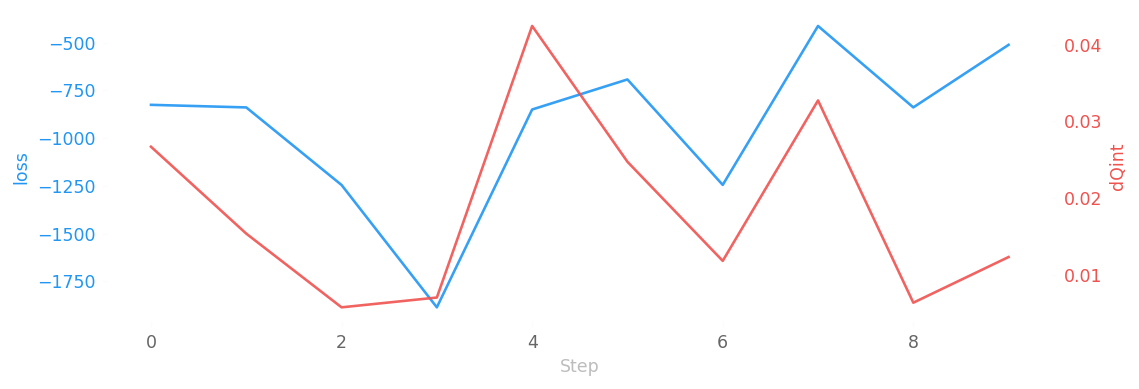

eval:   0%|          | 0/10 [00:00<?, ?it/s]

[19:01:20] INFO     estep=0   dt=0.7576 beta=6.0000 loss=-825.2705 dQsin=0.0009 dQint=0.0267 energy=-10733.1922         
                    logprob=-119156.4333 logdet=108423.2411 sldf=147455.2317 sldb=0.7380 sld=108423.2411 xeps=0.0100    
                    veps=0.0100 acc=1.0000 sumlogdet=147455.9697 acc_mask=1.0000 plaqs=0.5893 sinQ=-0.0002 intQ=-0.0059

<Figure size 1125x375 with 2 Axes>

[19:01:21] INFO     estep=1   dt=1.0420 beta=6.0000 loss=-838.8757 dQsin=0.0005 dQint=0.0153 energy=-10873.1351         
                    logprob=-119296.4221 logdet=108423.2870 sldf=147455.3249 sldb=0.6446 sld=108423.2870 xeps=0.0100    
                    veps=0.0100 acc=1.0000 sumlogdet=147455.9696 acc_mask=1.0000 plaqs=0.5878 sinQ=-0.0011 intQ=-0.0325

<Figure size 1125x375 with 2 Axes>

[19:01:22] INFO     estep=2   dt=0.7863 beta=6.0000 loss=-1245.5091 dQsin=0.0002 dQint=0.0057 energy=-10831.3942        
                    logprob=-119254.7005 logdet=108423.3063 sldf=147455.3124 sldb=0.6869 sld=108423.3063 xeps=0.0100    
                    veps=0.0100 acc=1.0000 sumlogdet=147455.9993 acc_mask=1.0000 plaqs=0.5881 sinQ=-0.0016 intQ=-0.0479

<Figure size 1125x375 with 2 Axes>

[19:01:23] INFO     estep=3   dt=0.7791 beta=6.0000 loss=-1886.9748 dQsin=0.0002 dQint=0.0070 energy=-11014.2064        
                    logprob=-119437.5022 logdet=108423.2958 sldf=147455.3279 sldb=0.6240 sld=108423.2958 xeps=0.0100    
                    veps=0.0100 acc=1.0000 sumlogdet=147455.9519 acc_mask=1.0000 plaqs=0.5918 sinQ=-0.0014 intQ=-0.0422

<Figure size 1125x375 with 2 Axes>

[19:01:24] INFO     estep=4   dt=0.7788 beta=6.0000 loss=-849.7470 dQsin=0.0015 dQint=0.0424 energy=-10919.8366         
                    logprob=-119343.1540 logdet=108423.3174 sldf=147455.3070 sldb=0.7341 sld=108423.3174 xeps=0.0100    
                    veps=0.0100 acc=1.0000 sumlogdet=147456.0411 acc_mask=1.0000 plaqs=0.5940 sinQ=-0.0016 intQ=-0.0470

<Figure size 1125x375 with 2 Axes>

[19:01:25] INFO     estep=5   dt=0.7777 beta=6.0000 loss=-692.2120 dQsin=0.0008 dQint=0.0247 energy=-10932.9766         
                    logprob=-119356.2359 logdet=108423.2592 sldf=147455.2669 sldb=0.6208 sld=108423.2592 xeps=0.0100    
                    veps=0.0100 acc=1.0000 sumlogdet=147455.8877 acc_mask=1.0000 plaqs=0.5947 sinQ=-0.0002 intQ=-0.0046

<Figure size 1125x375 with 2 Axes>

[19:01:26] INFO     estep=6   dt=0.7772 beta=6.0000 loss=-1245.0390 dQsin=0.0004 dQint=0.0118 energy=-10933.2885        
                    logprob=-119356.6365 logdet=108423.3480 sldf=147455.3951 sldb=0.5127 sld=108423.3480 xeps=0.0100    
                    veps=0.0100 acc=1.0000 sumlogdet=147455.9078 acc_mask=1.0000 plaqs=0.5944 sinQ=0.0007 intQ=0.0202

<Figure size 1125x375 with 2 Axes>

[19:01:27] INFO     estep=7   dt=0.7808 beta=6.0000 loss=-411.9079 dQsin=0.0011 dQint=0.0327 energy=-10911.0666         
                    logprob=-119334.5509 logdet=108423.4843 sldf=147455.5888 sldb=0.4718 sld=108423.4843 xeps=0.0100    
                    veps=0.0100 acc=1.0000 sumlogdet=147456.0605 acc_mask=1.0000 plaqs=0.5936 sinQ=0.0011 intQ=0.0320

<Figure size 1125x375 with 2 Axes>

[19:01:28] INFO     estep=8   dt=0.7719 beta=6.0000 loss=-838.7317 dQsin=0.0002 dQint=0.0063 energy=-10904.5754         
                    logprob=-119328.0299 logdet=108423.4545 sldf=147455.5539 sldb=0.4689 sld=108423.4545 xeps=0.0100    
                    veps=0.0100 acc=1.0000 sumlogdet=147456.0228 acc_mask=1.0000 plaqs=0.5914 sinQ=-0.0000 intQ=-0.0008

<Figure size 1125x375 with 2 Axes>

[19:01:29] INFO     estep=9   dt=0.7690 beta=6.0000 loss=-510.6867 dQsin=0.0004 dQint=0.0123 energy=-10866.5853         
                    logprob=-119290.0200 logdet=108423.4347 sldf=147455.4617 sldb=0.6201 sld=108423.4347 xeps=0.0100    
                    veps=0.0100 acc=1.0000 sumlogdet=147456.0818 acc_mask=1.0000 plaqs=0.5937 sinQ=0.0000 intQ=0.0013

<Figure size 1125x375 with 2 Axes>

[19:01:31] WARNING  Saving figure to: /lus/grand/projects/DLHMC/foremans/locations/thetaGPU/projects/l2hmc-qcd/src/l2hmc
                    /notebooks/outputs/2023-01-26-193137/pytorch/eval/plots/ridgeplots/svgs/energy_ridgeplot.svg

[19:01:32] INFO     Ridgeplot for energy took 2.456s

[19:01:34] WARNING  Saving figure to: /lus/grand/projects/DLHMC/foremans/locations/thetaGPU/projects/l2hmc-qcd/src/l2hmc
                    /notebooks/outputs/2023-01-26-193137/pytorch/eval/plots/ridgeplots/svgs/logprob_ridgeplot.svg

           INFO     Ridgeplot for logprob took 2.166s

[19:01:36] WARNING  Saving figure to: /lus/grand/projects/DLHMC/foremans/locations/thetaGPU/projects/l2hmc-qcd/src/l2hmc
                    /notebooks/outputs/2023-01-26-193137/pytorch/eval/plots/ridgeplots/svgs/logdet_ridgeplot.svg

           INFO     Ridgeplot for logdet took 2.084s

[19:01:38] WARNING  Saving figure to: /lus/grand/projects/DLHMC/foremans/locations/thetaGPU/projects/l2hmc-qcd/src/l2hmc
                    /notebooks/outputs/2023-01-26-193137/pytorch/eval/plots/ridgeplots/svgs/sldf_ridgeplot.svg

[19:01:39] INFO     Ridgeplot for sldf took 2.146s

[19:01:40] WARNING  Saving figure to: /lus/grand/projects/DLHMC/foremans/locations/thetaGPU/projects/l2hmc-qcd/src/l2hmc
                    /notebooks/outputs/2023-01-26-193137/pytorch/eval/plots/ridgeplots/svgs/sldb_ridgeplot.svg

[19:01:41] INFO     Ridgeplot for sldb took 2.154s

[19:01:42] WARNING  Saving figure to: /lus/grand/projects/DLHMC/foremans/locations/thetaGPU/projects/l2hmc-qcd/src/l2hmc
                    /notebooks/outputs/2023-01-26-193137/pytorch/eval/plots/ridgeplots/svgs/sld_ridgeplot.svg

[19:01:43] INFO     Ridgeplot for sld took 2.163s

[19:01:53] INFO     Saving dataset to: /lus/grand/projects/DLHMC/foremans/locations/thetaGPU/projects/l2hmc-qcd/src/l2hm
                    c/notebooks/outputs/2023-01-26-193137/pytorch/eval/data/eval_data.h5

           INFO     Done saving and analyzing data.

           INFO     Creating summaries for WandB, Aim

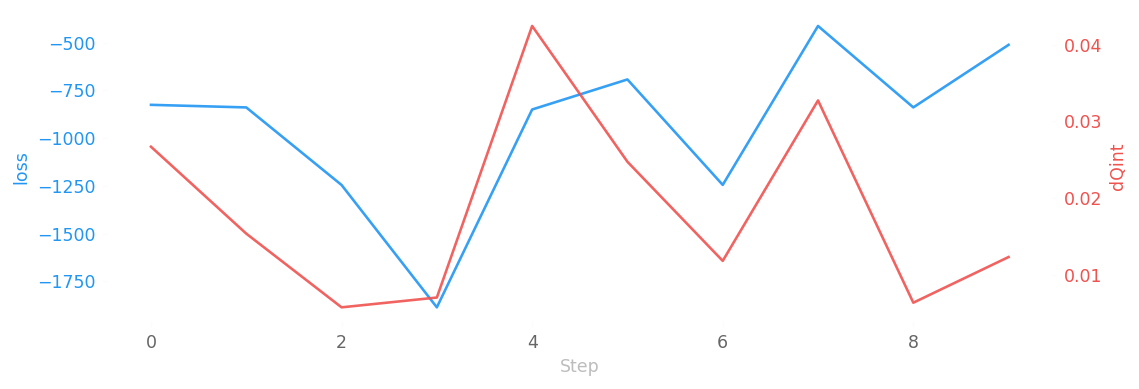

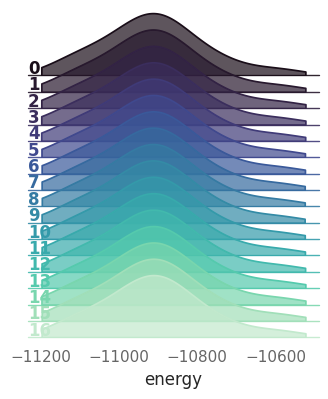

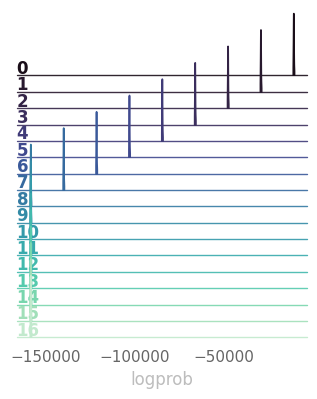

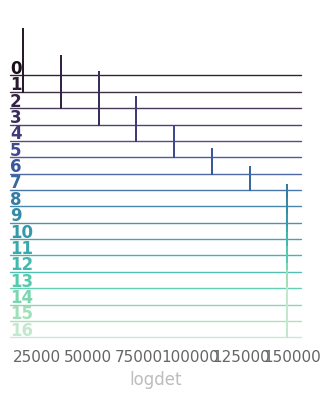

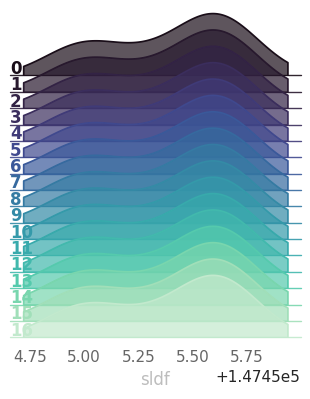

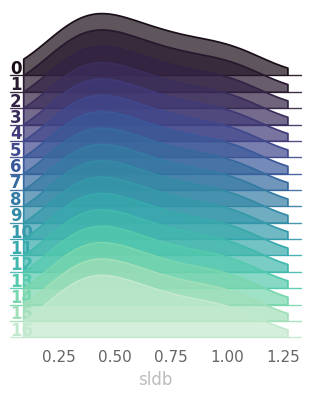

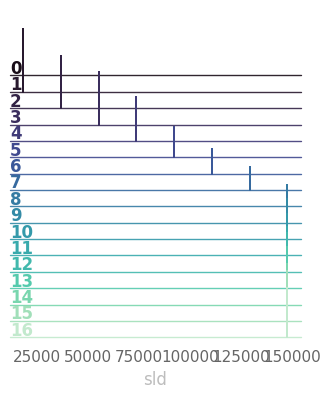

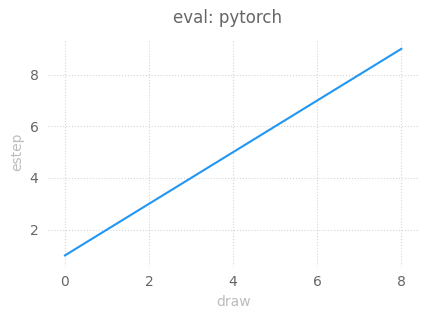

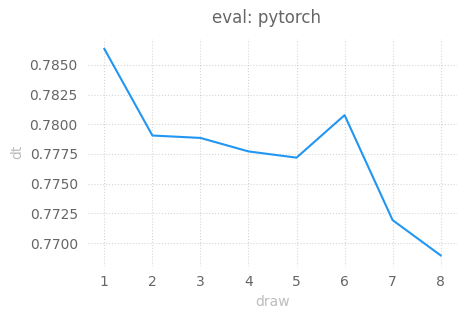

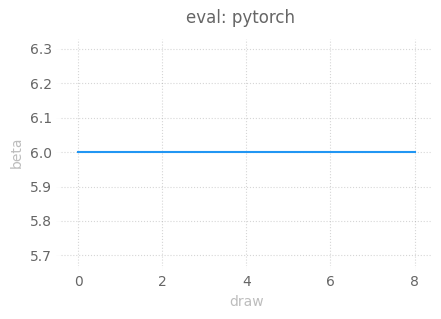

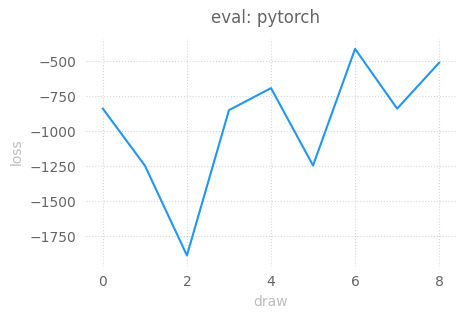

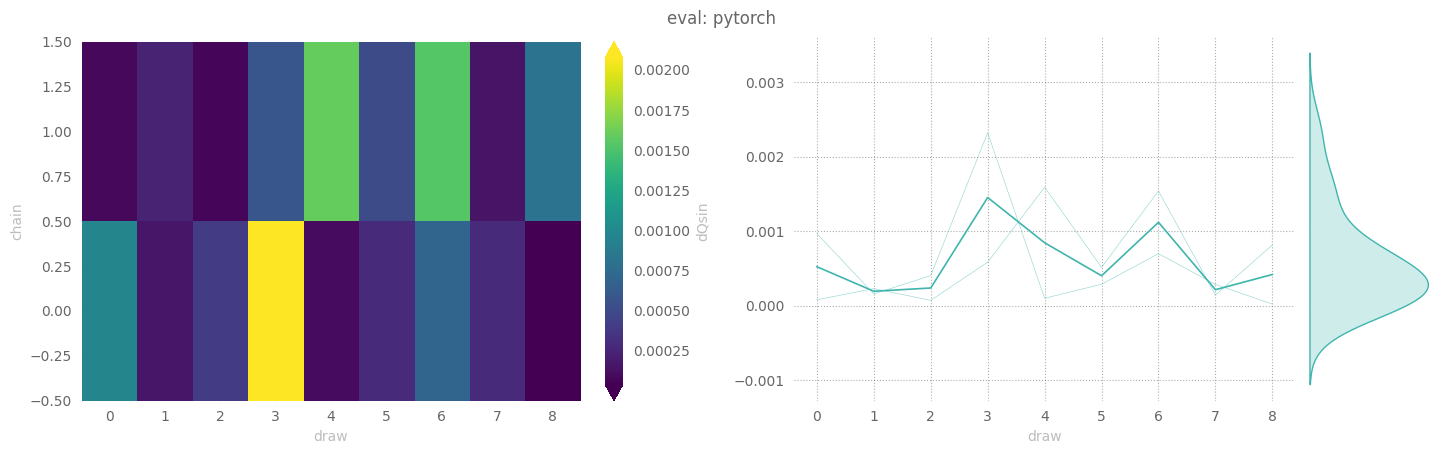

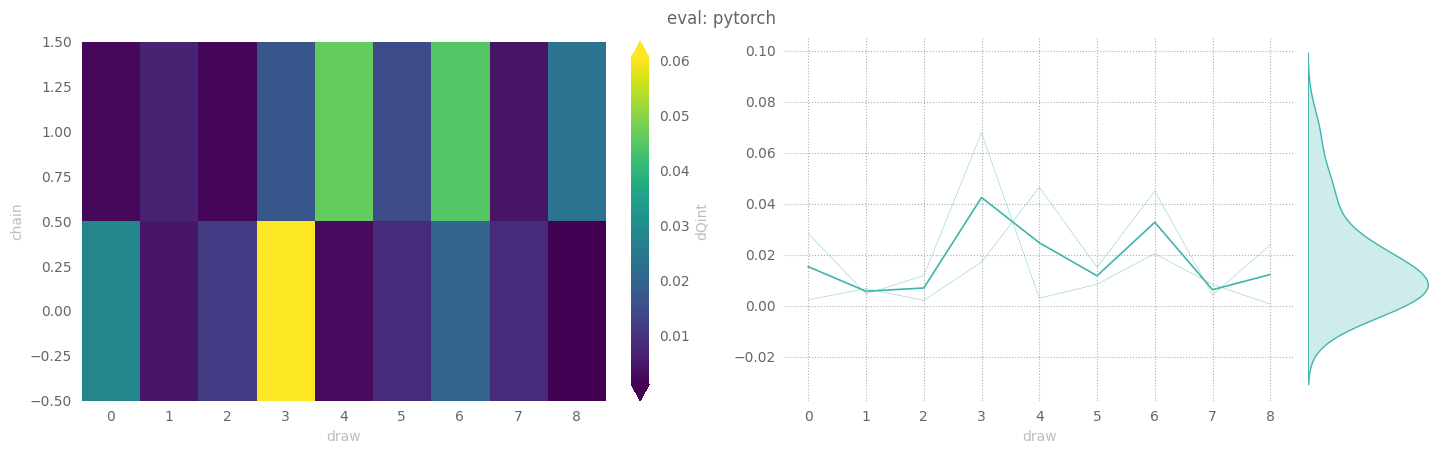

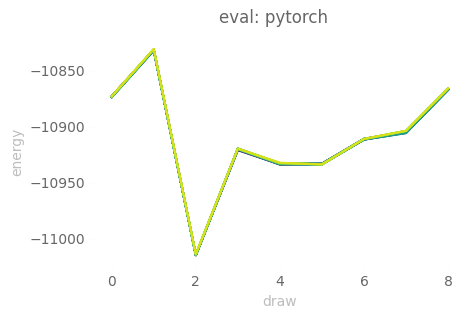

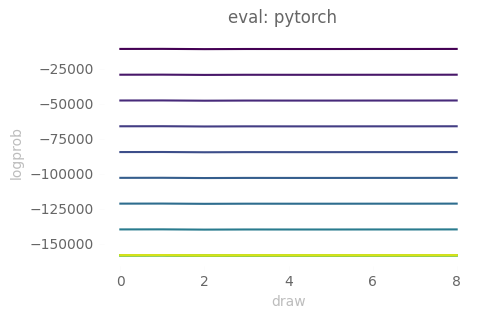

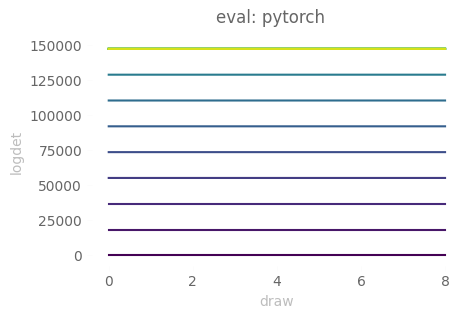

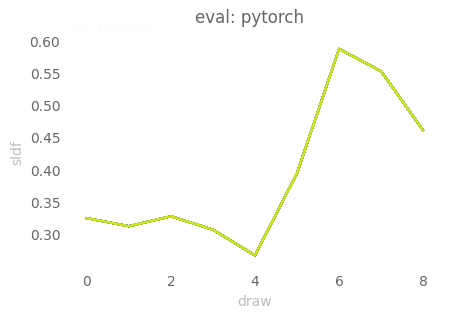

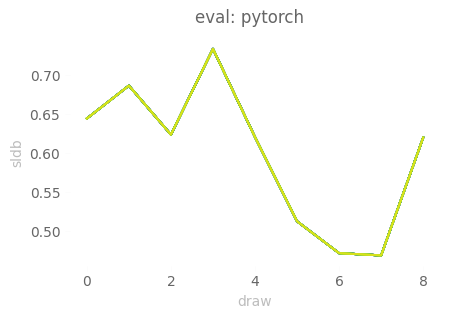

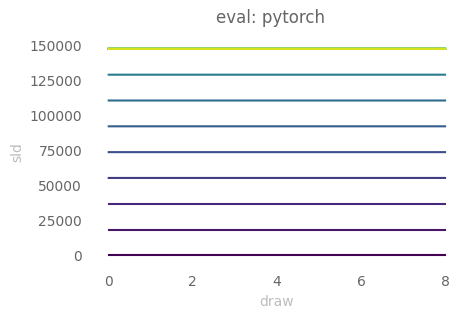

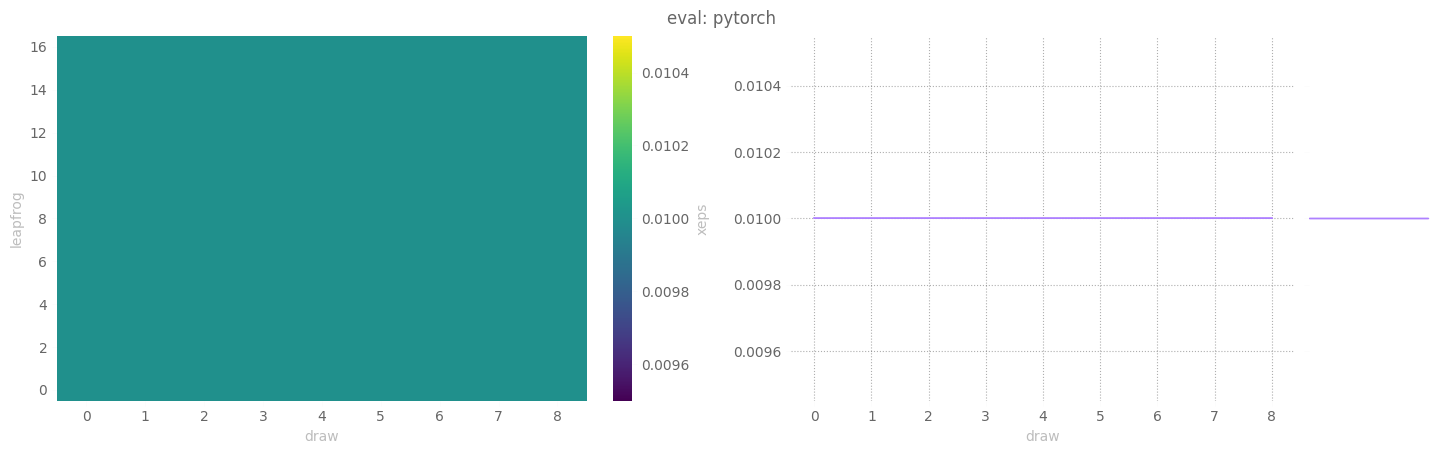

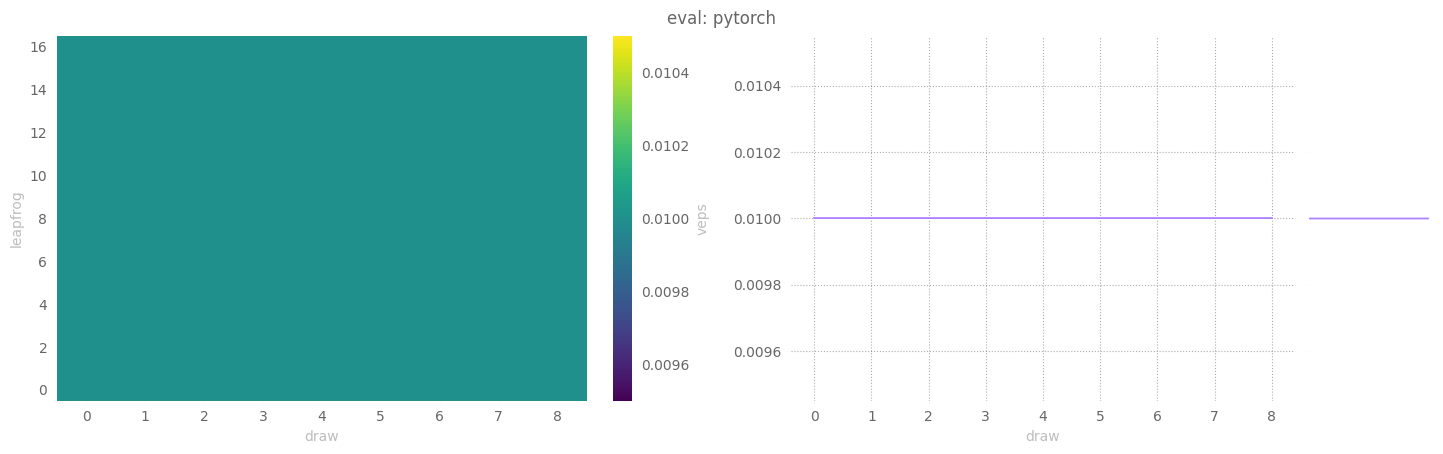

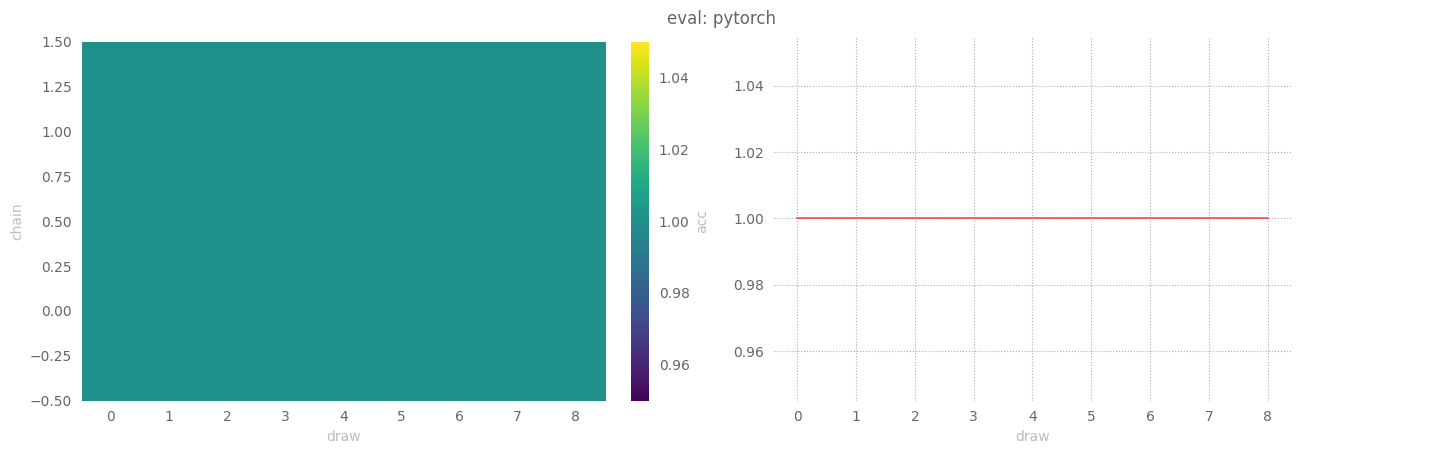

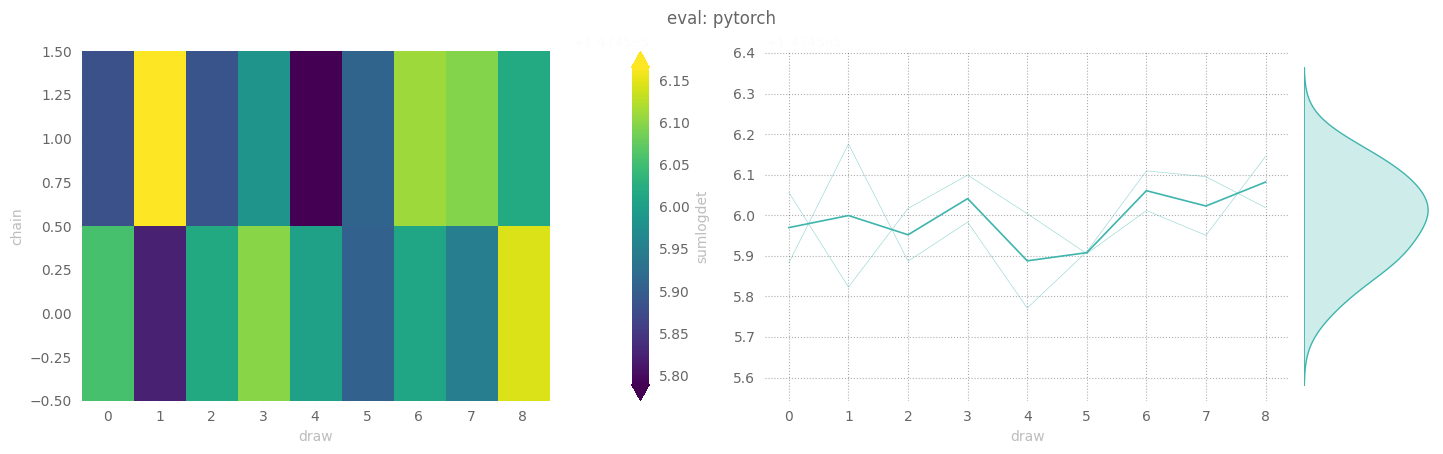

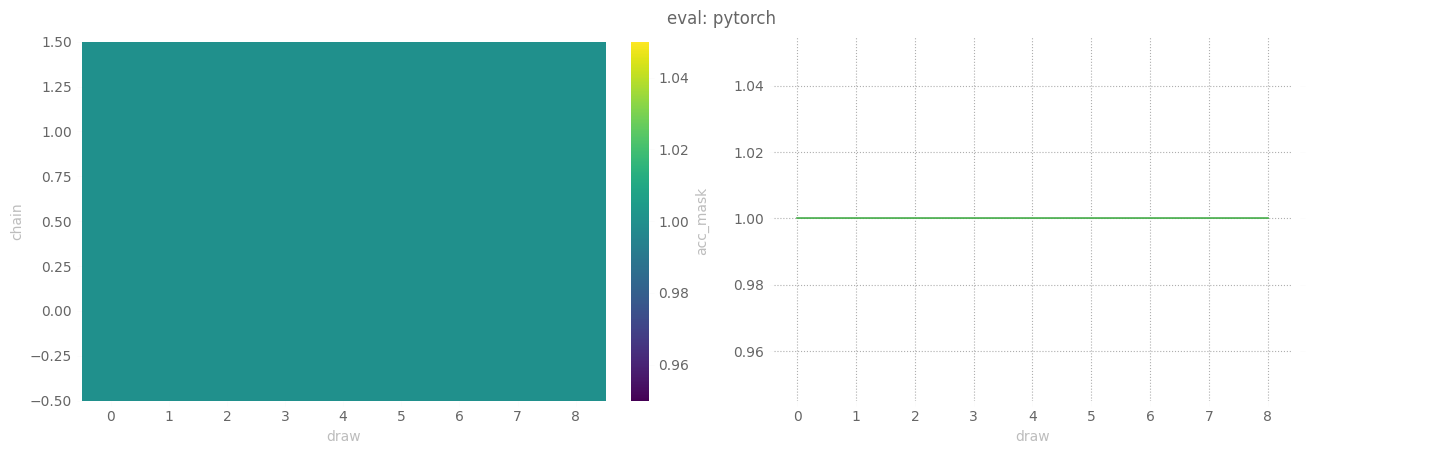

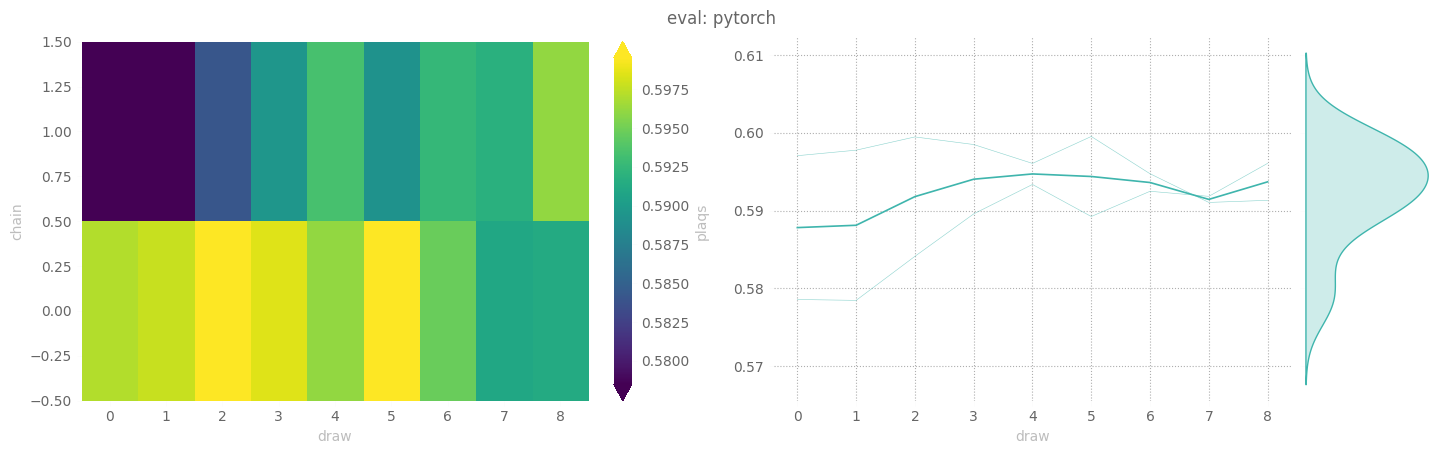

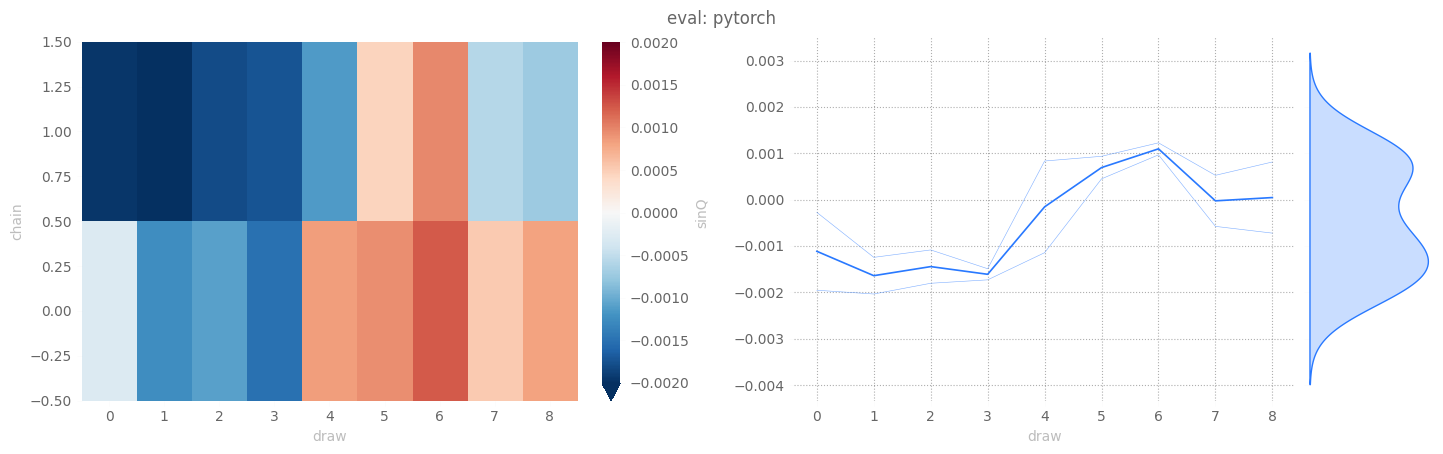

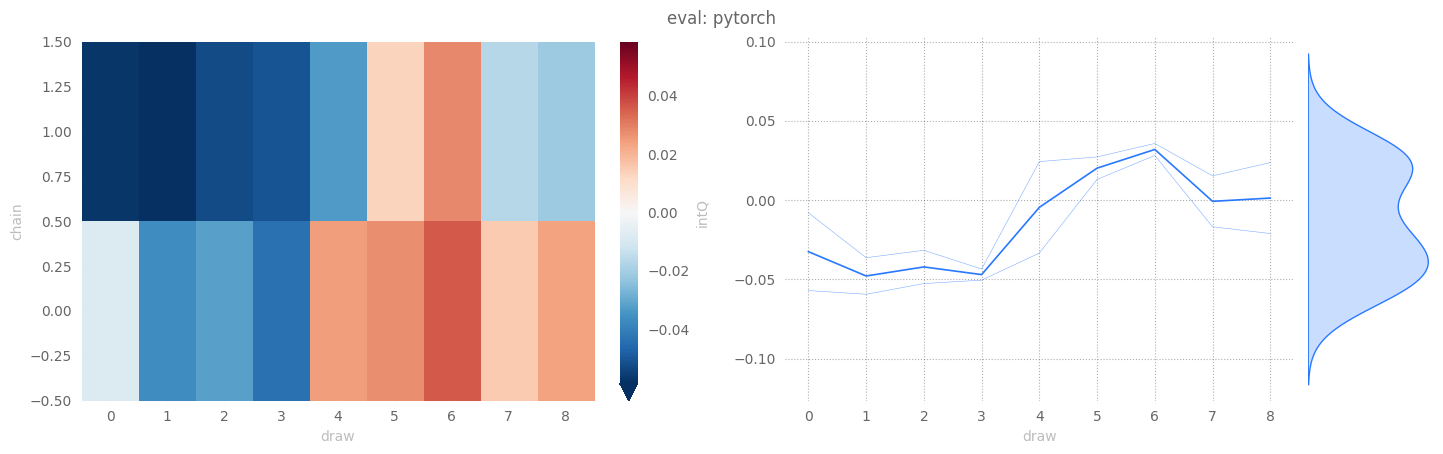

In [13]:
%matplotlib widget
from l2hmc.utils.plot_helpers import set_plot_style

set_plot_style()

eval_out = ptExpSU3.evaluate(
    job_type='eval',
    beta=6.0,
    eval_steps=10,
    nprint=1,
)

## Generic HMC

[19:01:08] WARNING  Step size `eps` not specified for HMC! Using default: 0.1250 for generic HMC

           WARNING  x.shape (original): torch.Size([2, 4, 4, 4, 4, 8, 3, 3])

           INFO     eps=0.125                                                                                           
                    beta=6.0                                                                                            
                    nlog=1                                                                                              
                    table=<rich.table.Table object at 0x7f7a802790a0>                                                   
                    nprint=1                                                                                            
                    eval_steps=10                                                                                       
                    nleapfrog=16

<Figure size 1125x375 with 2 Axes>

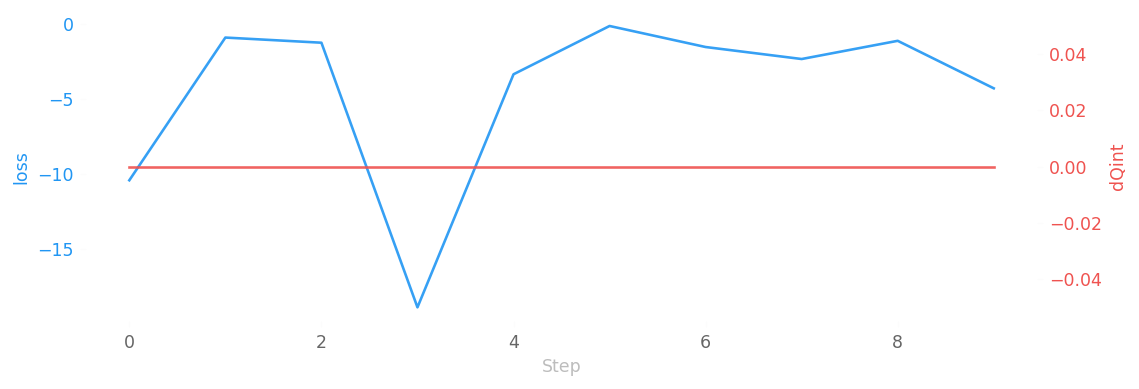

hmc:   0%|          | 0/10 [00:00<?, ?it/s]

[19:01:06] INFO     hstep=0   dt=0.5566 beta=6.0000 loss=-10.4042 dQsin=0.0000 dQint=0.0000 energy=-10979.8547          
                    logprob=-10979.8547 logdet=0.0000 acc=0.0043 sumlogdet=0.0000 acc_mask=0.0000 plaqs=0.5946          
                    sinQ=0.0011 intQ=0.0324

<Figure size 1125x375 with 2 Axes>

[19:01:07] INFO     hstep=1   dt=0.5602 beta=6.0000 loss=-0.8950 dQsin=0.0000 dQint=0.0000 energy=-10888.6830           
                    logprob=-10888.6830 logdet=0.0000 acc=0.0002 sumlogdet=0.0000 acc_mask=0.0000 plaqs=0.5946          
                    sinQ=0.0011 intQ=0.0324

<Figure size 1125x375 with 2 Axes>

[19:01:08] INFO     hstep=2   dt=0.5624 beta=6.0000 loss=-1.2382 dQsin=0.0000 dQint=0.0000 energy=-10922.8406           
                    logprob=-10922.8406 logdet=0.0000 acc=0.0003 sumlogdet=0.0000 acc_mask=0.0000 plaqs=0.5946          
                    sinQ=0.0011 intQ=0.0324

<Figure size 1125x375 with 2 Axes>

[19:01:09] INFO     hstep=3   dt=0.5606 beta=6.0000 loss=-18.8702 dQsin=0.0000 dQint=0.0000 energy=-10948.7440          
                    logprob=-10948.7440 logdet=0.0000 acc=0.0077 sumlogdet=0.0000 acc_mask=0.0000 plaqs=0.5946          
                    sinQ=0.0011 intQ=0.0324

<Figure size 1125x375 with 2 Axes>

           INFO     hstep=4   dt=0.5586 beta=6.0000 loss=-3.3422 dQsin=0.0000 dQint=0.0000 energy=-10989.1350           
                    logprob=-10989.1350 logdet=0.0000 acc=0.0023 sumlogdet=0.0000 acc_mask=0.0000 plaqs=0.5946          
                    sinQ=0.0011 intQ=0.0324

<Figure size 1125x375 with 2 Axes>

[19:01:10] INFO     hstep=5   dt=0.5621 beta=6.0000 loss=-0.1236 dQsin=0.0000 dQint=0.0000 energy=-10876.9312           
                    logprob=-10876.9312 logdet=0.0000 acc=0.0000 sumlogdet=0.0000 acc_mask=0.0000 plaqs=0.5946          
                    sinQ=0.0011 intQ=0.0324

<Figure size 1125x375 with 2 Axes>

[19:01:11] INFO     hstep=6   dt=0.5721 beta=6.0000 loss=-1.5252 dQsin=0.0000 dQint=0.0000 energy=-10903.7214           
                    logprob=-10903.7214 logdet=0.0000 acc=0.0008 sumlogdet=0.0000 acc_mask=0.0000 plaqs=0.5946          
                    sinQ=0.0011 intQ=0.0324

<Figure size 1125x375 with 2 Axes>

[19:01:12] INFO     hstep=7   dt=0.5640 beta=6.0000 loss=-2.3249 dQsin=0.0000 dQint=0.0000 energy=-10883.3366           
                    logprob=-10883.3366 logdet=0.0000 acc=0.0005 sumlogdet=0.0000 acc_mask=0.0000 plaqs=0.5946          
                    sinQ=0.0011 intQ=0.0324

<Figure size 1125x375 with 2 Axes>

[19:01:13] INFO     hstep=8   dt=0.5666 beta=6.0000 loss=-1.1123 dQsin=0.0000 dQint=0.0000 energy=-10896.8525           
                    logprob=-10896.8525 logdet=0.0000 acc=0.0002 sumlogdet=0.0000 acc_mask=0.0000 plaqs=0.5946          
                    sinQ=0.0011 intQ=0.0324

<Figure size 1125x375 with 2 Axes>

           INFO     hstep=9   dt=0.5627 beta=6.0000 loss=-4.2768 dQsin=0.0000 dQint=0.0000 energy=-10935.4142           
                    logprob=-10935.4142 logdet=0.0000 acc=0.0020 sumlogdet=0.0000 acc_mask=0.0000 plaqs=0.5946          
                    sinQ=0.0011 intQ=0.0324

<Figure size 1125x375 with 2 Axes>

[19:01:15] WARNING  Saving figure to: /lus/grand/projects/DLHMC/foremans/locations/thetaGPU/projects/l2hmc-qcd/src/l2hmc
                    /notebooks/outputs/2023-01-26-193137/pytorch/hmc/plots/ridgeplots/svgs/energy_ridgeplot.svg

[19:01:16] INFO     Ridgeplot for energy took 2.118s

[19:01:17] WARNING  Saving figure to: /lus/grand/projects/DLHMC/foremans/locations/thetaGPU/projects/l2hmc-qcd/src/l2hmc
                    /notebooks/outputs/2023-01-26-193137/pytorch/hmc/plots/ridgeplots/svgs/logprob_ridgeplot.svg

[19:01:18] INFO     Ridgeplot for logprob took 2.141s

[19:01:19] WARNING  Saving figure to: /lus/grand/projects/DLHMC/foremans/locations/thetaGPU/projects/l2hmc-qcd/src/l2hmc
                    /notebooks/outputs/2023-01-26-193137/pytorch/hmc/plots/ridgeplots/svgs/logdet_ridgeplot.svg

[19:01:20] INFO     Ridgeplot for logdet took 2.136s

[19:01:28] INFO     Saving dataset to: /lus/grand/projects/DLHMC/foremans/locations/thetaGPU/projects/l2hmc-qcd/src/l2hm
                    c/notebooks/outputs/2023-01-26-193137/pytorch/hmc/data/hmc_data.h5

           INFO     Done saving and analyzing data.

           INFO     Creating summaries for WandB, Aim

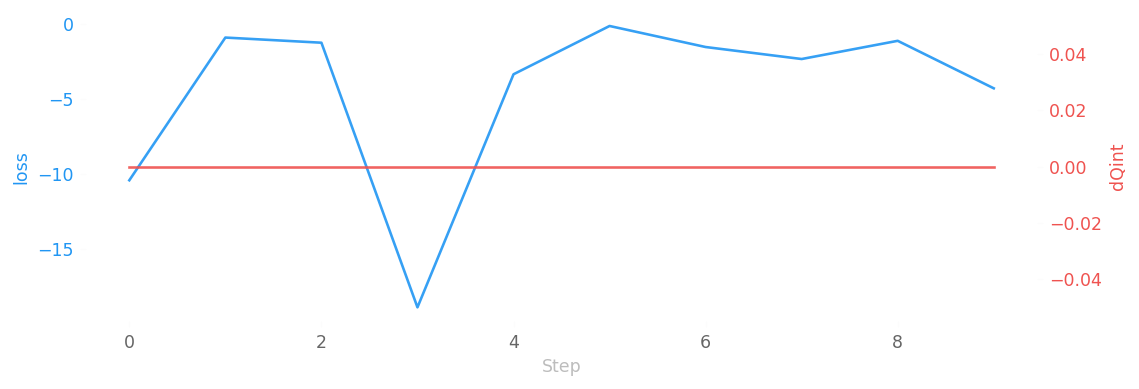

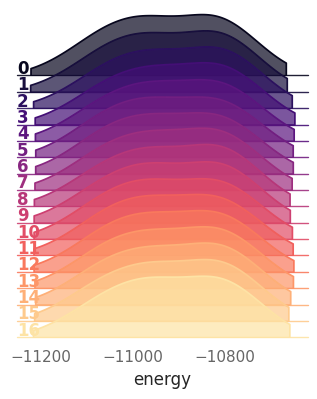

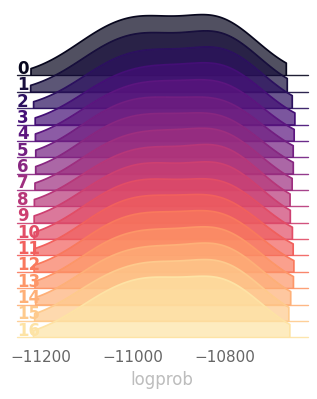

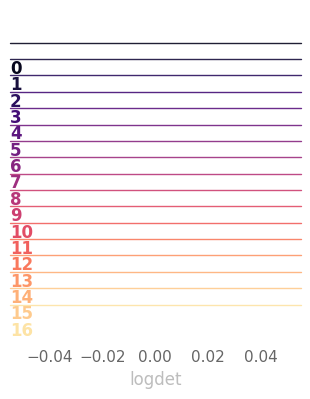

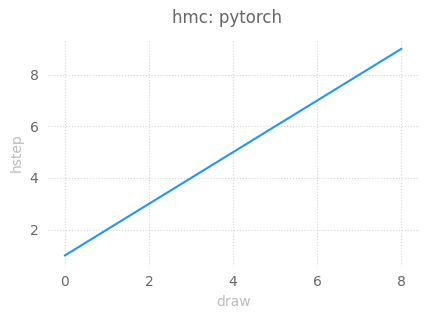

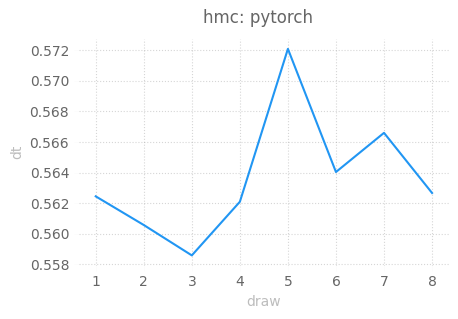

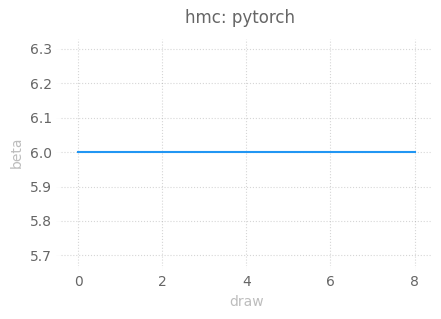

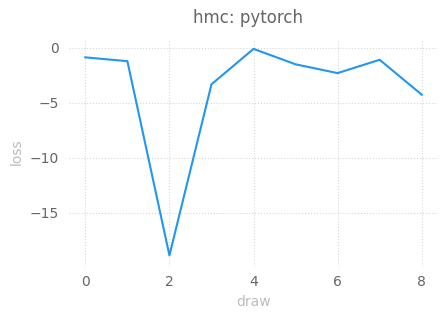

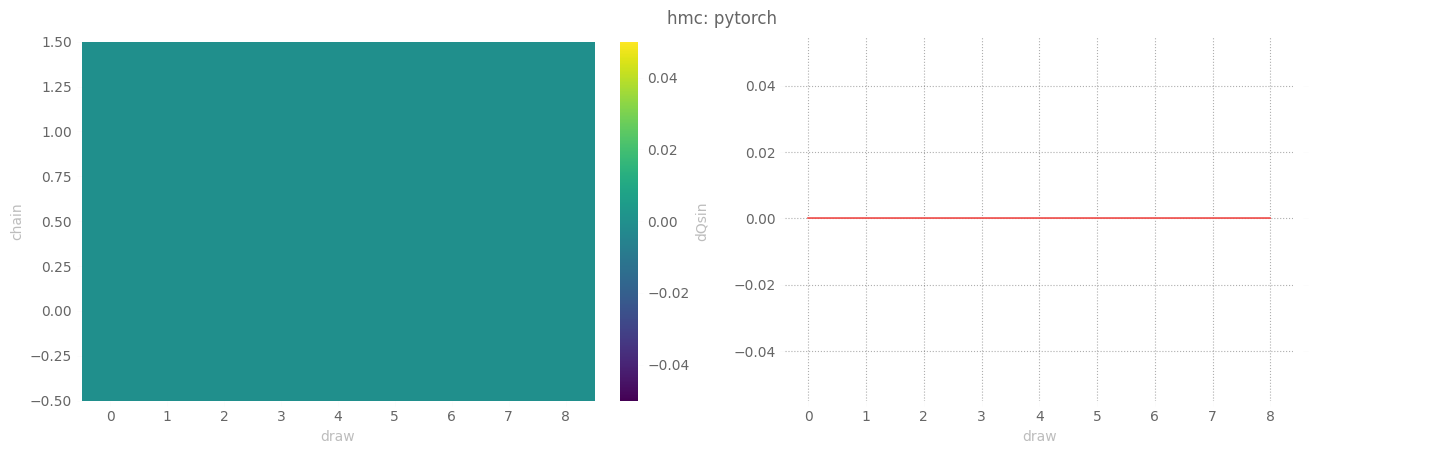

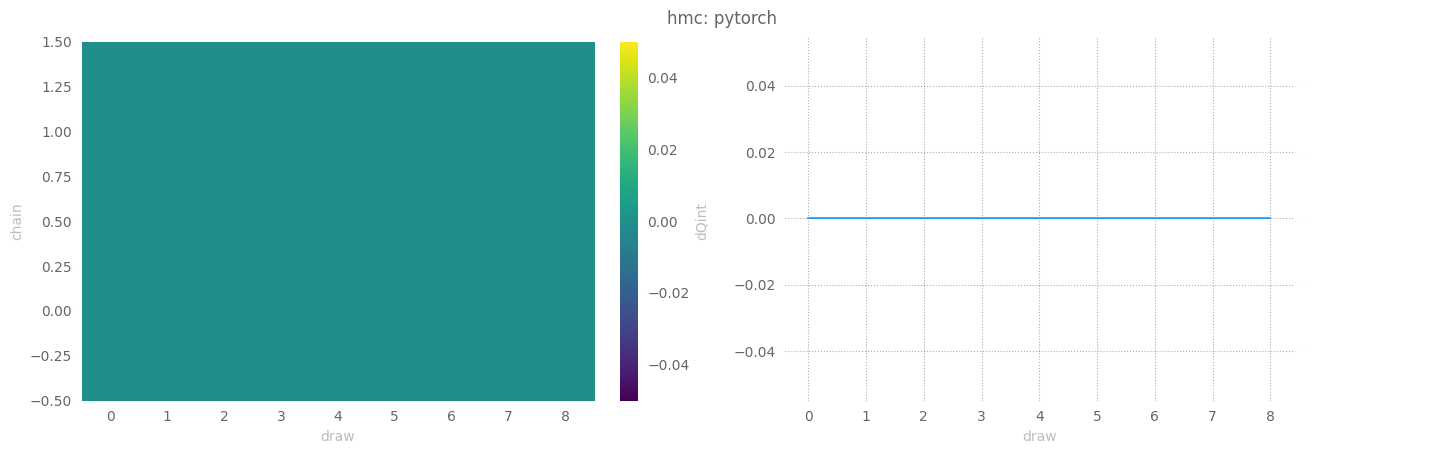

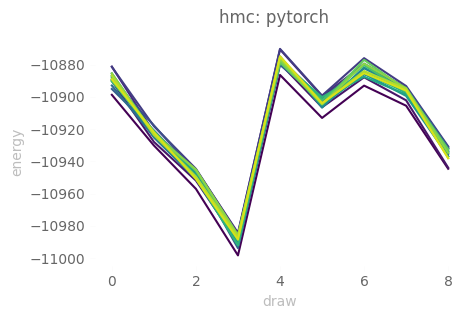

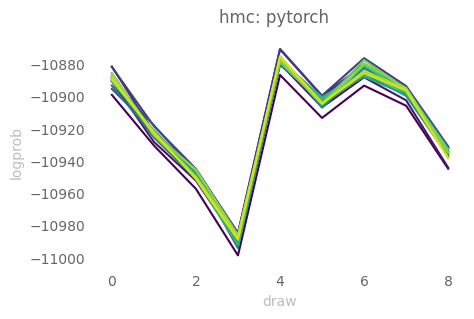

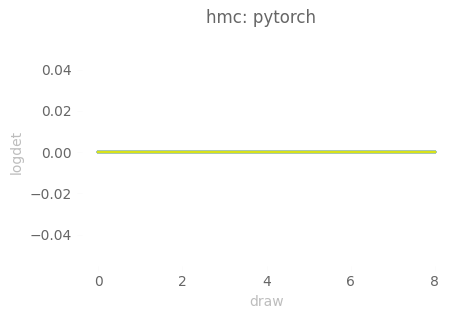

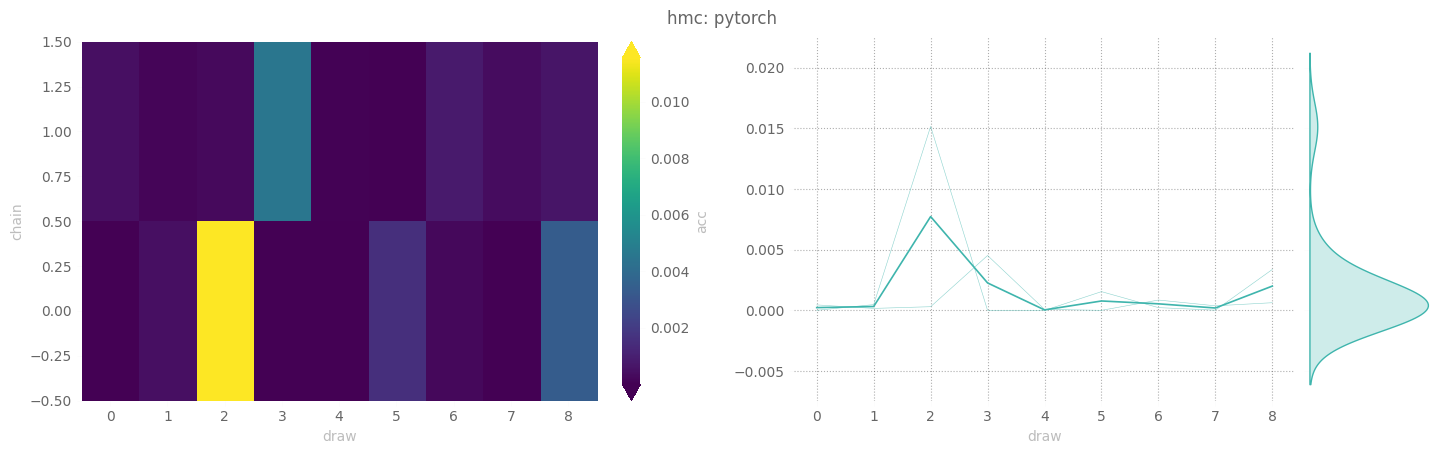

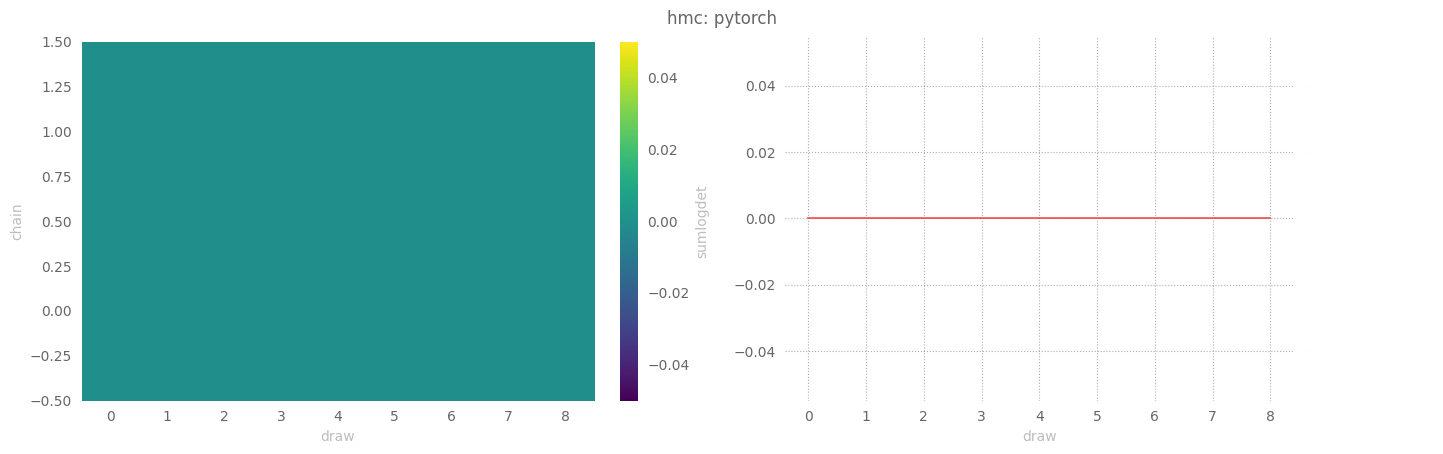

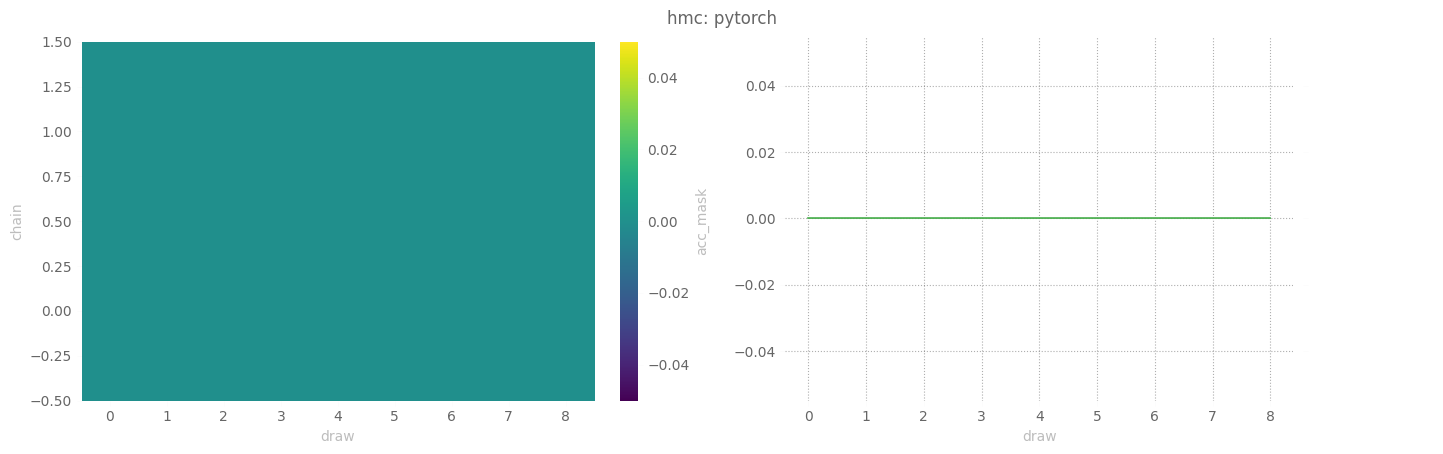

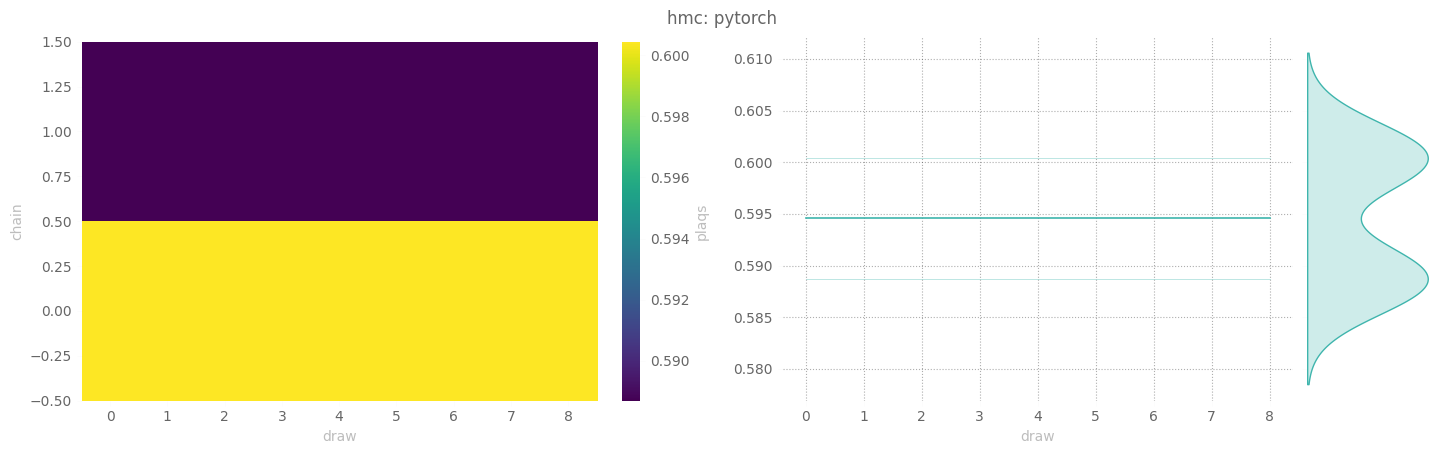

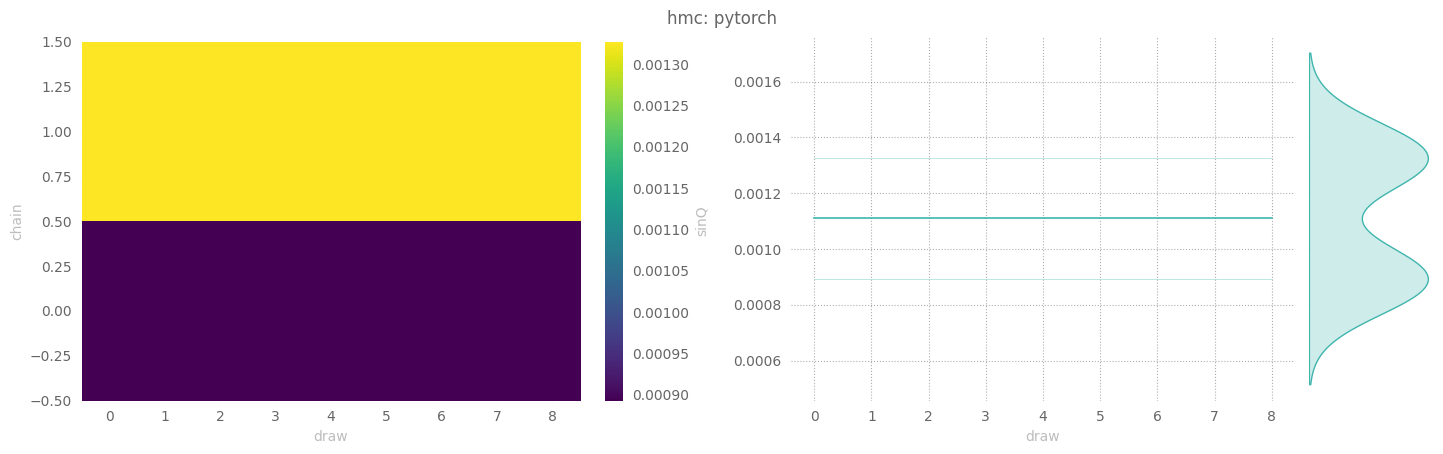

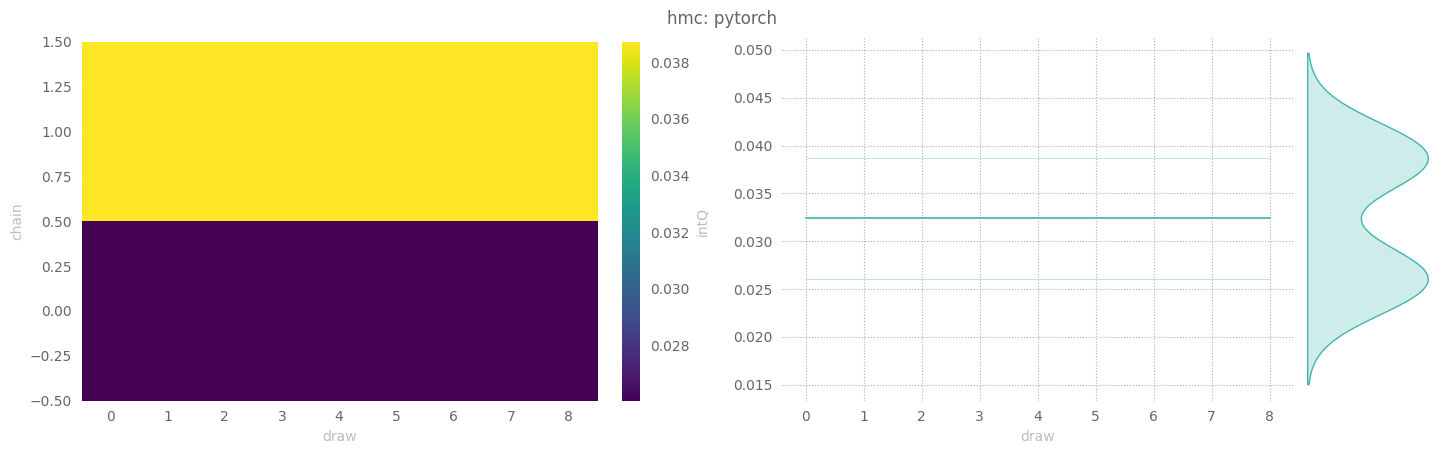

In [14]:
hmc_out = ptExpSU3.evaluate(
    job_type='hmc',
    beta=6.0,
    eval_steps=10,
    nprint=1,
)

## $x$-update

In [196]:
step = 0
state = dynamics.random_state(1.0)

eps = dynamics.veps[step]
force = dynamics.grad_potential(state.x, state.beta)
force = force.reshape_as(state.v)
# x = dynamics.g.compat_proj(state.x)
x = state.x
v = state.v
# if isinstance(dynamics.g, SU3):
if dynamics.config.group == 'SU3':
    x = dynamics.group_to_vec(state.x)
    v = dynamics.group_to_vec(state.v)
    force = dynamics.group_to_vec(force)

s, t, q = dynamics._call_vnet(step, (x, force))

logjac = eps * s / 2.  # jacobian factor, also used in exp_s below
logdet = dynamics.flatten(logjac).sum(1)

# if isinstance(dynamics.g, SU3):
if dynamics.config.group == 'SU3':
    exps_ = dynamics.g.exp(logjac.reshape_as(state.x))
    expt_ = dynamics.g.exp(t.reshape_as(state.x))
    expq_ = dynamics.g.exp(q.reshape_as(state.x))
    z = torch.zeros_like(exps_)
    exp_s = dynamics.group_to_vec(torch.complex(exps_, z))
    t = dynamics.group_to_vec(torch.complex(expt_, z))
    exp_q = dynamics.group_to_vec(torch.complex(expq_, z))
elif isinstance(dynamics.g, U1Phase):
    # logdet = logjac.flatten(1).sum(dim=1)
    exp_s = logjac.exp()  # .reshape_as(state.v)
    exp_q = (eps * q).exp()  # .reshape_as(force)
else:
    raise TypeError
    # t = t.reshape_as(force)

vf = exp_s * v - 0.5 * eps * (force * exp_q + t)
# if isinstance(dynamics.g, SU3):
if dynamics.config.group == 'SU3':
    vf = dynamics.g.projectTAH(
        dynamics.g.vec_to_group(vf)
    )

In [197]:
vnet = dynamics._get_vnet(0)


In [198]:
vnet

LeapfrogLayer(
  (activation_fn): Tanh()
  (input_layer): InputLayer(
    (activation_fn): Tanh()
    (conv_stack): Identity()
    (xlayer): Linear(in_features=512, out_features=64, bias=True)
    (vlayer): Linear(in_features=512, out_features=64, bias=True)
  )
  (hidden_layers): ModuleList(
    (0): Linear(in_features=64, out_features=128, bias=True)
  )
  (scale): ScaledTanh(
    (layer): Linear(in_features=128, out_features=576, bias=False)
    (tanh): Tanh()
  )
  (transf): ScaledTanh(
    (layer): Linear(in_features=128, out_features=576, bias=False)
    (tanh): Tanh()
  )
  (transl): Linear(in_features=128, out_features=576, bias=True)
)

In [199]:
np.cumprod(x.shape[1:])[-1]

512

In [ ]:
tra
i

In [187]:
vnet.xshape

(1, 4, 2, 2, 2, 2, 3, 3)

In [190]:
xshape = dynamics.config.xshape
gdim = np.cumprod(xshape[1:-2])[-1] * 8
_ = ic(gdim)

ic| gdim: 512


In [161]:
init_all(vnet,
         init_func=lambda x: torch.nn.init.uniform(x, 0.0))

In [170]:
vnet.input_layer.xlayer.weight.shape[-1]

512

In [163]:
x_ = x.flatten(1)
force_ = force.flatten(1)
z = vnet.input_layer((x_, force_))

In [164]:
houtputs = []
for layer in vnet.hidden_layers:
    q = layer(z)
    houtputs.append(q)

In [165]:
scale = vnet.scale(q)
transf = vnet.transf(q)
t = vnet.transl(q)

In [166]:
scale.sum()
transf.sum()
t.sum()

tensor(-1036098.8016, device='cuda:0', grad_fn=<SumBackward0>)

In [168]:
scale.shape

torch.Size([1, 576])

In [167]:
z.shape

torch.Size([1, 64])

In [117]:
torch.set_printoptions(precision=4, threshold=10, linewidth=120, profile='full')

In [118]:
vnet.input_layer.vlayer.weight

Parameter containing:
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0', requires_grad=True)

In [100]:
ic(z)

ic| z: tensor([[nan, nan, nan,  ..., nan, nan, nan]], device='cuda:0', grad_fn=<TanhBackward0>)


tensor([[nan, nan, nan,  ..., nan, nan, nan]], device='cuda:0', grad_fn=<TanhBackward0>)

In [93]:
vv1 = vnet.input_layer.vlayer(force)

╭──────────────────────────── Traceback (most recent call last) ────────────────────────────╮
│ /tmp/ipykernel_3326059/3468260759.py:1 in <module>                                        │
│                                                                                           │
│ [Errno 2] No such file or directory: '/tmp/ipykernel_3326059/3468260759.py'               │
│                                                                                           │
│ /lus/theta-fs0/software/thetagpu/conda/2022-07-01/mconda3/lib/python3.8/site-packages/tor │
│ ch/nn/modules/module.py:1130 in _call_impl                                                │
│                                                                                           │
│   1127 │   │   # this function, and just call forward.                                    │
│   1128 │   │   if not (self._backward_hooks or self._forward_hooks or self._forward_pre_h │
│   1129 │   │   │   │   or _global_forward_hooks or _global_forward_pre_hooks):            │
│ ❱ 1130 │   │   │   return forward_call(*input, **kwargs)                                  │
│   1131 │   │   # Do not call functions when jit is used                                   │
│   1132 │   │   full_backward_hooks, non_full_backward_hooks = [], []                      │
│   1133 │   │   if self._backward_hooks or _global_backward_hooks:                         │
│                                                                                           │
│ /lus/theta-fs0/software/thetagpu/conda/2022-07-01/mconda3/lib/python3.8/site-packages/tor │
│ ch/nn/modules/linear.py:114 in forward                                                    │
│                                                                                           │
│   111 │   │   │   init.uniform_(self.bias, -bound, bound)                                 │
│   112 │                                                                                   │
│   113 │   def forward(self, input: Tensor) -> Tensor:                                     │
│ ❱ 114 │   │   return F.linear(input, self.weight, self.bias)                              │
│   115 │                                                                                   │
│   116 │   def extra_repr(self) -> str:                                                    │
│   117 │   │   return 'in_features={}, out_features={}, bias={}'.format(                   │
╰───────────────────────────────────────────────────────────────────────────────────────────╯
RuntimeError: mat1 and mat2 shapes cannot be multiplied (64x8 and 512x64)

In [ ]:
iic

In [88]:
x.shape

torch.Size([1, 4, 2, 2, 2, 2, 8])

In [75]:
ic([ldvf, ldvb])

ic| [ldvf, ldvb]: [tensor([nan], device='cuda:0', grad_fn=<SumBackward1>),
                   tensor([nan], device='cuda:0', grad_fn=<SumBackward1>)]


[
    tensor([nan], device='cuda:0', grad_fn=<SumBackward1>),
    tensor([nan], device='cuda:0', grad_fn=<SumBackward1>)
]

In [70]:
m, mb = dynamics._get_mask(0)
m = m.to(state_pt.x.device)
mb = mb.to(state_pt.x.device)
state_xf0, ldxf0 = dynamics._update_x_fwd(0, state=state_pt, m=m, first=True)
state_xf1, ldxf1 = dynamics._update_x_fwd(0, state=state_pt, m=mb, first=False)

state_xb0, ldxb0 = dynamics._update_x_bwd(0, state=state_pt, m=m, first=True)
state_xb1, ldxb1 = dynamics._update_x_bwd(0, state=state_pt, m=mb, first=False)

In [73]:
state_xf0.v.sum()

tensor(8.88178e-16-3.53365j, device='cuda:0')

In [74]:
state_vf.v.sum()

tensor(nan+nanj, device='cuda:0', grad_fn=<SumBackward0>)

In [71]:
_ = ic([ldxf0, ldxf1, ldxb0, ldxb1])

ic| [ldxf0, ldxf1, ldxb0, ldxb1]: [tensor([nan], device='cuda:0', grad_fn=<SumBackward1>),
                                   tensor([nan], device='cuda:0', grad_fn=<SumBackward1>),
                                   tensor([nan], device='cuda:0', grad_fn=<SumBackward1>),
                                   tensor([nan], device='cuda:0', grad_fn=<SumBackward1>)]


In [116]:
_ = ic([
    state_pt.x.sum(),
    state_xf0.x.sum(),
    state_xf1.x.sum(),
    state_xb0.x.sum(),
    state_xb1.x.sum(),
])

ic| [
        state_pt.x.sum(),
        state_xf0.x.sum(),
        state_xf1.x.sum(),
        state_xb0.x.sum(),
        state_xb1.x.sum(),
    ]: [tensor(-7.62648-1.64572j, device='cuda:0', grad_fn=<SumBackward0>),
        tensor(10.62125+1.36070j, device='cuda:0', grad_fn=<SumBackward0>),
        tensor(12.46552+0.80705j, device='cuda:0', grad_fn=<SumBackward0>),
        tensor(10.62125+1.36070j, device='cuda:0', grad_fn=<SumBackward0>),
        tensor(12.46552+0.80705j, device='cuda:0', grad_fn=<SumBackward0>)]


In [179]:
mx = m * state.x
mc = torch.complex(m, torch.zeros_like(m))
x0 = m * dynamics.flatten(state.x)

In [48]:
step = 0
beta = 1.0
state = dynamics.random_state(beta=beta)

FIRST = True

m, mb = dynamics._get_mask(step)
m = m.to(state.x.device)
mb = mb.to(state.x.device)
eps = dynamics.xeps[step]
eps = eps.to(state.x.device)
#xflat = state.x.to(state.x.device)
x0 = dynamics.group_to_vec(
    dynamics.unflatten(
        m * dynamics.flatten(state.x)
    )
)
#xm_init = dynamics.group_to_vec(x0)
xnet = dynamics._get_xnet(step=step, first=FIRST)
#x0g = dynamics.group_to_vec(x0)
vg = dynamics.group_to_vec(state.v)
s, t, q = xnet((x0, vg))
#s, t, q = dynamics._call_xnet(
#    step=step,
#    inputs=(x0, state.v),
#    first=FIRST,
#)
s_ = (-eps) * s
q_ = (eps * q)
exp_s = s_.exp()
exp_q = q_.exp()

In [117]:
xflat = dynamics.flatten(state.x)
xzeros = torch.zeros_like(xflat)
mx = torch.where(
    m.to(torch.bool),
    xflat,
    xzeros
)
mx_ = dynamics.unflatten(mx)
xr_ = dynamics.group_to_vec(
    dynamics.unflatten(xflat)
)
v = dynamics.group_to_vec(state.v)
exp_s_ = exp_s.reshape_as(xr_)
exp_q_ = exp_q.reshape_as(xr_)
t_ = t.reshape_as(xr_)
xnew = exp_s_ * (xr_ - eps * (v * exp_q_ + t_))
xnew_ = xnew.reshape_as(xr_)
mbx_ = dynamics.unflatten(mb) * dynamics.g.vec_to_group(xnew_)
xb = mx_ + mbx_

logjac = torch.where(
    dynamics.unflatten(mb).to(torch.bool),
    dynamics.g.vec_to_group(exp_s_).log(),
    0.0
)
logdet = dynamics.flatten(gpt.norm2(logjac)).sum(1)
#logjac = (dynamics.unflatten(mb) * dynamics.g.vec_to_group(s))

In [131]:
logjac_ = dynamics.flatten(logjac)
logdet = (logjac_ @ logjac_.mH).det().log()
ic(logdet)

ic| logdet: tensor(7.13881+1.12173e-17j, device='cuda:0')


tensor(7.13881+1.12173e-17j, device='cuda:0')

gpt.norm2(logjac) - logjac.det().real

In [125]:
dynamics.flatten(logjac.det()).sum().abs()

tensor(201.28797, device='cuda:0')

In [50]:
gpt.checkSU(dynamics.g.compat_proj(state.x))

(
    tensor([2.54873e-16], device='cuda:0', grad_fn=<SqrtBackward0>),
    tensor([9.13467e-16], device='cuda:0', grad_fn=<SqrtBackward0>)
)

In [62]:
gpt.checkSU(dynamics.g.compat_proj(xb))

(
    tensor([5.67093e-16], device='cuda:0', grad_fn=<SqrtBackward0>),
    tensor([1.55334e-15], device='cuda:0', grad_fn=<SqrtBackward0>)
)

In [ ]:
mc.shape

torch.Size([1, 576])

In [ ]:
mc_ = dynamics.unflatten(mc)
mc_.shape

torch.Size([1, 4, 2, 2, 2, 2, 3, 3])

In [ ]:
mcg = dynamics.group_to_vec(mc_.to(torch.complex128))

In [ ]:
mcg.shape

torch.Size([1, 4, 2, 2, 2, 2, 8])

In [ ]:
mcg.flatten(1).shape[1]

512

In [143]:
mc

tensor([[0.+0.j, 1.+0.j, 1.+0.j,  ..., 1.+0.j, 1.+0.j, 1.+0.j]], device='cuda:0', dtype=torch.complex64)

In [144]:
mc.shape

torch.Size([1, 576])

In [145]:
mc_.shape

torch.Size([1, 4, 2, 2, 2, 2, 3, 3])

In [146]:
mc_

tensor([[[[[[[[0.+0.j, 1.+0.j, 1.+0.j],
              [0.+0.j, 0.+0.j, 0.+0.j],
              [0.+0.j, 0.+0.j, 0.+0.j]],

             [[0.+0.j, 1.+0.j, 0.+0.j],
              [0.+0.j, 0.+0.j, 1.+0.j],
              [0.+0.j, 1.+0.j, 0.+0.j]]],


            [[[1.+0.j, 0.+0.j, 1.+0.j],
              [0.+0.j, 1.+0.j, 0.+0.j],
              [0.+0.j, 1.+0.j, 1.+0.j]],

             [[0.+0.j, 1.+0.j, 0.+0.j],
              [1.+0.j, 0.+0.j, 0.+0.j],
              [0.+0.j, 1.+0.j, 1.+0.j]]]],



           [[[[0.+0.j, 0.+0.j, 1.+0.j],
              [0.+0.j, 0.+0.j, 1.+0.j],
              [1.+0.j, 0.+0.j, 0.+0.j]],

             [[1.+0.j, 1.+0.j, 1.+0.j],
              [0.+0.j, 0.+0.j, 0.+0.j],
              [1.+0.j, 1.+0.j, 1.+0.j]]],


            [[[1.+0.j, 1.+0.j, 1.+0.j],
              [1.+0.j, 1.+0.j, 1.+0.j],
              [0.+0.j, 1.+0.j, 1.+0.j]],

             [[0.+0.j, 1.+0.j, 0.+0.j],
              [0.+0.j, 1.+0.j, 1.+0.j],
              [0.+0.j, 0.+0.j, 0.+0.j]]]]],




          [[[[[0.+0.j, 0.+0.j, 1.+0.j],
              [0.+0.j, 1.+0.j, 1.+0.j],
              [1.+0.j, 1.+0.j, 0.+0.j]],

             [[0.+0.j, 0.+0.j, 0.+0.j],
              [1.+0.j, 1.+0.j, 1.+0.j],
              [1.+0.j, 1.+0.j, 0.+0.j]]],


            [[[1.+0.j, 0.+0.j, 1.+0.j],
              [0.+0.j, 1.+0.j, 1.+0.j],
              [1.+0.j, 0.+0.j, 0.+0.j]],

             [[0.+0.j, 0.+0.j, 1.+0.j],
              [1.+0.j, 0.+0.j, 0.+0.j],
              [0.+0.j, 1.+0.j, 1.+0.j]]]],



           [[[[1.+0.j, 1.+0.j, 1.+0.j],
              [0.+0.j, 1.+0.j, 1.+0.j],
              [1.+0.j, 1.+0.j, 1.+0.j]],

             [[0.+0.j, 0.+0.j, 1.+0.j],
              [0.+0.j, 0.+0.j, 0.+0.j],
              [1.+0.j, 1.+0.j, 0.+0.j]]],


            [[[1.+0.j, 0.+0.j, 0.+0.j],
              [1.+0.j, 0.+0.j, 1.+0.j],
              [1.+0.j, 0.+0.j, 1.+0.j]],

             [[1.+0.j, 1.+0.j, 0.+0.j],
              [0.+0.j, 1.+0.j, 1.+0.j],
              [1.+0.j, 1.+0.j, 0.+0.j]]]]]],





         [[[[[[1.+0.j, 1.+0.j, 0.+0.j],
              [0.+0.j, 1.+0.j, 1.+0.j],
              [0.+0.j, 0.+0.j, 0.+0.j]],

             [[1.+0.j, 1.+0.j, 0.+0.j],
              [1.+0.j, 1.+0.j, 0.+0.j],
              [0.+0.j, 0.+0.j, 0.+0.j]]],


            [[[1.+0.j, 1.+0.j, 1.+0.j],
              [1.+0.j, 0.+0.j, 1.+0.j],
              [0.+0.j, 0.+0.j, 0.+0.j]],

             [[0.+0.j, 1.+0.j, 1.+0.j],
              [0.+0.j, 0.+0.j, 0.+0.j],
              [1.+0.j, 1.+0.j, 1.+0.j]]]],



           [[[[0.+0.j, 1.+0.j, 0.+0.j],
              [0.+0.j, 1.+0.j, 0.+0.j],
              [1.+0.j, 0.+0.j, 1.+0.j]],

             [[0.+0.j, 1.+0.j, 0.+0.j],
              [1.+0.j, 1.+0.j, 1.+0.j],
              [0.+0.j, 0.+0.j, 1.+0.j]]],


            [[[0.+0.j, 0.+0.j, 0.+0.j],
              [0.+0.j, 1.+0.j, 0.+0.j],
              [0.+0.j, 0.+0.j, 1.+0.j]],

             [[0.+0.j, 1.+0.j, 1.+0.j],
              [1.+0.j, 0.+0.j, 1.+0.j],
              [1.+0.j, 1.+0.j, 0.+0.j]]]]],




          [[[[[1.+0.j, 0.+0.j, 1.+0.j],
              [1.+0.j, 1.+0.j, 0.+0.j],
              [1.+0.j, 1.+0.j, 1.+0.j]],

             [[1.+0.j, 1.+0.j, 0.+0.j],
              [0.+0.j, 0.+0.j, 0.+0.j],
              [0.+0.j, 0.+0.j, 0.+0.j]]],


            [[[1.+0.j, 1.+0.j, 1.+0.j],
              [1.+0.j, 0.+0.j, 0.+0.j],
              [1.+0.j, 0.+0.j, 1.+0.j]],

             [[1.+0.j, 1.+0.j, 1.+0.j],
              [1.+0.j, 1.+0.j, 0.+0.j],
              [0.+0.j, 0.+0.j, 0.+0.j]]]],



           [[[[0.+0.j, 1.+0.j, 1.+0.j],
              [1.+0.j, 0.+0.j, 0.+0.j],
              [1.+0.j, 0.+0.j, 0.+0.j]],

             [[1.+0.j, 1.+0.j, 1.+0.j],
              [1.+0.j, 1.+0.j, 0.+0.j],
              [1.+0.j, 1.+0.j, 0.+0.j]]],


            [[[1.+0.j, 0.+0.j, 0.+0.j],
              [0.+0.j, 1.+0.j, 0.+0.j],
              [1.+0.j, 1.+0.j, 1.+0.j]],

             [[0.+0.j, 1.+0.j, 1.+0.j],
              [0.+0.j, 0.+0.j, 0.+0.j],
              [0.+0.j, 0.+0.j, 0.+0.j]]]]]],





         [[[[[[0.+0.j, 1.+0.j, 0.+0.

In [138]:
mc.detach().cpu().numpy()

array([[0.+0.j, 1.+0.j, 1.+0.j, ..., 1.+0.j, 1.+0.j, 1.+0.j]],
      dtype=complex64)

In [132]:
mcg

tensor([[[[[[[-0.0000e+00, -1.3422e+08,  0.0000e+00, -0.0000e+00, -1.3422e+08,
              -0.0000e+00, -0.0000e+00,  0.0000e+00],
             [        nan,         nan,         nan,         nan,         nan,
                      nan,         nan,         nan]],

            [[-0.0000e+00,  1.7254e-01,  0.0000e+00, -0.0000e+00, -9.6687e-01,
              -0.0000e+00,  7.7537e-01,  0.0000e+00],
             [ 1.5492e+00, -8.9443e-01,  0.0000e+00, -7.7460e-01,  4.4721e-01,
              -0.0000e+00, -0.0000e+00, -8.9443e-01]]],


           [[[        nan,         nan,         nan,         nan,         nan,
                      nan,         nan,         nan],
             [-5.8118e+07,  3.3554e+07, -2.9059e+07, -5.8118e+07,  3.3554e+07,
              -0.0000e+00, -0.0000e+00,  1.6777e+07]],

            [[ 5.0000e-01, -2.8868e-01,  2.5000e-01,  5.0000e-01, -2.8868e-01,
               5.0000e-01, -2.8868e-01, -1.4434e-01],
             [-0.0000e+00, -1.7889e+00,  0.0000e+00, -0.0000e+00,  8.9443e-01,
              -0.0000e+00, -1.7889e+00,  0.0000e+00]]]],



          [[[[-6.7149e-01,  3.8768e-01, -4.1867e-01,  1.5088e+00, -8.7112e-01,
               8.3733e-01, -4.8343e-01,  6.2940e-01],
             [-0.0000e+00, -0.0000e+00, -3.0952e-01, -0.0000e+00, -0.0000e+00,
               1.4945e+00, -8.6286e-01,  6.8415e-01]],

            [[-6.7149e-01,  3.8768e-01, -3.3574e-01,  1.3594e+00, -7.8485e-01,
               8.3733e-01, -4.8343e-01,  1.0650e+00],
             [-0.0000e+00,  8.9443e-01,  0.0000e+00, -0.0000e+00, -1.7889e+00,
              -0.0000e+00, -0.0000e+00,  0.0000e+00]]],


           [[[-0.0000e+00, -5.7735e-01,  0.0000e+00, -0.0000e+00, -5.7735e-01,
              -0.0000e+00, -1.1547e+00,  0.0000e+00],
             [        nan,         nan,         nan,         nan,         nan,
                      nan,         nan,         nan]],

            [[-0.0000e+00, -0.0000e+00,  0.0000e+00, -0.0000e+00,  1.0109e+00,
              -0.0000e+00, -1.2203e+00,  0.0000e+00],
             [-0.0000e+00, -8.5313e-01,  0.0000e+00, -0.0000e+00,  2.4732e-01,
              -0.0000e+00, -1.5951e+00,  0.0000e+00]]]]],




         [[[[[        nan,         nan,         nan,         nan,         nan,
                      nan,         nan,         nan],
             [-0.0000e+00, -6.7109e+07,  0.0000e+00, -0.0000e+00, -0.0000e+00,
              -0.0000e+00, -0.0000e+00,  0.0000e+00]],

            [[ 1.4945e+00, -8.6286e-01,  7.4726e-01,  6.1905e-01, -3.5741e-01,
               1.0568e+00, -6.1013e-01, -7.4021e-02],
             [-0.0000e+00, -1.2203e+00,  0.0000e+00, -0.0000e+00, -1.2203e+00,
              -0.0000e+00, -0.0000e+00,  0.0000e+00]]],


           [[[        nan,         nan,         nan,         nan,         nan,
                      nan,         nan,         nan],
             [ 1.5731e+00, -9.0825e-01, -7.0711e-01, -1.5892e-01,  9.1752e-02,
               7.0711e-01, -4.0825e-01, -9.0825e-01]],

            [[        nan,         nan,         nan,         nan,         nan,
                      nan,         nan,         nan],
             [-0.0000e+00, -1.3333e+00,  0.0000e+00, -0.0000e+00, -1.3333e+00,
              -0.0000e+00, -1.3333e+00,  0.0000e+00]]]],



          [[[[-0.0000e+00,  1.0000e+00,  0.0000e+00, -0.0000e+00, -1.0000e+00,
              -0.0000e+00,  1.0000e+00,  0.0000e+00],
             [-0.0000e+00, -1.3422e+08,  0.0000e+00, -0.0000e+00, -0.0000e+00,
              -0.0000e+00, -0.0000e+00,  0.0000e+00]],

            [[ 1.5088e+00, -8.7112e-01,  3.3574e-01,  6.7149e-01, -3.8768e-01,
              -8.3733e-01,  4.8343e-01, -6.7728e-01],
             [ 6.1905e-01, -3.5741e-01, -2.1887e-01,  1.4945e+00, -8.6286e-01,
              -8.7546e-01,  5.0545e-01,  4.8377e-01]]],


           [[[        nan,         nan,         nan,         nan,         nan,
                      nan,         nan,         nan],
             [        nan,         nan,         nan,         nan,         nan,
              

In [131]:
mcg.sum()

tensor(nan, device='cuda:0')

In [112]:
state_xf0.x[0, 0, 0, 0, 0]

tensor([[[ 1.9743e-10-3.4195e-10j, -4.4948e-01+7.3546e-02j,
          -8.6668e-01+2.0352e-01j],
         [ 1.6105e-01+4.2604e-01j,  5.2916e-02-9.1652e-02j,
          -2.3801e-02+4.8632e-02j],
         [ 2.5709e-01+8.5233e-01j, -3.0216e-02+4.4928e-02j,
           1.3850e-02-2.3989e-02j]],

        [[        nan+nanj,         nan+nanj,
                  nan+nanj],
         [        nan+nanj,         nan+nanj,
                  nan+nanj],
         [        nan+nanj,         nan+nanj,
                  nan+nanj]]], device='cuda:0', grad_fn=<SelectBackward0>)

In [97]:
state_xf1.x[0, 0, 0, 0, 0]

tensor([[[ 0.0790-0.1368j, -0.5873-0.0584j, -0.7913-0.0214j],
         [ 0.3443+0.4794j,  0.2931-0.5077j, -0.2421+0.4993j],
         [ 0.4142+0.6746j, -0.3113+0.4593j,  0.1279-0.2215j]],

        [[ 0.1198+0.2075j,  0.4325-0.0702j,  0.6487+0.5743j],
         [-0.2770+0.3395j,  0.3738+0.6474j,  0.1767-0.4669j],
         [ 0.1730+0.8489j, -0.4927-0.0804j,  0.0064+0.0111j]]],
       device='cuda:0', grad_fn=<SelectBackward0>)

In [110]:
state_xf1.x.where(x == torch.nan)

╭──────────────────────────── Traceback (most recent call last) ────────────────────────────╮
│ /tmp/ipykernel_2862257/3782982698.py:1 in <cell line: 1>                                  │
│                                                                                           │
│ [Errno 2] No such file or directory: '/tmp/ipykernel_2862257/3782982698.py'               │
╰───────────────────────────────────────────────────────────────────────────────────────────╯
NameError: name 'x' is not defined

In [104]:
gpt.checkSU(dynamics.g.compat_proj(state_xb1.x))

(
    tensor([nan], device='cuda:0', grad_fn=<SqrtBackward0>),
    tensor([nan], device='cuda:0', grad_fn=<SqrtBackward0>)
)

In [113]:
state_xb1.x[0, 0, 0, 0, 0]

tensor([[[ 0.0841-0.1457j, -0.5822+0.1301j, -0.7462+0.2430j],
         [ 0.1784+0.5693j,  0.2860-0.4954j, -0.2340+0.5119j],
         [ 0.1627+0.7677j, -0.3264+0.4586j,  0.1298-0.2249j]],

        [[ 0.1198+0.2075j,  0.4325-0.0702j,  0.6487+0.5743j],
         [-0.2770+0.3395j,  0.3738+0.6474j,  0.1767-0.4669j],
         [ 0.1730+0.8489j, -0.4927-0.0804j,  0.0064+0.0111j]]],
       device='cuda:0', grad_fn=<SelectBackward0>)

In [114]:
state_xb0.x[0, 0, 0, 0, 0]

tensor([[[ 1.9743e-10-3.4195e-10j, -4.4948e-01+7.3546e-02j,
          -8.6668e-01+2.0352e-01j],
         [ 1.6105e-01+4.2604e-01j,  3.9628e-01-6.8637e-01j,
          -1.7824e-01+3.6420e-01j],
         [ 2.5709e-01+8.5233e-01j, -2.2628e-01+3.3646e-01j,
           1.0372e-01-1.7965e-01j]],

        [[        nan+nanj,         nan+nanj,
                  nan+nanj],
         [        nan+nanj,         nan+nanj,
                  nan+nanj],
         [        nan+nanj,         nan+nanj,
                  nan+nanj]]], device='cuda:0', grad_fn=<SelectBackward0>)

In [92]:
gpt.checkSU(state_xf0.x)

(
    tensor([nan], device='cuda:0', grad_fn=<SqrtBackward0>),
    tensor([nan], device='cuda:0', grad_fn=<SqrtBackward0>)
)

In [89]:
qcd(state_xf0.x) - qcd(state_xf1.x)

tensor([[-0.0790+0.1368j,  0.1379+0.1320j, -0.0754+0.2250j],
        [-0.1832-0.0534j, -0.2402+0.4161j,  0.2183-0.4507j],
        [-0.1571+0.1777j,  0.2811-0.4144j, -0.1140+0.1975j]], device='cuda:0',
       grad_fn=<SubBackward0>)

In [73]:
ldxb1

tensor([0.], device='cuda:0')

In [68]:
%debug

> /lus/grand/projects/DLHMC/foremans/locations/thetaGPU/projects/l2hmc-qcd/src/l2hmc/dynamics/pytorch/dynamics.py(1182)_update_x_bwd()
   1180             xnew_ = xnew.reshape_as(xm_init)
   1181             xb = (
-> 1182                 self.flatten(xm_init) * (self.flatten(mb_) * xnew_)
   1183             )
   1184             # xb = (xm_init + (mb_ * xnew_))  # .reshape_as(xr)

ipdb> q


In [53]:
ldxf0

tensor([0.], device='cuda:0')

In [54]:
ldxf1

tensor([0.], device='cuda:0')

In [57]:
qcd(state_xb0.x)

tensor([[nan+nanj, nan+nanj, nan+nanj],
        [nan+nanj, nan+nanj, nan+nanj],
        [nan+nanj, nan+nanj, nan+nanj]], device='cuda:0',
       grad_fn=<SelectBackward0>)

In [55]:
(state_xf0.x - state_pt.x).sum()

tensor(nan+nanj, device='cuda:0', grad_fn=<SumBackward0>)

In [49]:
(state_vb.v - state_vf.v).sum()
#(state_vb.v - state_pt.v).sum()

tensor(0.2761-3.0019j, device='cuda:0', grad_fn=<SumBackward0>)

In [42]:
(state_vf.v - state_pt.v).sum()

tensor(30.4425-2.5062j, device='cuda:0', grad_fn=<SumBackward0>)

In [40]:
ldvf

tensor([0.], device='cuda:0')

In [38]:
xout, metrics = ptExpSU3.trainer.dynamics((xpt, 1.0))
avgs, summary = ptExpSU3.trainer.record_metrics(metrics, job_type='train')
rich.print(summary)

[08:11:45] WARNING  Complex sumlogdet! Taking norm...?

energy=nan logprob=nan logdet=0.0000 sldf=0.0000 sldb=0.0000 sld=0.0000 xeps=0.0000 
veps=0.0000 acc=nan sumlogdet=0.0000 beta=1.0000 acc_mask=0.0000 mc_states=0.0000 tstep=0   
lr=0.0000

In [37]:
from l2hmc.utils.history import summarize_dict

log.info(summarize_dict(ptExpSU3.trainer.metrics_to_numpy(metrics)))

╭──────────────────────────── Traceback (most recent call last) ────────────────────────────╮
│ /tmp/ipykernel_2862257/2950484722.py:2 in <cell line: 2>                                  │
│                                                                                           │
│ [Errno 2] No such file or directory: '/tmp/ipykernel_2862257/2950484722.py'               │
│                                                                                           │
│ /lus/grand/projects/DLHMC/foremans/locations/thetaGPU/projects/l2hmc-qcd/src/l2hmc/utils/ │
│ history.py:47 in summarize_dict                                                           │
│                                                                                           │
│    44                                                                                     │
│    45                                                                                     │
│    46 def summarize_dict(d: dict) -> str:                                                 │
│ ❱  47 │   return ' '.join([format_pair(k, v) for k, v in d.items()])                      │
│    48                                                                                     │
│    49                                                                                     │
│    50 @dataclass                                                                          │
│                                                                                           │
│ /lus/grand/projects/DLHMC/foremans/locations/thetaGPU/projects/l2hmc-qcd/src/l2hmc/utils/ │
│ history.py:47 in <listcomp>                                                               │
│                                                                                           │
│    44                                                                                     │
│    45                                                                                     │
│    46 def summarize_dict(d: dict) -> str:                                                 │
│ ❱  47 │   return ' '.join([format_pair(k, v) for k, v in d.items()])                      │
│    48                                                                                     │
│    49                                                                                     │
│    50 @dataclass                                                                          │
│                                                                                           │
│ /lus/grand/projects/DLHMC/foremans/locations/thetaGPU/projects/l2hmc-qcd/src/l2hmc/utils/ │
│ history.py:43 in format_pair                                                              │
│                                                                                           │
│    40 def format_pair(k: str, v: ScalarLike) -> str:                                      │
│    41 │   if isinstance(v, (int, bool, np.integer)):                                      │
│    42 │   │   return f'{k}={v:<3}'                                                        │
│ ❱  43 │   return f'{k}={v:<3.4f}'                                                         │
│    44                                                                                     │
│    45                                                                                     │
│    46 def summarize_dict(d: dict) -> str:                                                 │
╰───────────────────────────────────────────────────────────────────────────────────────────╯
TypeError: unsupported format string passed to numpy.ndarray.__format__

In [31]:
import rich

state_pt = ptExpSU3.trainer.dynamics.random_state(1.)
inputs = (state_pt.x, state_pt.beta)
xpt, metrics_pt = ptExpSU3.trainer.hmc_step(inputs, eps=0.001)
avgs_pt, summary_pt = ptExpSU3.trainer.record_metrics(metrics_pt, job_type='hmc')
rich.print(summary_pt)

energy=11.5848 logprob=11.5848 logdet=0.0000 acc=1.0000 sumlogdet=0.0000 acc_mask=1.0000 
plaqs=0.0381 sinQ=0.0064 intQ=0.0059 dQint=0.0005 dQsin=0.0005 loss=99.7465 hstep=0

In [23]:
step = 0
dynamics = ptExpSU3.trainer.dynamics
state = dynamics.random_state(1.)

statef, logdetf = dynamics._update_v_fwd(step, state)
stateb, logdetb = dynamics._update_v_bwd(step, state)

In [24]:
qcd(statef.x)

tensor([[ 0.4685+0.3218j, -0.7379-0.3540j, -0.0826-0.0173j],
        [-0.7827+0.0088j, -0.5310+0.1205j, -0.1192-0.2768j],
        [-0.0560-0.2472j,  0.0316-0.1808j, -0.8682+0.3850j]], device='cuda:0',
       grad_fn=<SelectBackward0>)

In [25]:
logdetf

tensor([0.], device='cuda:0')

In [ ]:
m, mb = dynamics._get_mask(0)
m = m.cuda()
mb = mb.cuda()
statexf, logdetxf = dynamics._update_x_fwd(0, state, m, first=True)
statexb, logdetxb = dynamics._update_x_bwd(0, state, m, first=False)

> /lus/grand/projects/DLHMC/foremans/locations/thetaGPU/projects/l2hmc-qcd/src/l2hmc/dynamics/pytorch/dynamics.py(1204)_update_x_bwd()
   1202             raise ValueError('Unexpected value for `self.g`')
   1203 
-> 1204         xb = self.g.compat_proj(xb)
   1205         return State(x=xb, v=state.v, beta=state.beta), logdet
   1206 



ipdb>  l


   1199             # logdet = (mb * s).sum(dim=1)
   1200             # import pdb; pdb.set_trace()
   1201         else:
   1202             raise ValueError('Unexpected value for `self.g`')
   1203 
-> 1204         xb = self.g.compat_proj(xb)
   1205         return State(x=xb, v=state.v, beta=state.beta), logdet
   1206 
   1207     def hamiltonian(self, state: State) -> Tensor:
   1208         """Returns the total energy H = KE + PE."""
   1209         kinetic = self.kinetic_energy(state.v)



ipdb>  ll


   1112     def _update_x_bwd(
   1113             self,
   1114             step: int,
   1115             state: State,
   1116             m: Tensor,
   1117             first: bool,
   1118     ) -> tuple[State, Tensor]:
   1119         """Update the position in the backward direction."""
   1120         assert isinstance(self.xeps, nn.ParameterList)
   1121         eps = self.xeps[step]
   1122         mb = (torch.ones_like(m) - m).to(self.device)
   1123         if isinstance(self.g, SU3):
   1124             _m = self.group_to_vec(m.to(state.x.dtype))
   1125             x = self.group_to_vec(state.x)
   1126             xm_init = _m * x
   1127             v = self.group_to_vec(state.v)
   1128             inputs = (xm_init, v)
   1129         else:
   1130             x = state.x.flatten(1)
   1131             v = state.v.reshape_as(x)
   1132             xm_init = m * x
   1133             inputs = (xm_init, v)
   1134         # xm_init = (m * state.x.flatten(1)).reshape_as(s

ipdb>  xr_.shape


torch.Size([1, 512])


ipdb>  xnew.shape


torch.Size([1, 512])


ipdb>  v.shape


torch.Size([1, 512])


ipdb>  xb.shape


torch.Size([1, 4, 2, 2, 2, 2, 3, 3])


ipdb>  logdet


tensor([nan], device='cuda:0')


ipdb>  qcd(xr_)


*** NameError: name 'qcd' is not defined


ipdb>  xr_[0, 0, 0, 0, 0, 0]


*** IndexError: too many indices for tensor of dimension 2


ipdb>  xr_[:10]


tensor([[ 7.0796e-01,  1.4758e+00, -2.0139e-01,  3.4617e-02,  1.6520e-01,
          5.5353e-01,  2.3841e-01,  1.8922e-01, -6.0850e-01, -1.1952e+00,
         -6.7024e-01,  6.6908e-01, -6.6624e-01, -3.7025e-01,  2.8834e-01,
          1.2748e+00,  5.7811e-01,  1.2977e+00, -1.3146e-01,  8.5869e-01,
          3.1747e-01, -8.9028e-01, -1.0452e-01, -5.1399e-01,  1.0513e+00,
          1.2231e+00, -2.2305e-01, -2.8656e-01,  5.3873e-01,  6.8639e-01,
         -9.1889e-01, -1.4433e-01,  7.7490e-01, -3.3614e-01, -1.6975e-01,
          2.7159e-01,  1.6300e+00, -9.6212e-01, -2.4120e-01, -5.4571e-01,
          7.7819e-02, -1.2305e+00,  2.3069e-01, -2.3197e-02,  1.3329e+00,
         -8.3109e-01,  1.2242e+00, -2.6076e-01,  6.8906e-01, -5.4593e-01,
          4.7655e-01,  1.3683e-01, -1.3513e+00, -7.4799e-01, -3.0237e-01,
          2.6076e-01, -1.3243e-01, -4.3945e-01,  9.3812e-02, -3.8208e-01,
         -1.6402e+00, -2.9795e-01, -1.1597e-01, -3.4620e-01,  1.5960e-01,
         -1.1123e+00, -6.8307e-01, -2.

ipdb>  exp_s[0, :10]


tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], device='cuda:0')


ipdb>  mb_[:10]


tensor([[[[[[[        nan,         nan,         nan,         nan,         nan,
                      nan,         nan,         nan],
             [-0.0000e+00,  2.4732e-01,  0.0000e+00, -0.0000e+00, -1.1005e+00,
              -0.0000e+00,  4.9464e-01,  0.0000e+00]],

            [[-0.0000e+00, -2.0000e+00,  0.0000e+00, -0.0000e+00, -0.0000e+00,
              -0.0000e+00, -1.7889e+00,  0.0000e+00],
             [-6.7149e-01,  3.8768e-01, -3.3574e-01,  1.3594e+00, -7.8485e-01,
               8.3733e-01, -4.8343e-01,  1.0650e+00]]],


           [[[ 7.3883e-01, -4.2657e-01,  1.0709e-01, -2.1419e-01,  1.2366e-01,
              -2.1419e-01,  1.2366e-01, -3.0915e-01],
             [-0.0000e+00, -0.0000e+00,  0.0000e+00, -0.0000e+00, -0.0000e+00,
              -0.0000e+00,  1.3422e+08,  0.0000e+00]],

            [[-0.0000e+00, -0.0000e+00,  0.0000e+00, -0.0000e+00, -0.0000e+00,
              -0.0000e+00, -0.0000e+00,  0.0000e+00],
             [-0.0000e+00,  9.6687e-01,  0.0000e+00, -0.0000e

ipdb>  eps


Parameter containing:
tensor(0.0010, device='cuda:0')


ipdb>  vq = v * exp_q + t
ipdb>  vq[:10]


tensor([[ 1.0044e+00,  4.6419e-01,  4.9182e-01, -1.1737e+00, -1.1674e+00,
         -6.4932e-01, -7.7498e-01, -1.3450e-01, -2.5060e-01,  2.5613e-01,
         -3.4246e-01,  3.6961e-01, -1.6088e+00,  3.0441e-01, -5.5915e-01,
          1.1995e+00, -5.8823e-01,  6.4283e-01,  1.1262e+00,  4.7565e-01,
          6.3828e-02,  1.4283e+00,  6.7160e-01, -3.4802e-01, -3.8461e-01,
          4.5671e-01,  6.8948e-01,  1.8558e+00, -3.9502e-01, -2.3812e-01,
         -5.8589e-01, -5.0725e-01, -5.7998e-01, -1.6792e-01, -2.3438e-01,
         -5.4297e-01,  8.6710e-01,  1.1346e+00, -1.0992e+00, -1.0075e+00,
          1.5856e+00,  6.2042e-01,  1.0768e-01, -4.7440e-01,  9.2064e-01,
         -5.6445e-01,  7.7999e-01,  5.6076e-01, -1.6245e+00, -2.7815e-02,
          2.7719e-01,  1.1636e+00, -7.6327e-02, -8.6705e-01, -4.0923e-01,
          4.8390e-01, -4.1553e-02,  3.0894e-01,  8.8667e-01, -1.5642e-01,
         -2.4863e-01,  6.8025e-01, -1.8524e+00,  3.9463e-01, -4.8991e-01,
          5.7042e-02, -5.8279e-01,  3.

ipdb>   xevq = xr_ - eps * vq
ipdb>  xnew_ = exp_s * xevq
ipdb>  xnew_[0, :2]


tensor([0.7070, 1.4754], device='cuda:0', grad_fn=<SliceBackward0>)


ipdb>  xnew_ = xnew.reshape_as(xm_init)
ipdb>  xb = (xm_init + (mb_ * xnew_))
ipdb>  xb.shape


torch.Size([1, 4, 2, 2, 2, 2, 8])


ipdb>  xb[0, 0, 0, 0, 0, 0]


tensor([nan, nan, nan, nan, nan, nan, nan, nan], device='cuda:0',
       grad_fn=<SelectBackward0>)


ipdb>  xm_init[0, 0, 0, 0, 0, 0]


tensor([-0.0000e+00, -1.9808e+08, -0.0000e+00, -0.0000e+00, -2.2173e+07,
        -0.0000e+00, -0.0000e+00,  0.0000e+00], device='cuda:0',
       grad_fn=<SelectBackward0>)


ipdb>  import l2hmc.group/su3.pytorch.utils as gptu


*** SyntaxError: invalid syntax


ipdb>  importy l2hmc.group.su3.pytorch.utils as gptu


*** SyntaxError: invalid syntax


ipdb>  import l2hmc.group.su3.pytorch.utils as gptu


In [39]:
qcd(statexb.v)

tensor([[ 0.0000-0.3048j, -0.0979-0.5671j,  0.1744+1.0462j],
        [ 0.0979-0.5671j,  0.0000+0.3084j,  0.3838+0.5767j],
        [-0.1744+1.0462j, -0.3838+0.5767j,  0.0000-0.0036j]], device='cuda:0')

In [33]:
%debug

> /lus/grand/projects/DLHMC/foremans/locations/thetaGPU/projects/l2hmc-qcd/src/l2hmc/dynamics/pytorch/dynamics.py(1170)_update_x_bwd()
   1168             xnew = exp_s * (xr_ - eps * (v * exp_q + t))
   1169             xnew_ = xnew.reshape_as(xm_init)
-> 1170             xb = (xm_init + (mb_ * xnew))  # .reshape_as(xr)
   1171             xb = self.g.vec_to_group(xb)
   1172             # logdet = (mb_ * s.flatten(1)).sum( 1)



ipdb>  q


In [27]:
%debug

> /lus/grand/projects/DLHMC/foremans/locations/thetaGPU/projects/l2hmc-qcd/src/l2hmc/dynamics/pytorch/dynamics.py(1122)_update_x_fwd()
   1120             xf = self.g.vec_to_group(xf)
   1121             # xf = xm_init + (mb * xp.flatten(1)).reshape_as(xm_init)
-> 1122             logdet = (mb_ * s.flatten(1)).sum(1)
   1123             # logdet = (mb * s.flatten(1)).sum(dim=1).real
   1124         else:



ipdb>  mb_.shape


torch.Size([1, 4, 2, 2, 2, 2, 8])


ipdb>  sx = s
ipdb>  sx.shape


torch.Size([1, 4, 2, 2, 2, 2, 8])


ipdb>  q


In [124]:
logdetxf

tensor([nan], device='cuda:0')

In [123]:
qcd(statexf.v)

tensor([[ 0.0000+0.3583j, -0.2510+0.6857j,  0.0170-1.2315j],
        [ 0.2510+0.6857j,  0.0000-0.6887j,  0.0796-0.0352j],
        [-0.0170-1.2315j, -0.0796-0.0352j,  0.0000+0.3304j]], device='cuda:0')

In [98]:
%debug

> /tmp/ipykernel_3849699/1114594308.py(9)qcd()
      5     x: int = 0,
      6     y: int = 0,
      7     z: int = 0
      8 ):
----> 9     return x[b, t, x, y, z]



ipdb>  x.shape


*** AttributeError: 'int' object has no attribute 'shape'


ipdb>  q


In [78]:
step = 0

state = dynamics.random_state(1.)
eps = dynamics.veps[step]
force = dynamics.grad_potential(state.x, state.beta)
vnet = dynamics._get_vnet(step)

x_ = dynamics.group_to_vec(state.x)
force_ = dynamics.group_to_vec(force)

sv_, tv_, qv_ = vnet((x_, force_))
#sv, tv, qv = dynamics._call_vnet(step, (state.x, force))

v_ = dynamics.group_to_vec(state.v)

#sv_ = dynamics.g.group_to_vec(sv)
#tv_ = dynamics.g.group_to_vec(tv)
#qv_ = dynamics.g.group_to_vec(qv)

esv = (eps * sv_ / 2.)
eqv = (eps * qv_)

logdet = dynamics.flatten(esv).sum(1)
exp_s = esv.exp()
exp_q = eqv.exp()
vf = dynamics.g.vec_to_group(
    exp_s * v_ - 0.5 * eps * (force_ * exp_q + tv_)
)
vf.shape

#logjac = eps * sv / 2.
#logdet = dynamics.flatten(logjac).sum(dim=1)
#exp_s = logjac.exp()
#exp_q = (eps * qv).exp().reshape_as(force)
#tv = tv.reshape_as(force)
#vf = exp_s * state.v - 0.5 * eps  * (force * exp_q + tv)

torch.Size([1, 4, 2, 2, 2, 2, 3, 3])

In [79]:
logdet

tensor([0.], device='cuda:0')

In [73]:
force_[0, 0, 0, 0, 0, 0]

tensor([-0.3710,  0.3830,  0.8179, -0.2597, -0.4349, -0.4967, -1.8623,  0.3732],
       device='cuda:0', grad_fn=<SelectBackward0>)

In [74]:
v_[0, 0, 0, 0, 0, 0]

tensor([ 1.4470,  0.7019, -0.7027, -0.6001, -0.1819, -0.9511, -0.3649,  0.7021],
       device='cuda:0')

In [75]:
sv[0, 0, 0, 0, 0, 0]

tensor([[0.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j, 0.+0.j]], device='cuda:0')

In [71]:
sv_ = sv.mH @ sv

In [72]:
vf[0, 0, 0, 0, 0, 0]

tensor([[nan+nanj, nan+nanj, nan+nanj],
        [nan+nanj, nan+nanj, nan+nanj],
        [nan+nanj, nan+nanj, nan+nanj]], device='cuda:0',
       grad_fn=<SelectBackward0>)

In [70]:
torch.atan2(torch.tensor(0.), torch.tensor(0.))

tensor(0.)

In [45]:
sv.shape

torch.Size([1, 4, 2, 2, 2, 2, 3, 3])

In [46]:
sv[0, 0, 0, 0, 0, 0]

tensor([[0.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j, 0.+0.j]], device='cuda:0')

In [60]:
import l2hmc.group.su3.pytorch.group as gpt
from l2hmc.group.su3.pytorch.utils import (
    rsqrtPHM3
    su3_to_vec,
    vec_to_su3,
    projectSU,
    projectU
)

ptsu3 = gpt.SU3()

In [58]:
svv = ptsu3.group_to_vec(sv)
svv_ = su3_to_vec(projectSU(sv))

In [62]:
nc = sv.shape[-1]
m = projectU(sv)
d = m.det().to(sv.dtype)
p = (1.0 / (-nc)) * torch.atan2(d.imag, d.real)

In [63]:
p.shape

torch.Size([1, 4, 2, 2, 2, 2])

In [66]:
m.shape

torch.Size([1, 4, 2, 2, 2, 2, 3, 3])

In [67]:
m[0, 0, 0, 0, 0, 0]

tensor([[nan+nanj, nan+nanj, nan+nanj],
        [nan+nanj, nan+nanj, nan+nanj],
        [nan+nanj, nan+nanj, nan+nanj]], device='cuda:0')

In [64]:
xsu = m * torch.complex(p.cos(), p.sin()).reshape(list(p.shape) + [1, 1])

In [65]:
xsu[0, 0, 0, 0, 0, 0]

tensor([[nan+nanj, nan+nanj, nan+nanj],
        [nan+nanj, nan+nanj, nan+nanj],
        [nan+nanj, nan+nanj, nan+nanj]], device='cuda:0')

In [59]:
svv_[0, 0, 0, 0, 0, 0]

tensor([nan, nan, nan, nan, nan, nan, nan, nan], device='cuda:0')

In [56]:
svv[0, 0, 0, 0, 0, 0]

tensor([nan, nan, nan, nan, nan, nan, nan, nan], device='cuda:0')

In [42]:
esv_ = (eps * sv_ / 2.)

In [41]:
esv[0, 0, 0, 0, 0, 0]

tensor([nan, nan, nan, nan, nan, nan, nan, nan], device='cuda:0')

In [38]:
force_[0, 0, 0, 0, 0, 0]

tensor([ 0.7215,  1.2399,  1.0539, -0.1996, -0.3435,  0.7433, -0.4286, -0.8218],
       device='cuda:0', grad_fn=<SelectBackward0>)

In [40]:
logdet

tensor([nan], device='cuda:0')

In [24]:
dynamics.veps[1].detach().cpu().numpy()

array(nan, dtype=float32)

In [25]:
dynamics.xeps[0].detach().cpu().numpy()

array(nan)

In [ ]:
dy

In [ ]:
state_pt.x.shape

In [18]:
log.setLevel('INFO')

In [21]:
xpt_ = xpt.reshape(ptExpSU3.trainer.dynamics.xshape)
xpt_.shape
xpt, metrics_pt = ptExpSU3.trainer.train_step((xpt_, state_pt.beta))
avgs_pt, summary_pt = ptExpSU3.trainer.record_metrics(metrics_pt, job_type='train')
rich.print(summary_pt)

[11/01/22 12:28:24] WARNING  Complex sumlogdet! Taking norm...?

energy=nan logprob=nan logdet=nan xeps=nan veps=nan acc=nan sumlogdet=nan beta=1.0000 
acc_mask=0.0000 loss=nan plaqs=-0.0008 sinQ=-0.0003 intQ=-0.1052 dQint=nan dQsin=nan tstep=0 
lr=0.0000

In [37]:
state_pt = ptExpSU3.trainer.dynamics.random_state(1.)
inputs = (state_pt.x, state_pt.beta)
xpt, metrics_pt = ptExpSU3.trainer.hmc_step(inputs, eps=0.0001)
avgs_pt, summary_pt = ptExpSU3.trainer.record_metrics(metrics_pt, job_type='hmc')
rich.print(summary_pt)

energy=318.0146 logprob=318.0146 logdet=0.0000 acc=1.0000 sumlogdet=0.0000 acc_mask=1.0000 
plaqs=0.0011 sinQ=0.0002 intQ=0.0678 dQint=0.0000 dQsin=0.0000 loss=99.9900 hstep=0

[11/01/22 13:08:40] WARNING  x.shape (original): (1, 4, 8, 8, 8, 12, 3, 3)

                    WARNING  x[:nchains].shape: (1, 4, 8, 8, 8, 12, 3, 3)

                    INFO     eps = 0.001                                                     
                             beta = 6.0                                                      
                             nlog = 5                                                        
                             table = <rich.table.Table object at 0x7f57103049d0>             
                             nprint = 10                                                     
                             eval_steps = 500                                                
                             nleapfrog = 1

                    WARNING  x.shape: (1, 4, 8, 8, 8, 12, 3, 3)

                    WARNING  x[:nchains].shape: (1, 4, 8, 8, 8, 12, 3, 3)

                    INFO     hstep=0   dt=0.1257 beta=6.0000 loss=99.9900 dQsin=0.0000       
                             dQint=0.0012 energy=112.4722 logprob=112.4722 logdet=0.0000     
                             acc=1.0000 sumlogdet=0.0000 acc_mask=1.0000 plaqs=-0.0015       
                             sinQ=0.0027 intQ=0.9483

[11/01/22 13:08:42] INFO     hstep=10  dt=0.0907 beta=6.0000 loss=99.9899 dQsin=0.0000       
                             dQint=0.0025 energy=283.8954 logprob=283.8954 logdet=0.0000     
                             acc=1.0000 sumlogdet=0.0000 acc_mask=1.0000 plaqs=-0.0015       
                             sinQ=0.0027 intQ=0.9384

[11/01/22 13:08:44] INFO     hstep=20  dt=0.0947 beta=6.0000 loss=99.9900 dQsin=0.0000       
                             dQint=0.0007 energy=-212.8913 logprob=-212.8913 logdet=0.0000   
                             acc=1.0000 sumlogdet=0.0000 acc_mask=1.0000 plaqs=-0.0015       
                             sinQ=0.0027 intQ=0.9360

[11/01/22 13:08:46] INFO     hstep=30  dt=0.0901 beta=6.0000 loss=99.9900 dQsin=0.0000       
                             dQint=0.0018 energy=-273.9916 logprob=-273.9916 logdet=0.0000   
                             acc=1.0000 sumlogdet=0.0000 acc_mask=1.0000 plaqs=-0.0015       
                             sinQ=0.0027 intQ=0.9303

[11/01/22 13:08:48] INFO     hstep=40  dt=0.1086 beta=6.0000 loss=99.9900 dQsin=0.0000       
                             dQint=0.0008 energy=779.2573 logprob=779.2573 logdet=0.0000     
                             acc=1.0000 sumlogdet=0.0000 acc_mask=1.0000 plaqs=-0.0014       
                             sinQ=0.0027 intQ=0.9306

[11/01/22 13:08:49] INFO     hstep=50  dt=0.0908 beta=6.0000 loss=99.9900 dQsin=0.0000       
                             dQint=0.0001 energy=441.7024 logprob=441.7024 logdet=0.0000     
                             acc=1.0000 sumlogdet=0.0000 acc_mask=1.0000 plaqs=-0.0014       
                             sinQ=0.0027 intQ=0.9380

[11/01/22 13:08:50] INFO     hstep=60  dt=0.0951 beta=6.0000 loss=99.9900 dQsin=0.0000       
                             dQint=0.0000 energy=512.1244 logprob=512.1244 logdet=0.0000     
                             acc=1.0000 sumlogdet=0.0000 acc_mask=1.0000 plaqs=-0.0014       
                             sinQ=0.0027 intQ=0.9338

[11/01/22 13:08:51] INFO     hstep=70  dt=0.0916 beta=6.0000 loss=99.9900 dQsin=0.0000       
                             dQint=0.0008 energy=403.3199 logprob=403.3199 logdet=0.0000     
                             acc=1.0000 sumlogdet=0.0000 acc_mask=1.0000 plaqs=-0.0014       
                             sinQ=0.0026 intQ=0.9268

[11/01/22 13:08:53] INFO     hstep=80  dt=0.3161 beta=6.0000 loss=99.9900 dQsin=0.0000       
                             dQint=0.0009 energy=304.2224 logprob=304.2224 logdet=0.0000     
                             acc=1.0000 sumlogdet=0.0000 acc_mask=1.0000 plaqs=-0.0014       
                             sinQ=0.0026 intQ=0.9247

[11/01/22 13:08:54] INFO     hstep=90  dt=0.0978 beta=6.0000 loss=99.9900 dQsin=0.0000       
                             dQint=0.0006 energy=842.7848 logprob=842.7848 logdet=0.0000     
                             acc=1.0000 sumlogdet=0.0000 acc_mask=1.0000 plaqs=-0.0014       
                             sinQ=0.0026 intQ=0.9234

[11/01/22 13:08:56] INFO     hstep=100 dt=0.0909 beta=6.0000 loss=99.9900 dQsin=0.0000       
                             dQint=0.0017 energy=64.6928 logprob=64.6928 logdet=0.0000       
                             acc=1.0000 sumlogdet=0.0000 acc_mask=1.0000 plaqs=-0.0013       
                             sinQ=0.0026 intQ=0.9203

[11/01/22 13:08:57] INFO     hstep=110 dt=0.0918 beta=6.0000 loss=99.9900 dQsin=0.0000       
                             dQint=0.0013 energy=936.1579 logprob=936.1579 logdet=0.0000     
                             acc=1.0000 sumlogdet=0.0000 acc_mask=1.0000 plaqs=-0.0013       
                             sinQ=0.0026 intQ=0.9127

[11/01/22 13:08:58] INFO     hstep=120 dt=0.0915 beta=6.0000 loss=99.9900 dQsin=0.0000       
                             dQint=0.0025 energy=375.7587 logprob=375.7587 logdet=0.0000     
                             acc=1.0000 sumlogdet=0.0000 acc_mask=1.0000 plaqs=-0.0013       
                             sinQ=0.0026 intQ=0.9050

[11/01/22 13:08:59] INFO     hstep=130 dt=0.0971 beta=6.0000 loss=99.9900 dQsin=0.0000       
                             dQint=0.0019 energy=509.3480 logprob=509.3480 logdet=0.0000     
                             acc=1.0000 sumlogdet=0.0000 acc_mask=1.0000 plaqs=-0.0013       
                             sinQ=0.0026 intQ=0.9062

[11/01/22 13:09:00] INFO     hstep=140 dt=0.0956 beta=6.0000 loss=99.9900 dQsin=0.0000       
                             dQint=0.0006 energy=473.9106 logprob=473.9106 logdet=0.0000     
                             acc=1.0000 sumlogdet=0.0000 acc_mask=1.0000 plaqs=-0.0013       
                             sinQ=0.0026 intQ=0.9075

[11/01/22 13:09:01] INFO     hstep=150 dt=0.0920 beta=6.0000 loss=99.9900 dQsin=0.0000       
                             dQint=0.0000 energy=264.0121 logprob=264.0121 logdet=0.0000     
                             acc=1.0000 sumlogdet=0.0000 acc_mask=1.0000 plaqs=-0.0012       
                             sinQ=0.0026 intQ=0.9065

[11/01/22 13:09:02] INFO     hstep=160 dt=0.0904 beta=6.0000 loss=99.9900 dQsin=0.0000       
                             dQint=0.0005 energy=311.1208 logprob=311.1208 logdet=0.0000     
                             acc=1.0000 sumlogdet=0.0000 acc_mask=1.0000 plaqs=-0.0012       
                             sinQ=0.0026 intQ=0.9143

[11/01/22 13:09:03] INFO     hstep=170 dt=0.0932 beta=6.0000 loss=99.9900 dQsin=0.0000       
                             dQint=0.0010 energy=394.3502 logprob=394.3502 logdet=0.0000     
                             acc=1.0000 sumlogdet=0.0000 acc_mask=1.0000 plaqs=-0.0012       
                             sinQ=0.0026 intQ=0.9135

[11/01/22 13:09:04] INFO     hstep=180 dt=0.0942 beta=6.0000 loss=99.9900 dQsin=0.0000       
                             dQint=0.0003 energy=239.8004 logprob=239.8004 logdet=0.0000     
                             acc=1.0000 sumlogdet=0.0000 acc_mask=1.0000 plaqs=-0.0012       
                             sinQ=0.0026 intQ=0.9216

[11/01/22 13:09:06] INFO     hstep=190 dt=0.0998 beta=6.0000 loss=99.9900 dQsin=0.0000       
                             dQint=0.0005 energy=391.6890 logprob=391.6890 logdet=0.0000     
                             acc=1.0000 sumlogdet=0.0000 acc_mask=1.0000 plaqs=-0.0012       
                             sinQ=0.0026 intQ=0.9219

[11/01/22 13:09:08] INFO     hstep=200 dt=0.3055 beta=6.0000 loss=99.9900 dQsin=0.0000       
                             dQint=0.0007 energy=60.2888 logprob=60.2888 logdet=0.0000       
                             acc=1.0000 sumlogdet=0.0000 acc_mask=1.0000 plaqs=-0.0012       
                             sinQ=0.0026 intQ=0.9230

[11/01/22 13:09:10] INFO     hstep=210 dt=0.1116 beta=6.0000 loss=99.9899 dQsin=0.0000       
                             dQint=0.0027 energy=348.0634 logprob=348.0634 logdet=0.0000     
                             acc=1.0000 sumlogdet=0.0000 acc_mask=1.0000 plaqs=-0.0012       
                             sinQ=0.0026 intQ=0.9234

[11/01/22 13:09:12] INFO     hstep=220 dt=0.1198 beta=6.0000 loss=99.9900 dQsin=0.0000       
                             dQint=0.0016 energy=525.6255 logprob=525.6255 logdet=0.0000     
                             acc=1.0000 sumlogdet=0.0000 acc_mask=1.0000 plaqs=-0.0011       
                             sinQ=0.0027 intQ=0.9289

[11/01/22 13:09:14] INFO     hstep=230 dt=0.4327 beta=6.0000 loss=99.9900 dQsin=0.0000       
                             dQint=0.0004 energy=886.2920 logprob=886.2920 logdet=0.0000     
                             acc=1.0000 sumlogdet=0.0000 acc_mask=1.0000 plaqs=-0.0011       
                             sinQ=0.0026 intQ=0.9269

[11/01/22 13:09:15] INFO     hstep=240 dt=0.1321 beta=6.0000 loss=99.9900 dQsin=0.0000       
                             dQint=0.0008 energy=166.4976 logprob=166.4976 logdet=0.0000     
                             acc=1.0000 sumlogdet=0.0000 acc_mask=1.0000 plaqs=-0.0011       
                             sinQ=0.0026 intQ=0.9264

[11/01/22 13:09:17] INFO     hstep=250 dt=0.0953 beta=6.0000 loss=99.9900 dQsin=0.0000       
                             dQint=0.0003 energy=373.8710 logprob=373.8710 logdet=0.0000     
                             acc=1.0000 sumlogdet=0.0000 acc_mask=1.0000 plaqs=-0.0011       
                             sinQ=0.0027 intQ=0.9285

[11/01/22 13:09:18] INFO     hstep=260 dt=0.1298 beta=6.0000 loss=99.9900 dQsin=0.0000       
                             dQint=0.0006 energy=150.6023 logprob=150.6023 logdet=0.0000     
                             acc=1.0000 sumlogdet=0.0000 acc_mask=1.0000 plaqs=-0.0011       
                             sinQ=0.0027 intQ=0.9286

[11/01/22 13:09:19] INFO     hstep=270 dt=0.0911 beta=6.0000 loss=99.9900 dQsin=0.0000       
                             dQint=0.0015 energy=-195.3685 logprob=-195.3685 logdet=0.0000   
                             acc=1.0000 sumlogdet=0.0000 acc_mask=1.0000 plaqs=-0.0010       
                             sinQ=0.0027 intQ=0.9313

[11/01/22 13:09:20] INFO     hstep=280 dt=0.0944 beta=6.0000 loss=99.9899 dQsin=0.0000       
                             dQint=0.0025 energy=220.3318 logprob=220.3318 logdet=0.0000     
                             acc=1.0000 sumlogdet=0.0000 acc_mask=1.0000 plaqs=-0.0010       
                             sinQ=0.0027 intQ=0.9323

[11/01/22 13:09:21] INFO     hstep=290 dt=0.0938 beta=6.0000 loss=99.9900 dQsin=0.0000       
                             dQint=0.0020 energy=492.0402 logprob=492.0402 logdet=0.0000     
                             acc=1.0000 sumlogdet=0.0000 acc_mask=1.0000 plaqs=-0.0010       
                             sinQ=0.0027 intQ=0.9323

[11/01/22 13:09:22] INFO     hstep=300 dt=0.0943 beta=6.0000 loss=99.9900 dQsin=0.0000       
                             dQint=0.0012 energy=-157.0414 logprob=-157.0414 logdet=0.0000   
                             acc=1.0000 sumlogdet=0.0000 acc_mask=1.0000 plaqs=-0.0010       
                             sinQ=0.0027 intQ=0.9366

[11/01/22 13:09:23] INFO     hstep=310 dt=0.0908 beta=6.0000 loss=99.9900 dQsin=0.0000       
                             dQint=0.0009 energy=65.8449 logprob=65.8449 logdet=0.0000       
                             acc=1.0000 sumlogdet=0.0000 acc_mask=1.0000 plaqs=-0.0010       
                             sinQ=0.0027 intQ=0.9385

[11/01/22 13:09:24] INFO     hstep=320 dt=0.0908 beta=6.0000 loss=99.9900 dQsin=0.0000       
                             dQint=0.0013 energy=481.7982 logprob=481.7982 logdet=0.0000     
                             acc=1.0000 sumlogdet=0.0000 acc_mask=1.0000 plaqs=-0.0009       
                             sinQ=0.0027 intQ=0.9406

[11/01/22 13:09:25] INFO     hstep=330 dt=0.0903 beta=6.0000 loss=99.9900 dQsin=0.0000       
                             dQint=0.0021 energy=581.2063 logprob=581.2063 logdet=0.0000     
                             acc=1.0000 sumlogdet=0.0000 acc_mask=1.0000 plaqs=-0.0009       
                             sinQ=0.0027 intQ=0.9468

[11/01/22 13:09:26] INFO     hstep=340 dt=0.0907 beta=6.0000 loss=99.9899 dQsin=0.0000       
                             dQint=0.0025 energy=408.5547 logprob=408.5547 logdet=0.0000     
                             acc=1.0000 sumlogdet=0.0000 acc_mask=1.0000 plaqs=-0.0009       
                             sinQ=0.0027 intQ=0.9460

[11/01/22 13:09:27] INFO     hstep=350 dt=0.0937 beta=6.0000 loss=99.9900 dQsin=0.0000       
                             dQint=0.0011 energy=237.3088 logprob=237.3088 logdet=0.0000     
                             acc=1.0000 sumlogdet=0.0000 acc_mask=1.0000 plaqs=-0.0009       
                             sinQ=0.0027 intQ=0.9459

[11/01/22 13:09:29] INFO     hstep=360 dt=0.0976 beta=6.0000 loss=99.9900 dQsin=0.0000       
                             dQint=0.0003 energy=408.1335 logprob=408.1335 logdet=0.0000     
                             acc=1.0000 sumlogdet=0.0000 acc_mask=1.0000 plaqs=-0.0008       
                             sinQ=0.0027 intQ=0.9413

[11/01/22 13:09:31] INFO     hstep=370 dt=0.3508 beta=6.0000 loss=99.9900 dQsin=0.0000       
                             dQint=0.0005 energy=-37.1784 logprob=-37.1784 logdet=0.0000     
                             acc=1.0000 sumlogdet=0.0000 acc_mask=1.0000 plaqs=-0.0008       
                             sinQ=0.0027 intQ=0.9358

[11/01/22 13:09:33] INFO     hstep=380 dt=0.0993 beta=6.0000 loss=99.9900 dQsin=0.0000       
                             dQint=0.0003 energy=229.5627 logprob=229.5627 logdet=0.0000     
                             acc=1.0000 sumlogdet=0.0000 acc_mask=1.0000 plaqs=-0.0008       
                             sinQ=0.0027 intQ=0.9387

[11/01/22 13:09:35] INFO     hstep=390 dt=0.0963 beta=6.0000 loss=99.9900 dQsin=0.0000       
                             dQint=0.0006 energy=-540.2810 logprob=-540.2810 logdet=0.0000   
                             acc=1.0000 sumlogdet=0.0000 acc_mask=1.0000 plaqs=-0.0007       
                             sinQ=0.0027 intQ=0.9329

[11/01/22 13:09:38] INFO     hstep=400 dt=0.4414 beta=6.0000 loss=99.9900 dQsin=0.0000       
                             dQint=0.0007 energy=-112.3270 logprob=-112.3270 logdet=0.0000   
                             acc=1.0000 sumlogdet=0.0000 acc_mask=1.0000 plaqs=-0.0007       
                             sinQ=0.0027 intQ=0.9319

[11/01/22 13:09:39] INFO     hstep=410 dt=0.0995 beta=6.0000 loss=99.9900 dQsin=0.0000       
                             dQint=0.0018 energy=-39.8725 logprob=-39.8725 logdet=0.0000     
                             acc=1.0000 sumlogdet=0.0000 acc_mask=1.0000 plaqs=-0.0007       
                             sinQ=0.0027 intQ=0.9299

[11/01/22 13:09:41] INFO     hstep=420 dt=0.1141 beta=6.0000 loss=99.9900 dQsin=0.0000       
                             dQint=0.0008 energy=-142.1817 logprob=-142.1817 logdet=0.0000   
                             acc=1.0000 sumlogdet=0.0000 acc_mask=1.0000 plaqs=-0.0007       
                             sinQ=0.0027 intQ=0.9326

[11/01/22 13:09:43] INFO     hstep=430 dt=0.2801 beta=6.0000 loss=99.9900 dQsin=0.0000       
                             dQint=0.0002 energy=-30.7417 logprob=-30.7417 logdet=0.0000     
                             acc=1.0000 sumlogdet=0.0000 acc_mask=1.0000 plaqs=-0.0007       
                             sinQ=0.0027 intQ=0.9325

[11/01/22 13:09:45] INFO     hstep=440 dt=0.0923 beta=6.0000 loss=99.9900 dQsin=0.0000       
                             dQint=0.0015 energy=182.7397 logprob=182.7397 logdet=0.0000     
                             acc=1.0000 sumlogdet=0.0000 acc_mask=1.0000 plaqs=-0.0006       
                             sinQ=0.0027 intQ=0.9316

[11/01/22 13:09:47] INFO     hstep=450 dt=0.0983 beta=6.0000 loss=99.9899 dQsin=0.0000       
                             dQint=0.0026 energy=601.4840 logprob=601.4840 logdet=0.0000     
                             acc=1.0000 sumlogdet=0.0000 acc_mask=1.0000 plaqs=-0.0006       
                             sinQ=0.0027 intQ=0.9345

[11/01/22 13:09:49] INFO     hstep=460 dt=0.4434 beta=6.0000 loss=99.9900 dQsin=0.0000       
                             dQint=0.0016 energy=-460.6799 logprob=-460.6799 logdet=0.0000   
                             acc=1.0000 sumlogdet=0.0000 acc_mask=1.0000 plaqs=-0.0006       
                             sinQ=0.0027 intQ=0.9314

[11/01/22 13:09:51] INFO     hstep=470 dt=0.0927 beta=6.0000 loss=99.9899 dQsin=0.0000       
                             dQint=0.0030 energy=-226.1437 logprob=-226.1437 logdet=0.0000   
                             acc=1.0000 sumlogdet=0.0000 acc_mask=1.0000 plaqs=-0.0006       
                             sinQ=0.0027 intQ=0.9285

[11/01/22 13:09:53] INFO     hstep=480 dt=0.1167 beta=6.0000 loss=99.9900 dQsin=0.0000       
                             dQint=0.0007 energy=-85.2153 logprob=-85.2153 logdet=0.0000     
                             acc=1.0000 sumlogdet=0.0000 acc_mask=1.0000 plaqs=-0.0005       
                             sinQ=0.0026 intQ=0.9220

[11/01/22 13:09:55] INFO     hstep=490 dt=0.1038 beta=6.0000 loss=99.9900 dQsin=0.0000       
                             dQint=0.0005 energy=49.9993 logprob=49.9993 logdet=0.0000       
                             acc=1.0000 sumlogdet=0.0000 acc_mask=1.0000 plaqs=-0.0005       
                             sinQ=0.0027 intQ=0.9336

[11/01/22 13:09:58] WARNING  Saving figure to: /lus/grand/projects/DLHMC/foremans/locations/t
                             hetaGPU/projects/l2hmc-qcd/src/l2hmc/notebooks/outputs/2022-11-0
                             1-122613/tensorflow/hmc/plots/ridgeplots/energy_ridgeplot.svg

                    WARNING  Saving figure to: /lus/grand/projects/DLHMC/foremans/locations/t
                             hetaGPU/projects/l2hmc-qcd/src/l2hmc/notebooks/outputs/2022-11-0
                             1-122613/tensorflow/hmc/plots/ridgeplots/logprob_ridgeplot.svg

                    WARNING  Saving figure to: /lus/grand/projects/DLHMC/foremans/locations/t
                             hetaGPU/projects/l2hmc-qcd/src/l2hmc/notebooks/outputs/2022-11-0
                             1-122613/tensorflow/hmc/plots/ridgeplots/logdet_ridgeplot.svg

[11/01/22 13:10:08] INFO     Saving dataset to: /lus/grand/projects/DLHMC/foremans/locations/
                             thetaGPU/projects/l2hmc-qcd/src/l2hmc/notebooks/outputs/2022-11-
                             01-122613/tensorflow/hmc/data/hmc_data.h5

                    WARNING  Unable to save as `.h5` file, falling back to `netCDF4`

                    INFO     Saving dataset to: /lus/grand/projects/DLHMC/foremans/locations/
                             thetaGPU/projects/l2hmc-qcd/src/l2hmc/notebooks/outputs/2022-11-
                             01-122613/tensorflow/hmc/data/hmc_dataset.nc

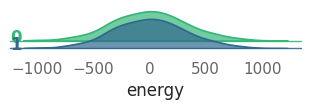

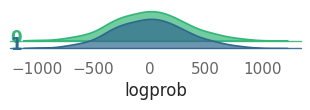

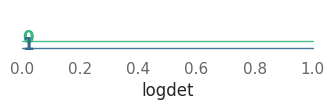

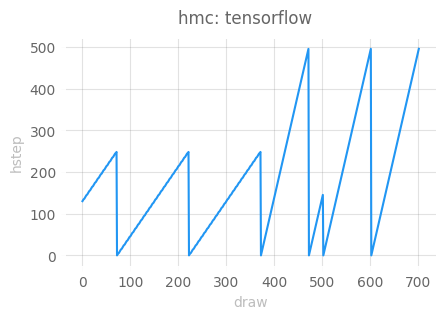

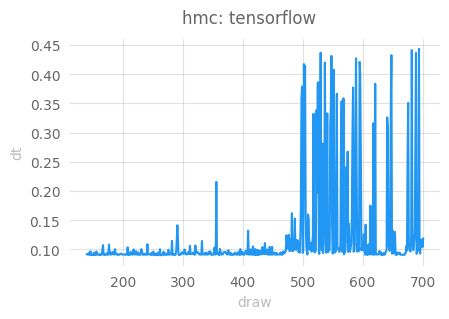

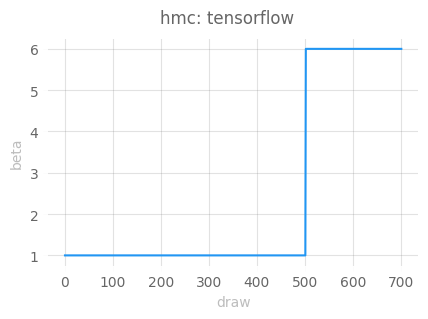

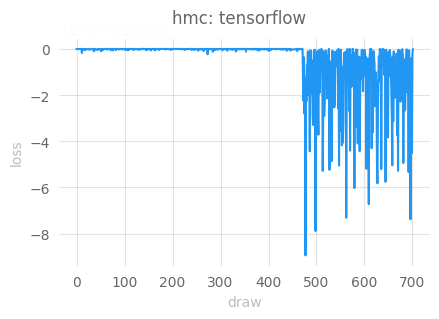

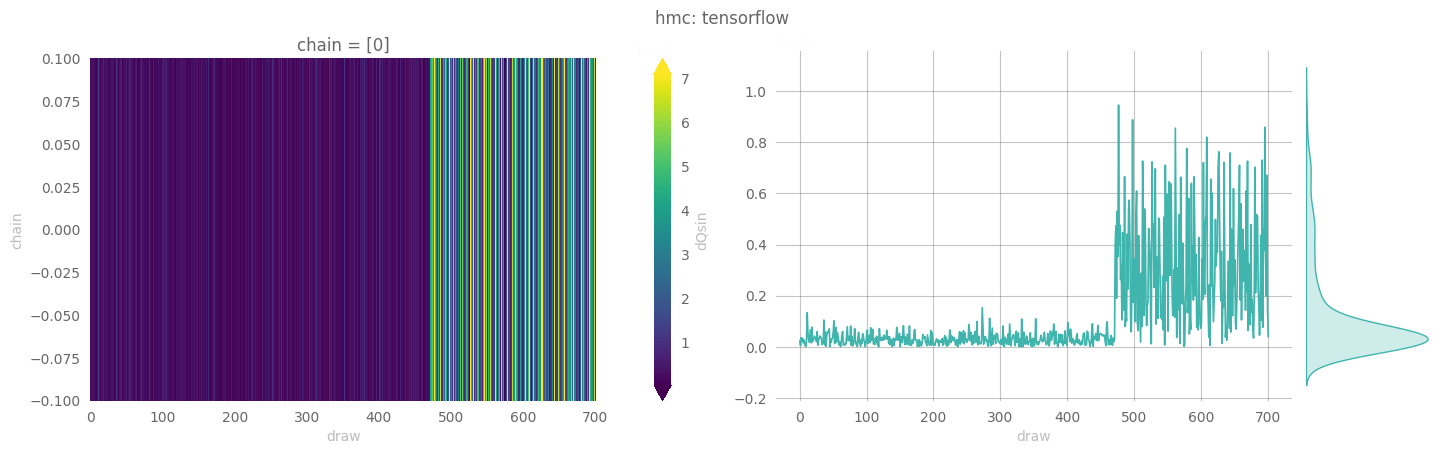

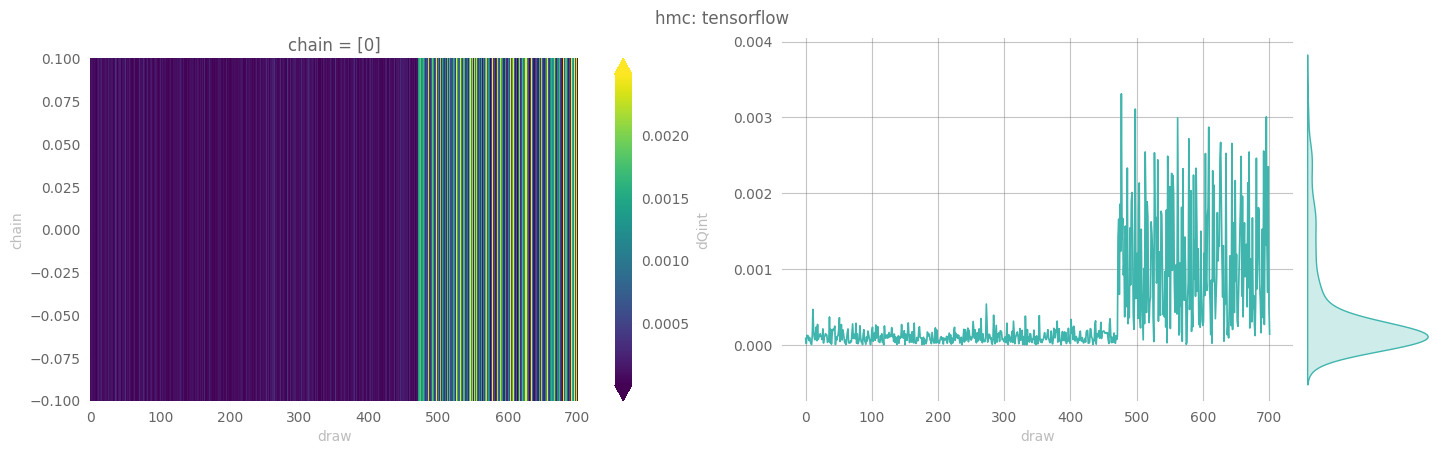

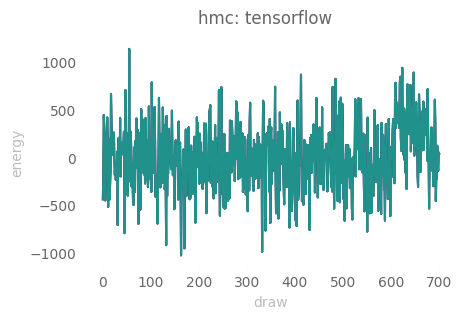

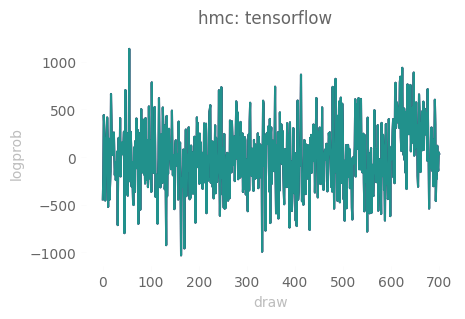

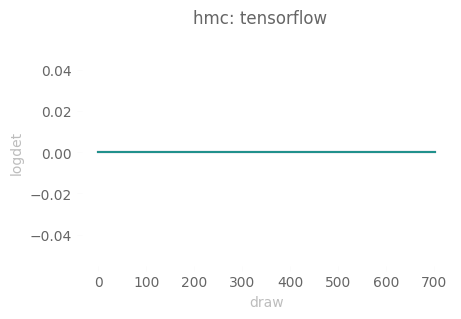

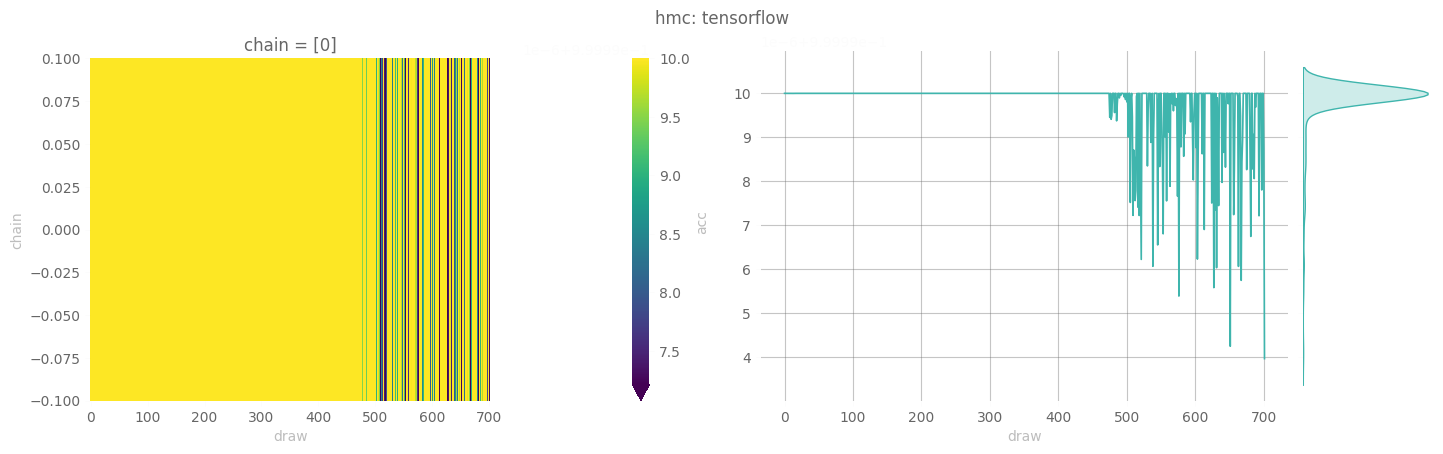

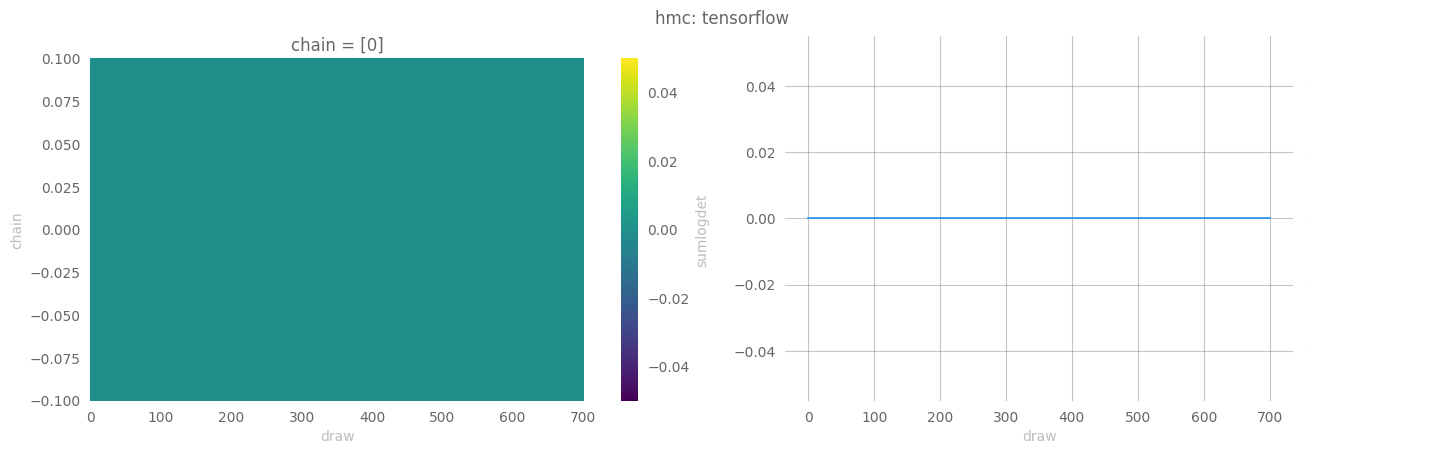

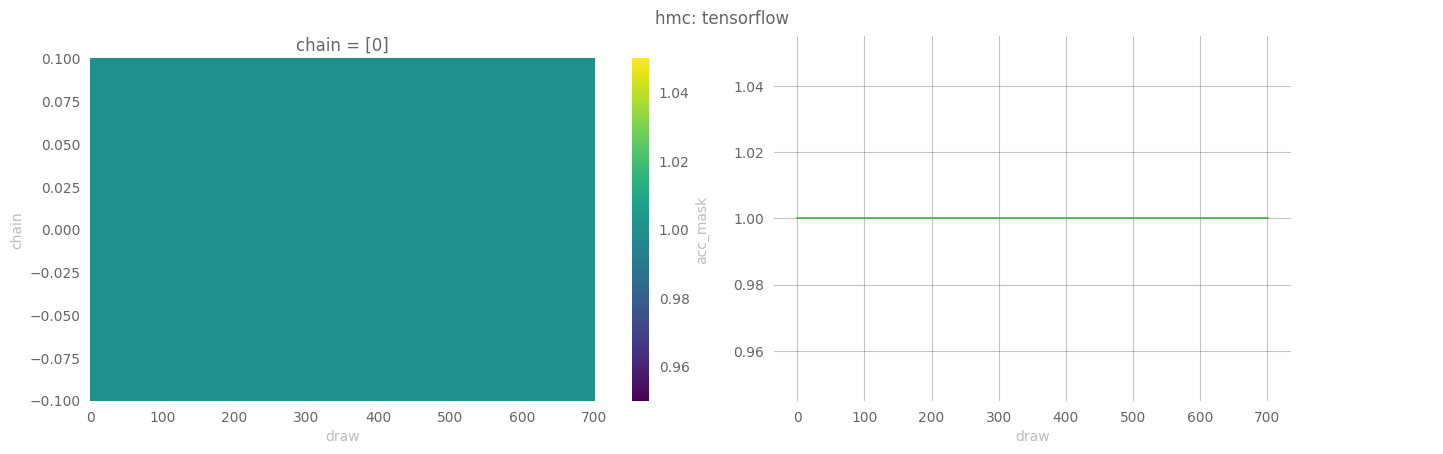

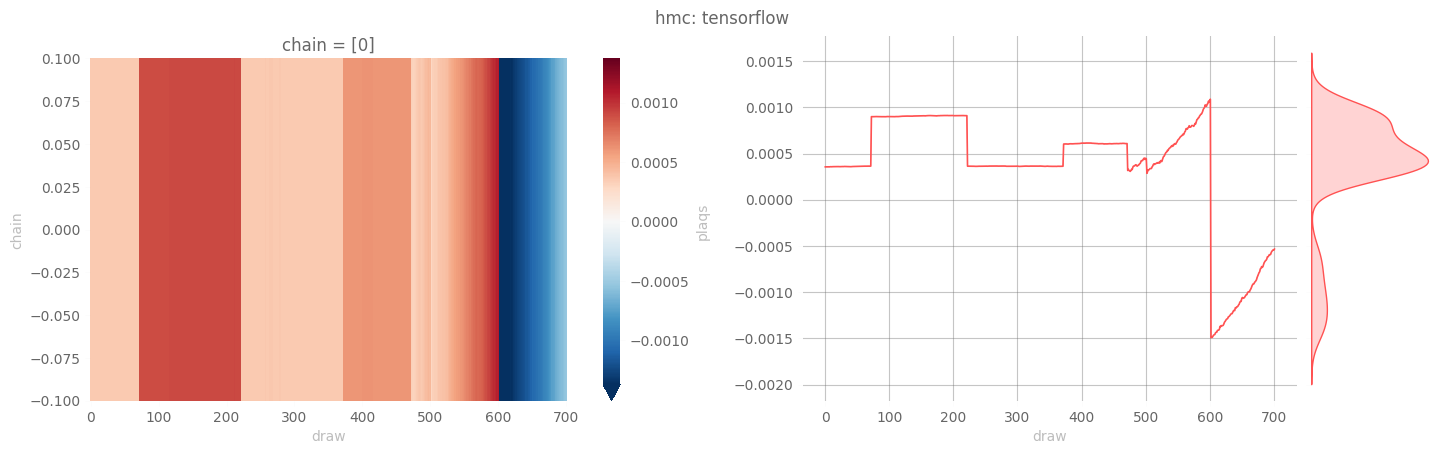

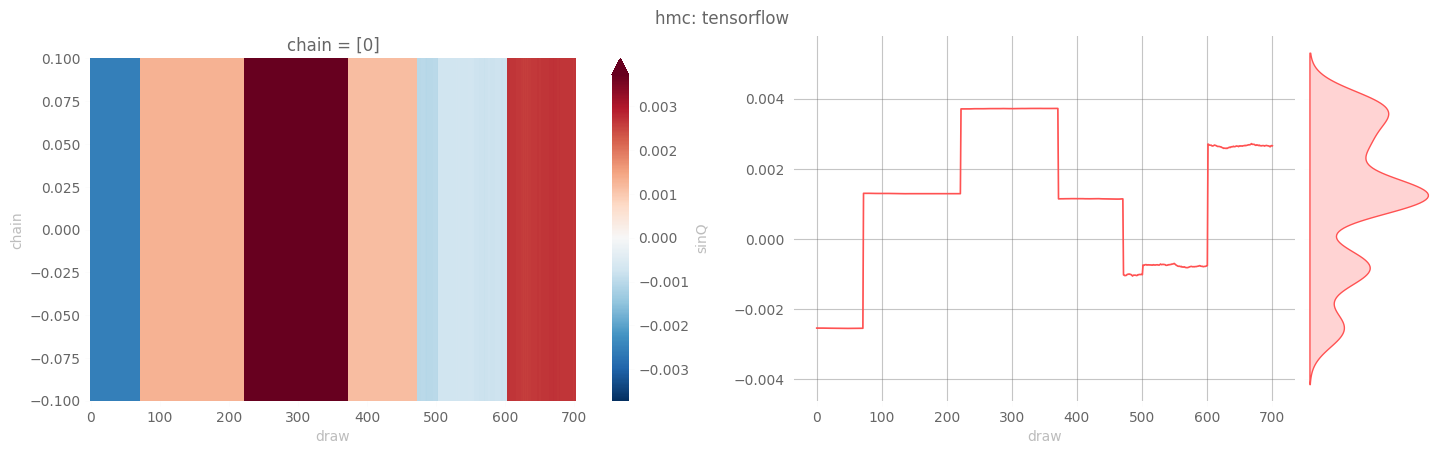

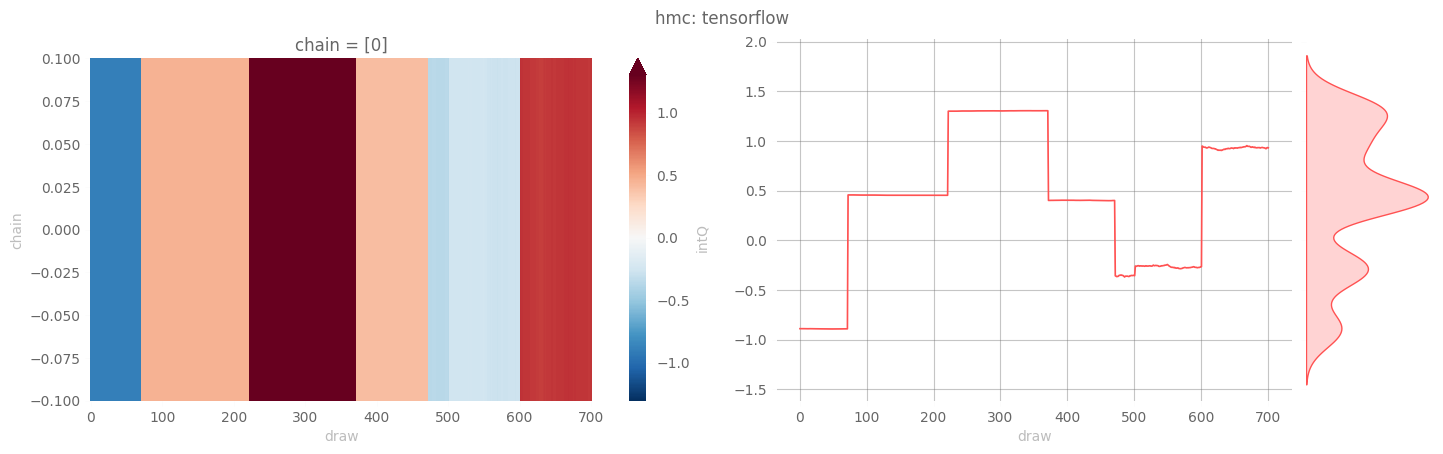

In [49]:
outputs_tf = tfExpSU3.evaluate(job_type='hmc', eps=0.001, nleapfrog=32, eval_steps=500, nchains=4, beta=6.0)

[11/01/22 12:56:44] WARNING  x.shape (original): torch.Size([1, 4, 8, 8, 8, 12, 3, 3])

                    WARNING  x[:nchains].shape: torch.Size([1, 4, 8, 8, 8, 12, 3, 3])

                    INFO     eps=0.001                                                       
                             beta=6.0                                                        
                             nlog=5                                                          
                             table=<rich.table.Table object at 0x7f579012e670>               
                             nprint=10                                                       
                             eval_steps=500                                                  
                             nleapfrog=32

  2%|▏         | 10/500 [00:06<06:12,  1.31it/s]

[11/01/22 12:56:51] INFO     hstep=10  dt=0.6325 beta=6.0000 loss=99.9547 dQsin=0.0002       
                             dQint=0.0658 energy=-3605.9290 logprob=-3605.9290 logdet=0.0000 
                             acc=1.0000 sumlogdet=0.0000 acc_mask=1.0000 plaqs=0.0178        
                             sinQ=0.0012 intQ=0.4152

  4%|▍         | 20/500 [00:14<06:42,  1.19it/s]

[11/01/22 12:56:59] INFO     hstep=20  dt=0.4956 beta=6.0000 loss=99.9644 dQsin=0.0002       
                             dQint=0.0561 energy=-7723.5423 logprob=-7723.5423 logdet=0.0000 
                             acc=1.0000 sumlogdet=0.0000 acc_mask=1.0000 plaqs=0.0357        
                             sinQ=0.0006 intQ=0.2162

  6%|▌         | 30/500 [00:22<05:37,  1.39it/s]

[11/01/22 12:57:07] INFO     hstep=30  dt=1.0565 beta=6.0000 loss=99.8994 dQsin=0.0003       
                             dQint=0.1054 energy=-12517.9808 logprob=-12517.9808             
                             logdet=0.0000 acc=1.0000 sumlogdet=0.0000 acc_mask=1.0000       
                             plaqs=0.0529 sinQ=0.0009 intQ=0.3182

  8%|▊         | 40/500 [00:30<06:21,  1.21it/s]

[11/01/22 12:57:15] INFO     hstep=40  dt=0.5080 beta=6.0000 loss=99.9606 dQsin=0.0002       
                             dQint=0.0600 energy=-15685.4350 logprob=-15685.4350             
                             logdet=0.0000 acc=1.0000 sumlogdet=0.0000 acc_mask=1.0000       
                             plaqs=0.0693 sinQ=0.0007 intQ=0.2478

 10%|█         | 50/500 [00:37<05:30,  1.36it/s]

[11/01/22 12:57:23] INFO     hstep=50  dt=0.9376 beta=6.0000 loss=99.9892 dQsin=0.0000       
                             dQint=0.0097 energy=-18823.8796 logprob=-18823.8796             
                             logdet=0.0000 acc=1.0000 sumlogdet=0.0000 acc_mask=1.0000       
                             plaqs=0.0851 sinQ=0.0012 intQ=0.4182

 12%|█▏        | 60/500 [00:45<04:30,  1.63it/s]

[11/01/22 12:57:30] INFO     hstep=60  dt=0.6508 beta=6.0000 loss=99.9878 dQsin=0.0000       
                             dQint=0.0165 energy=-21721.7821 logprob=-21721.7821             
                             logdet=0.0000 acc=1.0000 sumlogdet=0.0000 acc_mask=1.0000       
                             plaqs=0.0997 sinQ=0.0011 intQ=0.3923

 14%|█▍        | 70/500 [00:53<06:03,  1.18it/s]

[11/01/22 12:57:38] INFO     hstep=70  dt=0.4950 beta=6.0000 loss=99.9832 dQsin=0.0001       
                             dQint=0.0288 energy=-25538.3332 logprob=-25538.3332             
                             logdet=0.0000 acc=1.0000 sumlogdet=0.0000 acc_mask=1.0000       
                             plaqs=0.1135 sinQ=0.0013 intQ=0.4695

 16%|█▌        | 80/500 [01:01<05:51,  1.20it/s]

[11/01/22 12:57:46] INFO     hstep=80  dt=0.5129 beta=6.0000 loss=99.9785 dQsin=0.0001       
                             dQint=0.0376 energy=-28389.8683 logprob=-28389.8683             
                             logdet=0.0000 acc=1.0000 sumlogdet=0.0000 acc_mask=1.0000       
                             plaqs=0.1272 sinQ=0.0011 intQ=0.3949

 18%|█▊        | 90/500 [01:09<06:06,  1.12it/s]

[11/01/22 12:57:54] INFO     hstep=90  dt=0.5363 beta=6.0000 loss=99.9689 dQsin=0.0001       
                             dQint=0.0509 energy=-31318.6583 logprob=-31318.6583             
                             logdet=0.0000 acc=1.0000 sumlogdet=0.0000 acc_mask=1.0000       
                             plaqs=0.1402 sinQ=0.0011 intQ=0.3793

 20%|██        | 100/500 [01:16<05:07,  1.30it/s]

[11/01/22 12:58:02] INFO     hstep=100 dt=0.8715 beta=6.0000 loss=99.9735 dQsin=0.0001       
                             dQint=0.0449 energy=-33825.8360 logprob=-33825.8360             
                             logdet=0.0000 acc=1.0000 sumlogdet=0.0000 acc_mask=1.0000       
                             plaqs=0.1531 sinQ=0.0012 intQ=0.4118

 22%|██▏       | 110/500 [01:24<04:48,  1.35it/s]

[11/01/22 12:58:10] INFO     hstep=110 dt=1.0125 beta=6.0000 loss=99.9894 dQsin=0.0000       
                             dQint=0.0087 energy=-36186.7431 logprob=-36186.7431             
                             logdet=0.0000 acc=1.0000 sumlogdet=0.0000 acc_mask=1.0000       
                             plaqs=0.1645 sinQ=0.0009 intQ=0.3168

 24%|██▍       | 120/500 [01:32<04:43,  1.34it/s]

[11/01/22 12:58:18] INFO     hstep=120 dt=1.0885 beta=6.0000 loss=99.9836 dQsin=0.0001       
                             dQint=0.0279 energy=-38982.7192 logprob=-38982.7192             
                             logdet=0.0000 acc=1.0000 sumlogdet=0.0000 acc_mask=1.0000       
                             plaqs=0.1753 sinQ=0.0007 intQ=0.2566

 26%|██▌       | 130/500 [01:40<04:39,  1.32it/s]

[11/01/22 12:58:25] INFO     hstep=130 dt=0.4368 beta=6.0000 loss=99.9885 dQsin=0.0000       
                             dQint=0.0134 energy=-41499.6519 logprob=-41499.6519             
                             logdet=0.0000 acc=1.0000 sumlogdet=0.0000 acc_mask=1.0000       
                             plaqs=0.1866 sinQ=0.0002 intQ=0.0690

 28%|██▊       | 140/500 [01:45<02:40,  2.25it/s]

[11/01/22 12:58:30] INFO     hstep=140 dt=0.4334 beta=6.0000 loss=99.9105 dQsin=0.0003       
                             dQint=0.0987 energy=-43574.2614 logprob=-43574.2614             
                             logdet=0.0000 acc=1.0000 sumlogdet=0.0000 acc_mask=1.0000       
                             plaqs=0.1968 sinQ=0.0007 intQ=0.2363

 30%|███       | 150/500 [01:49<02:32,  2.29it/s]

[11/01/22 12:58:34] INFO     hstep=150 dt=0.4308 beta=6.0000 loss=99.9882 dQsin=0.0000       
                             dQint=0.0146 energy=-45396.4899 logprob=-45396.4899             
                             logdet=0.0000 acc=1.0000 sumlogdet=0.0000 acc_mask=1.0000       
                             plaqs=0.2062 sinQ=0.0005 intQ=0.1603

 32%|███▏      | 160/500 [01:53<02:28,  2.29it/s]

[11/01/22 12:58:38] INFO     hstep=160 dt=0.4300 beta=6.0000 loss=99.9834 dQsin=0.0001       
                             dQint=0.0285 energy=-47232.2308 logprob=-47232.2308             
                             logdet=0.0000 acc=1.0000 sumlogdet=0.0000 acc_mask=1.0000       
                             plaqs=0.2155 sinQ=0.0002 intQ=0.0708

 34%|███▍      | 170/500 [01:59<03:29,  1.58it/s]

[11/01/22 12:58:44] INFO     hstep=170 dt=0.6938 beta=6.0000 loss=99.9884 dQsin=0.0000       
                             dQint=0.0141 energy=-48895.6023 logprob=-48895.6023             
                             logdet=0.0000 acc=1.0000 sumlogdet=0.0000 acc_mask=1.0000       
                             plaqs=0.2236 sinQ=0.0002 intQ=0.0554

 36%|███▌      | 180/500 [02:05<03:15,  1.64it/s]

[11/01/22 12:58:50] INFO     hstep=180 dt=1.1703 beta=6.0000 loss=99.9789 dQsin=0.0001       
                             dQint=0.0368 energy=-51213.1066 logprob=-51213.1066             
                             logdet=0.0000 acc=1.0000 sumlogdet=0.0000 acc_mask=1.0000       
                             plaqs=0.2316 sinQ=0.0002 intQ=0.0652

 38%|███▊      | 190/500 [02:15<04:42,  1.10it/s]

[11/01/22 12:59:01] INFO     hstep=190 dt=0.8794 beta=6.0000 loss=99.9896 dQsin=0.0000       
                             dQint=0.0072 energy=-53487.2185 logprob=-53487.2185             
                             logdet=0.0000 acc=1.0000 sumlogdet=0.0000 acc_mask=1.0000       
                             plaqs=0.2403 sinQ=0.0002 intQ=0.0614

 40%|████      | 200/500 [02:23<04:12,  1.19it/s]

[11/01/22 12:59:08] INFO     hstep=200 dt=1.2323 beta=6.0000 loss=99.9849 dQsin=0.0001       
                             dQint=0.0249 energy=-55033.9992 logprob=-55033.9992             
                             logdet=0.0000 acc=1.0000 sumlogdet=0.0000 acc_mask=1.0000       
                             plaqs=0.2480 sinQ=0.0007 intQ=0.2415

 42%|████▏     | 210/500 [02:31<03:32,  1.36it/s]

[11/01/22 12:59:17] INFO     hstep=210 dt=1.0425 beta=6.0000 loss=99.9785 dQsin=0.0001       
                             dQint=0.0376 energy=-56136.5615 logprob=-56136.5615             
                             logdet=0.0000 acc=1.0000 sumlogdet=0.0000 acc_mask=1.0000       
                             plaqs=0.2551 sinQ=0.0005 intQ=0.1857

 44%|████▍     | 220/500 [02:39<03:25,  1.36it/s]

[11/01/22 12:59:24] INFO     hstep=220 dt=0.5395 beta=6.0000 loss=99.9864 dQsin=0.0001       
                             dQint=0.0209 energy=-57678.1469 logprob=-57678.1469             
                             logdet=0.0000 acc=1.0000 sumlogdet=0.0000 acc_mask=1.0000       
                             plaqs=0.2624 sinQ=0.0010 intQ=0.3343

 46%|████▌     | 230/500 [02:47<03:39,  1.23it/s]

[11/01/22 12:59:32] INFO     hstep=230 dt=0.5984 beta=6.0000 loss=99.9878 dQsin=0.0000       
                             dQint=0.0165 energy=-59167.1974 logprob=-59167.1974             
                             logdet=0.0000 acc=1.0000 sumlogdet=0.0000 acc_mask=1.0000       
                             plaqs=0.2691 sinQ=0.0008 intQ=0.2644

 48%|████▊     | 240/500 [02:54<03:10,  1.37it/s]

[11/01/22 12:59:40] INFO     hstep=240 dt=0.8959 beta=6.0000 loss=99.9856 dQsin=0.0001       
                             dQint=0.0233 energy=-61077.5873 logprob=-61077.5873             
                             logdet=0.0000 acc=1.0000 sumlogdet=0.0000 acc_mask=1.0000       
                             plaqs=0.2752 sinQ=0.0006 intQ=0.2222

 50%|█████     | 250/500 [03:02<03:26,  1.21it/s]

[11/01/22 12:59:47] INFO     hstep=250 dt=0.5126 beta=6.0000 loss=99.9786 dQsin=0.0001       
                             dQint=0.0375 energy=-61273.8162 logprob=-61273.8162             
                             logdet=0.0000 acc=1.0000 sumlogdet=0.0000 acc_mask=1.0000       
                             plaqs=0.2802 sinQ=0.0006 intQ=0.2181

 52%|█████▏    | 260/500 [03:10<03:07,  1.28it/s]

[11/01/22 12:59:55] INFO     hstep=260 dt=0.7783 beta=6.0000 loss=99.9899 dQsin=0.0000       
                             dQint=0.0039 energy=-63362.7183 logprob=-63362.7183             
                             logdet=0.0000 acc=1.0000 sumlogdet=0.0000 acc_mask=1.0000       
                             plaqs=0.2858 sinQ=0.0007 intQ=0.2415

 54%|█████▍    | 270/500 [03:17<02:57,  1.30it/s]

[11/01/22 13:00:03] INFO     hstep=270 dt=0.6680 beta=6.0000 loss=99.9872 dQsin=0.0001       
                             dQint=0.0186 energy=-63707.6782 logprob=-63707.6782             
                             logdet=0.0000 acc=1.0000 sumlogdet=0.0000 acc_mask=1.0000       
                             plaqs=0.2912 sinQ=0.0006 intQ=0.2013

 56%|█████▌    | 280/500 [03:25<02:54,  1.26it/s]

[11/01/22 13:00:11] INFO     hstep=280 dt=1.0901 beta=6.0000 loss=99.9738 dQsin=0.0001       
                             dQint=0.0445 energy=-65196.4927 logprob=-65196.4927             
                             logdet=0.0000 acc=1.0000 sumlogdet=0.0000 acc_mask=1.0000       
                             plaqs=0.2963 sinQ=0.0010 intQ=0.3425

 58%|█████▊    | 290/500 [03:33<02:34,  1.36it/s]

[11/01/22 13:00:19] INFO     hstep=290 dt=1.0322 beta=6.0000 loss=99.9815 dQsin=0.0001       
                             dQint=0.0323 energy=-67229.7052 logprob=-67229.7052             
                             logdet=0.0000 acc=1.0000 sumlogdet=0.0000 acc_mask=1.0000       
                             plaqs=0.3013 sinQ=0.0009 intQ=0.3165

 60%|██████    | 300/500 [03:41<02:29,  1.33it/s]

[11/01/22 13:00:26] INFO     hstep=300 dt=0.9096 beta=6.0000 loss=99.9513 dQsin=0.0002       
                             dQint=0.0689 energy=-68206.4237 logprob=-68206.4237             
                             logdet=0.0000 acc=1.0000 sumlogdet=0.0000 acc_mask=1.0000       
                             plaqs=0.3054 sinQ=0.0010 intQ=0.3496

 62%|██████▏   | 310/500 [03:49<02:39,  1.19it/s]

[11/01/22 13:00:34] INFO     hstep=310 dt=0.4851 beta=6.0000 loss=99.9863 dQsin=0.0001       
                             dQint=0.0214 energy=-68479.9750 logprob=-68479.9750             
                             logdet=0.0000 acc=1.0000 sumlogdet=0.0000 acc_mask=1.0000       
                             plaqs=0.3098 sinQ=0.0012 intQ=0.4330

 64%|██████▍   | 320/500 [03:56<02:12,  1.36it/s]

[11/01/22 13:00:42] INFO     hstep=320 dt=1.0400 beta=6.0000 loss=99.9896 dQsin=0.0000       
                             dQint=0.0070 energy=-69408.3377 logprob=-69408.3377             
                             logdet=0.0000 acc=1.0000 sumlogdet=0.0000 acc_mask=1.0000       
                             plaqs=0.3138 sinQ=0.0016 intQ=0.5653

 66%|██████▌   | 330/500 [04:04<02:12,  1.28it/s]

[11/01/22 13:00:49] INFO     hstep=330 dt=0.5129 beta=6.0000 loss=99.9899 dQsin=0.0000       
                             dQint=0.0031 energy=-70453.2339 logprob=-70453.2339             
                             logdet=0.0000 acc=1.0000 sumlogdet=0.0000 acc_mask=1.0000       
                             plaqs=0.3175 sinQ=0.0021 intQ=0.7403

 68%|██████▊   | 340/500 [04:12<02:15,  1.18it/s]

[11/01/22 13:00:57] INFO     hstep=340 dt=0.5383 beta=6.0000 loss=99.9633 dQsin=0.0002       
                             dQint=0.0573 energy=-71718.4520 logprob=-71718.4520             
                             logdet=0.0000 acc=1.0000 sumlogdet=0.0000 acc_mask=1.0000       
                             plaqs=0.3212 sinQ=0.0019 intQ=0.6673

 70%|███████   | 350/500 [04:20<02:07,  1.17it/s]

[11/01/22 13:01:05] INFO     hstep=350 dt=0.4936 beta=6.0000 loss=99.9893 dQsin=0.0000       
                             dQint=0.0093 energy=-71907.6452 logprob=-71907.6452             
                             logdet=0.0000 acc=1.0000 sumlogdet=0.0000 acc_mask=1.0000       
                             plaqs=0.3255 sinQ=0.0016 intQ=0.5639

 72%|███████▏  | 360/500 [04:28<01:49,  1.28it/s]

[11/01/22 13:01:13] INFO     hstep=360 dt=0.7111 beta=6.0000 loss=99.9900 dQsin=0.0000       
                             dQint=0.0008 energy=-72866.0146 logprob=-72866.0146             
                             logdet=0.0000 acc=1.0000 sumlogdet=0.0000 acc_mask=1.0000       
                             plaqs=0.3288 sinQ=0.0019 intQ=0.6508

 74%|███████▍  | 370/500 [04:36<01:37,  1.34it/s]

[11/01/22 13:01:21] INFO     hstep=370 dt=1.0678 beta=6.0000 loss=99.9882 dQsin=0.0000       
                             dQint=0.0150 energy=-73890.4875 logprob=-73890.4875             
                             logdet=0.0000 acc=1.0000 sumlogdet=0.0000 acc_mask=1.0000       
                             plaqs=0.3323 sinQ=0.0014 intQ=0.4921

 76%|███████▌  | 380/500 [04:44<01:31,  1.32it/s]

[11/01/22 13:01:29] INFO     hstep=380 dt=1.0298 beta=6.0000 loss=99.9890 dQsin=0.0000       
                             dQint=0.0113 energy=-73815.7812 logprob=-73815.7812             
                             logdet=0.0000 acc=0.9999 sumlogdet=0.0000 acc_mask=1.0000       
                             plaqs=0.3356 sinQ=0.0011 intQ=0.3832

 78%|███████▊  | 390/500 [04:51<01:05,  1.68it/s]

[11/01/22 13:01:36] INFO     hstep=390 dt=0.4560 beta=6.0000 loss=99.9551 dQsin=0.0002       
                             dQint=0.0654 energy=-74481.5563 logprob=-74481.5563             
                             logdet=0.0000 acc=1.0000 sumlogdet=0.0000 acc_mask=1.0000       
                             plaqs=0.3387 sinQ=0.0005 intQ=0.1715

 80%|████████  | 400/500 [04:58<01:14,  1.35it/s]

[11/01/22 13:01:44] INFO     hstep=400 dt=1.0470 beta=6.0000 loss=99.9848 dQsin=0.0001       
                             dQint=0.0253 energy=-75693.0157 logprob=-75693.0157             
                             logdet=0.0000 acc=1.0000 sumlogdet=0.0000 acc_mask=1.0000       
                             plaqs=0.3418 sinQ=-0.0004 intQ=-0.1353

 82%|████████▏ | 410/500 [05:06<01:07,  1.33it/s]

[11/01/22 13:01:52] INFO     hstep=410 dt=0.9225 beta=6.0000 loss=99.9862 dQsin=0.0001       
                             dQint=0.0216 energy=-75793.2475 logprob=-75793.2475             
                             logdet=0.0000 acc=1.0000 sumlogdet=0.0000 acc_mask=1.0000       
                             plaqs=0.3444 sinQ=-0.0005 intQ=-0.1647

 84%|████████▍ | 420/500 [05:14<01:06,  1.20it/s]

[11/01/22 13:01:59] INFO     hstep=420 dt=0.5006 beta=6.0000 loss=99.9894 dQsin=0.0000       
                             dQint=0.0083 energy=-76851.2808 logprob=-76851.2808             
                             logdet=0.0000 acc=1.0000 sumlogdet=0.0000 acc_mask=1.0000       
                             plaqs=0.3475 sinQ=-0.0004 intQ=-0.1493

 86%|████████▌ | 430/500 [05:22<00:59,  1.18it/s]

[11/01/22 13:02:07] INFO     hstep=430 dt=0.5111 beta=6.0000 loss=99.9761 dQsin=0.0001       
                             dQint=0.0413 energy=-77172.1380 logprob=-77172.1380             
                             logdet=0.0000 acc=1.0000 sumlogdet=0.0000 acc_mask=1.0000       
                             plaqs=0.3510 sinQ=-0.0001 intQ=-0.0474

 88%|████████▊ | 440/500 [05:30<00:42,  1.41it/s]

[11/01/22 13:02:15] INFO     hstep=440 dt=1.1484 beta=6.0000 loss=99.9872 dQsin=0.0001       
                             dQint=0.0186 energy=-78321.2112 logprob=-78321.2112             
                             logdet=0.0000 acc=1.0000 sumlogdet=0.0000 acc_mask=1.0000       
                             plaqs=0.3539 sinQ=-0.0001 intQ=-0.0418

 90%|█████████ | 450/500 [05:38<00:37,  1.34it/s]

[11/01/22 13:02:23] INFO     hstep=450 dt=1.0420 beta=6.0000 loss=99.9835 dQsin=0.0001       
                             dQint=0.0281 energy=-78845.2094 logprob=-78845.2094             
                             logdet=0.0000 acc=1.0000 sumlogdet=0.0000 acc_mask=1.0000       
                             plaqs=0.3564 sinQ=0.0003 intQ=0.0987

 92%|█████████▏| 460/500 [05:46<00:30,  1.32it/s]

[11/01/22 13:02:31] INFO     hstep=460 dt=1.0380 beta=6.0000 loss=99.9861 dQsin=0.0001       
                             dQint=0.0218 energy=-79561.4826 logprob=-79561.4826             
                             logdet=0.0000 acc=1.0000 sumlogdet=0.0000 acc_mask=1.0000       
                             plaqs=0.3579 sinQ=0.0002 intQ=0.0633

 94%|█████████▍| 470/500 [05:53<00:20,  1.43it/s]

[11/01/22 13:02:38] INFO     hstep=470 dt=0.5028 beta=6.0000 loss=99.9711 dQsin=0.0001       
                             dQint=0.0482 energy=-79923.9687 logprob=-79923.9687             
                             logdet=0.0000 acc=1.0000 sumlogdet=0.0000 acc_mask=1.0000       
                             plaqs=0.3598 sinQ=0.0002 intQ=0.0586

 96%|█████████▌| 480/500 [06:01<00:16,  1.25it/s]

[11/01/22 13:02:46] INFO     hstep=480 dt=0.7263 beta=6.0000 loss=99.9779 dQsin=0.0001       
                             dQint=0.0385 energy=-80292.4976 logprob=-80292.4976             
                             logdet=0.0000 acc=1.0000 sumlogdet=0.0000 acc_mask=1.0000       
                             plaqs=0.3623 sinQ=-0.0001 intQ=-0.0359

 98%|█████████▊| 490/500 [06:08<00:07,  1.36it/s]

[11/01/22 13:02:53] INFO     hstep=490 dt=1.0056 beta=6.0000 loss=99.9897 dQsin=0.0000       
                             dQint=0.0056 energy=-80526.2457 logprob=-80526.2457             
                             logdet=0.0000 acc=1.0000 sumlogdet=0.0000 acc_mask=1.0000       
                             plaqs=0.3648 sinQ=0.0001 intQ=0.0341

100%|██████████| 500/500 [06:16<00:00,  1.33it/s]


[11/01/22 13:03:00] ERROR    Unable to plot energy! Continuing

[11/01/22 13:03:01] ERROR    Unable to plot logprob! Continuing

                    ERROR    Unable to plot logdet! Continuing

[11/01/22 13:03:10] INFO     Saving dataset to: /lus/grand/projects/DLHMC/foremans/locations/
                             thetaGPU/projects/l2hmc-qcd/src/l2hmc/notebooks/outputs/2022-11-
                             01-122615/pytorch/hmc/data/hmc_data.h5

                    WARNING  Unable to save as `.h5` file, falling back to `netCDF4`

                    INFO     Saving dataset to: /lus/grand/projects/DLHMC/foremans/locations/
                             thetaGPU/projects/l2hmc-qcd/src/l2hmc/notebooks/outputs/2022-11-
                             01-122615/pytorch/hmc/data/hmc_dataset.nc

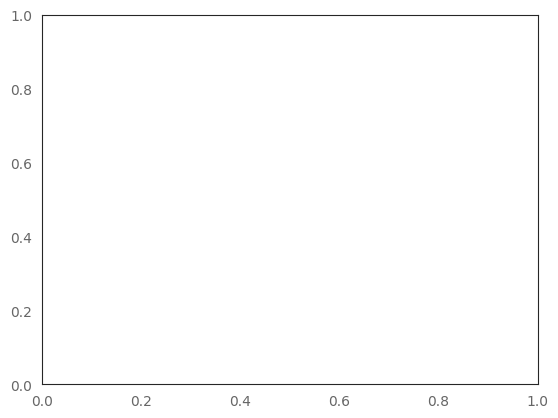

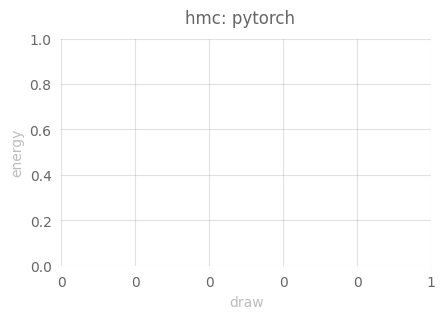

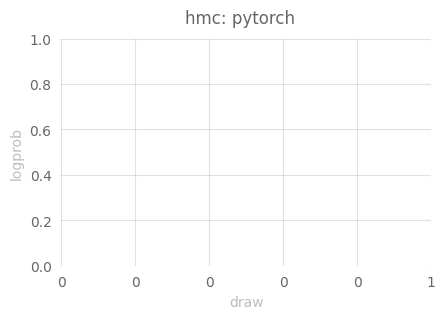

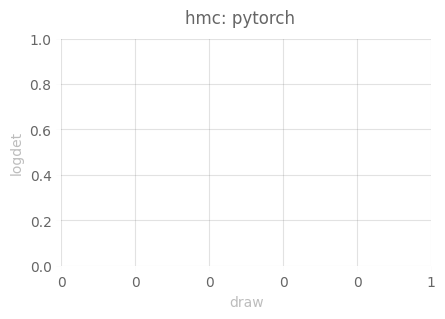

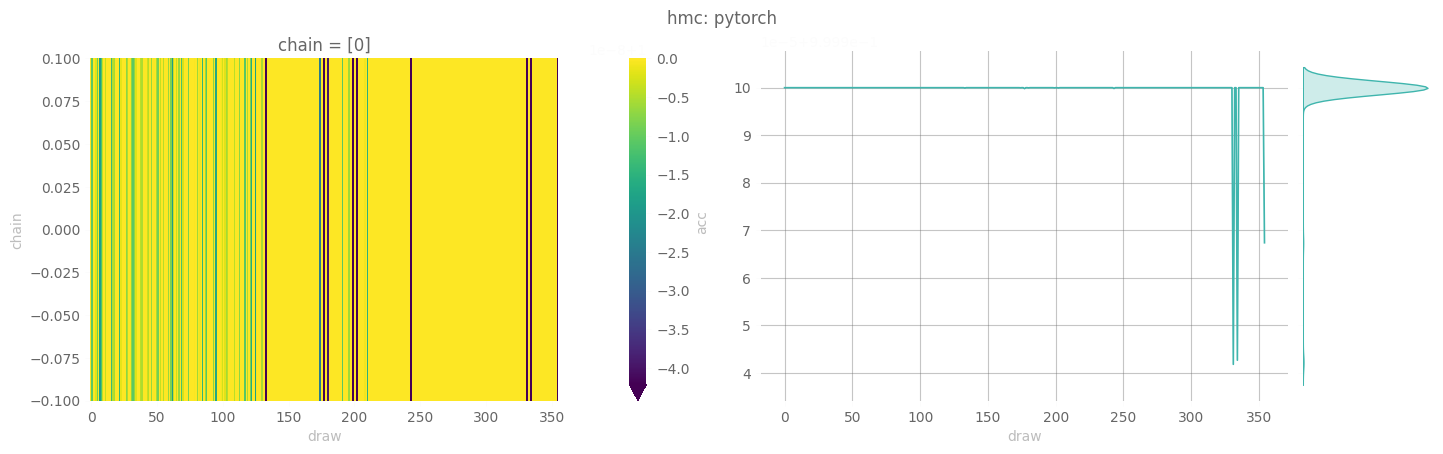

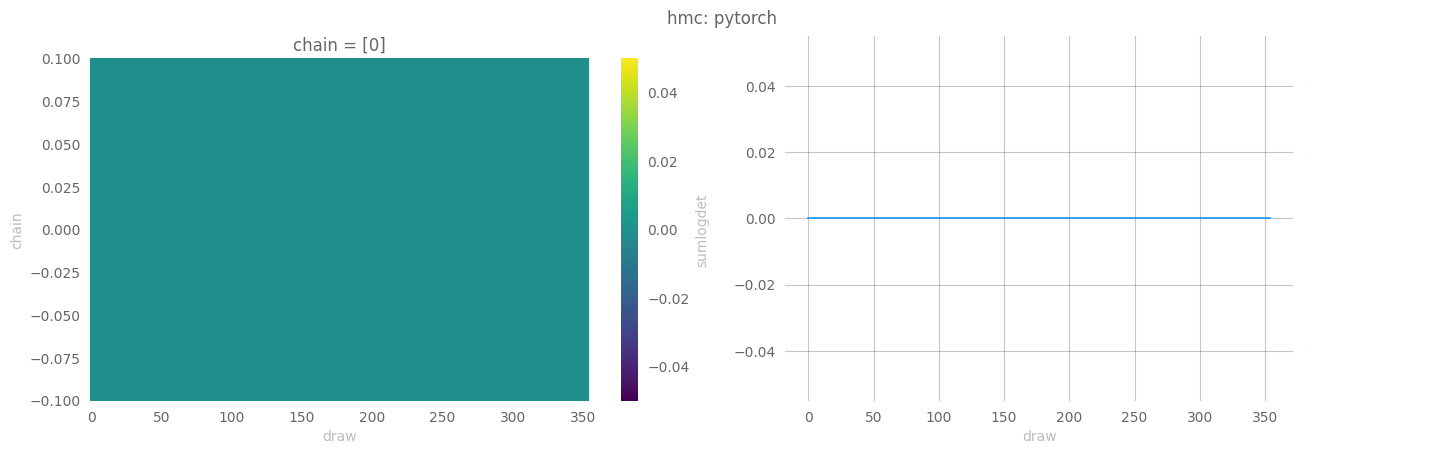

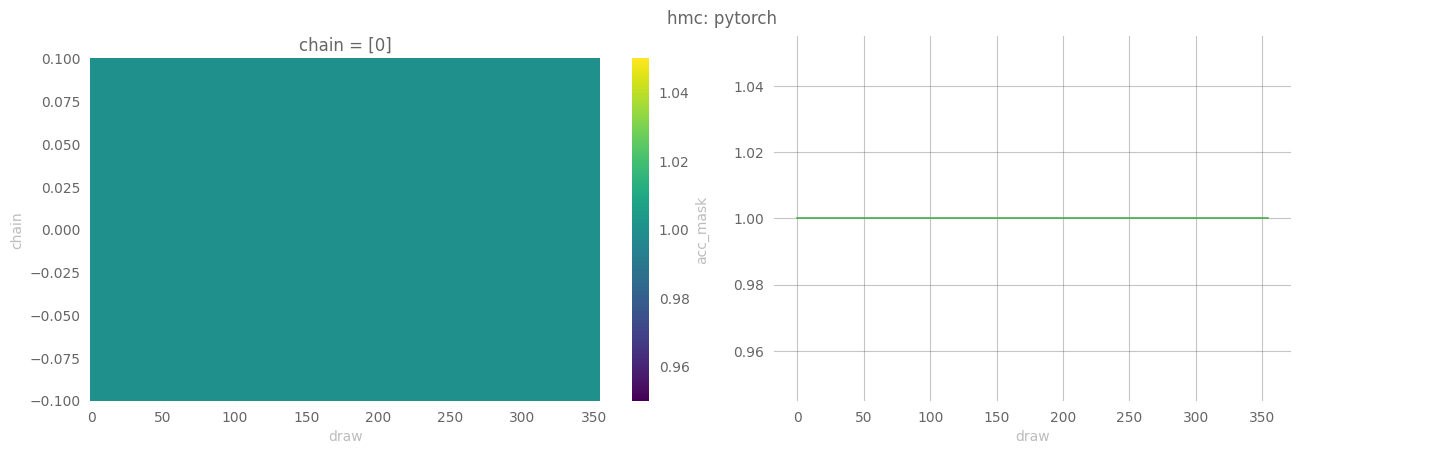

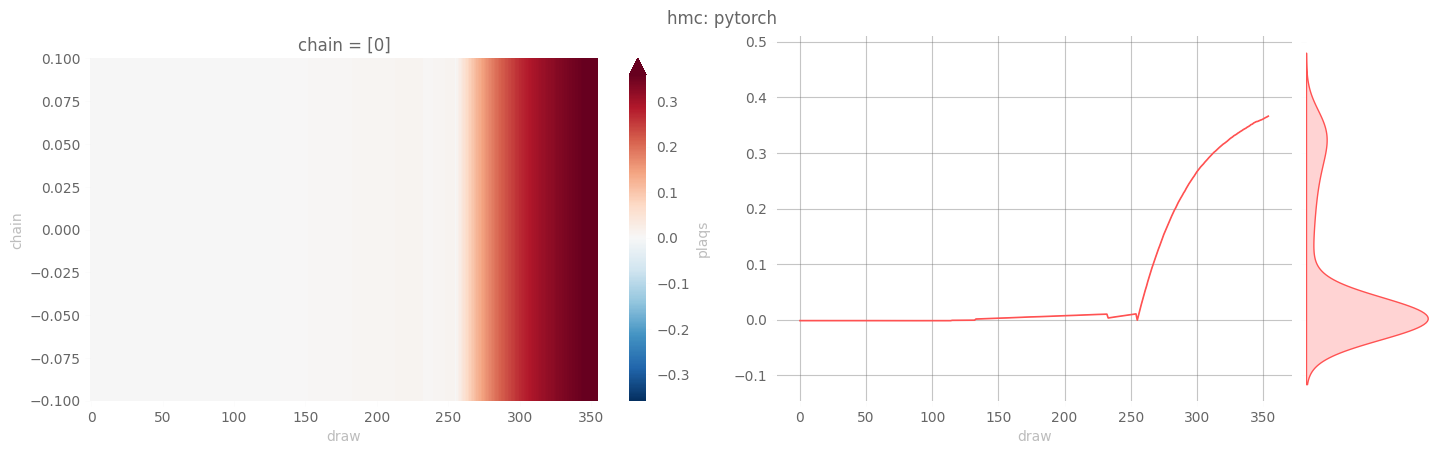

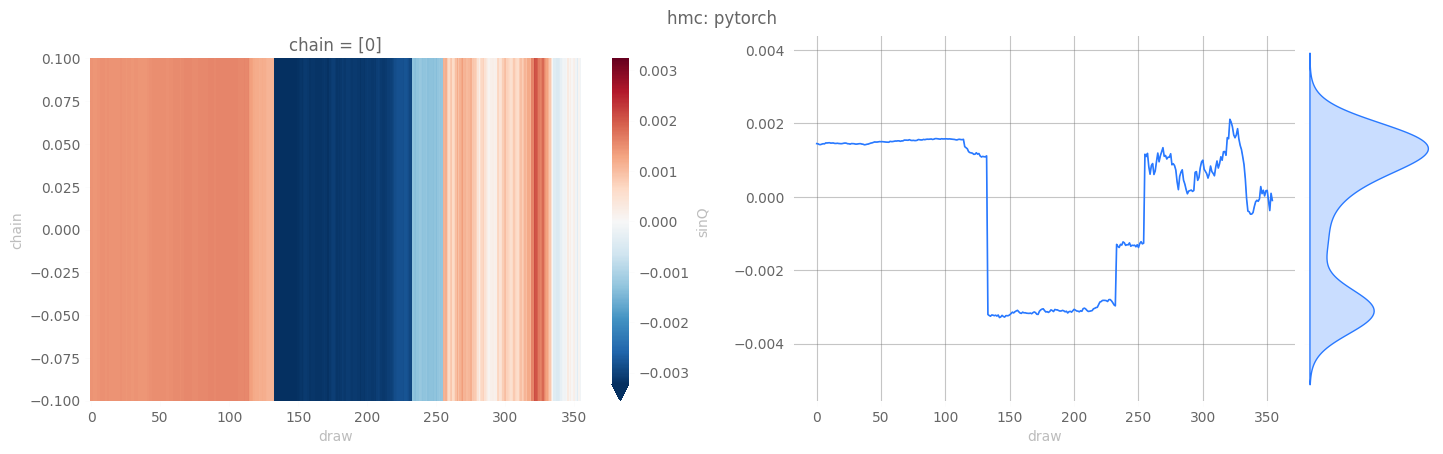

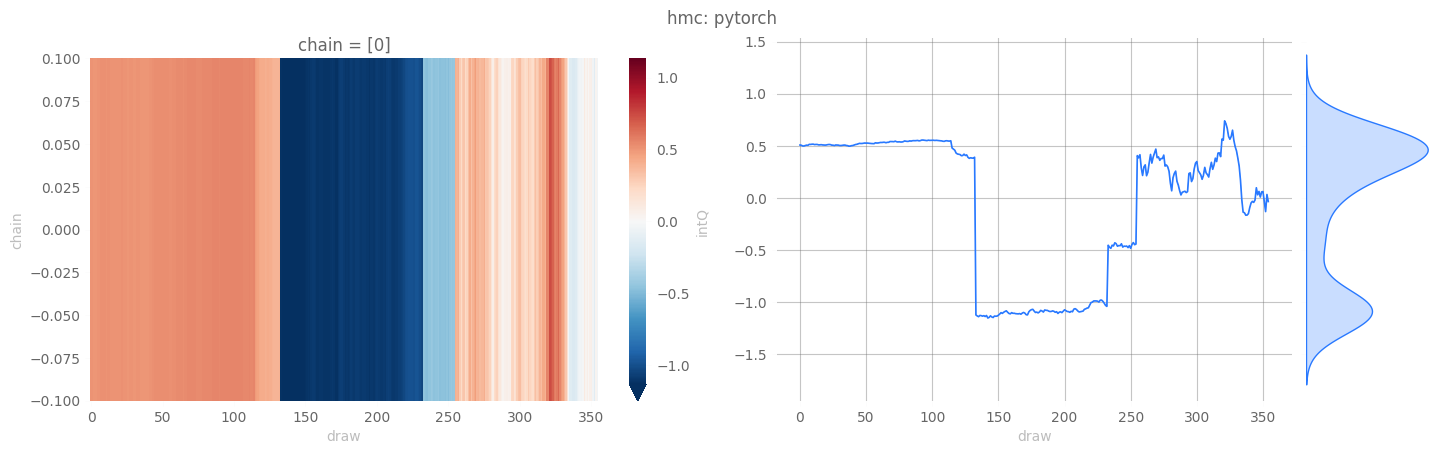

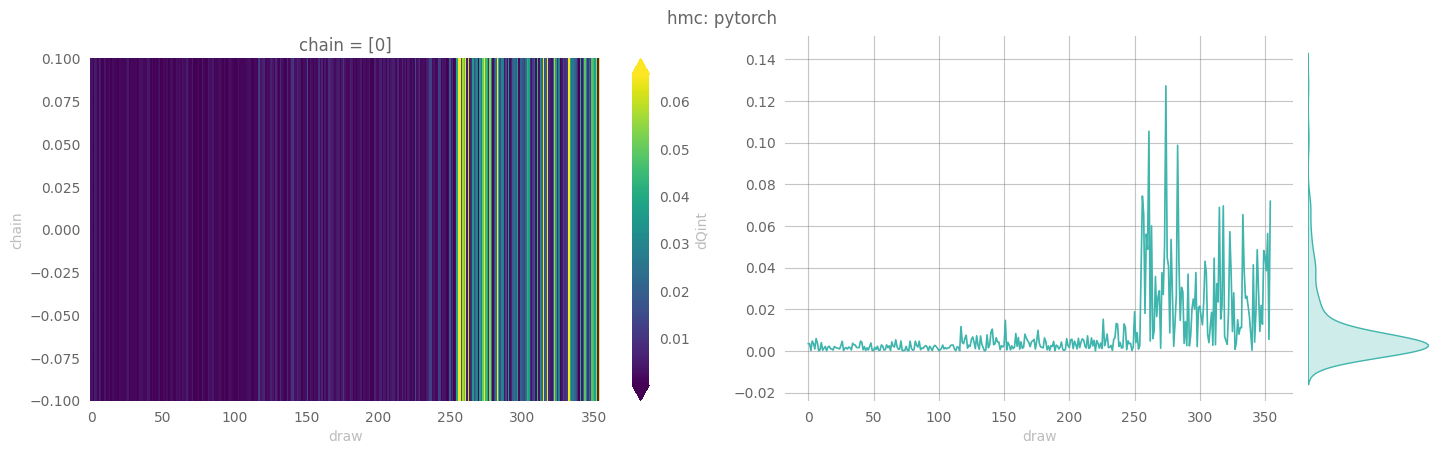

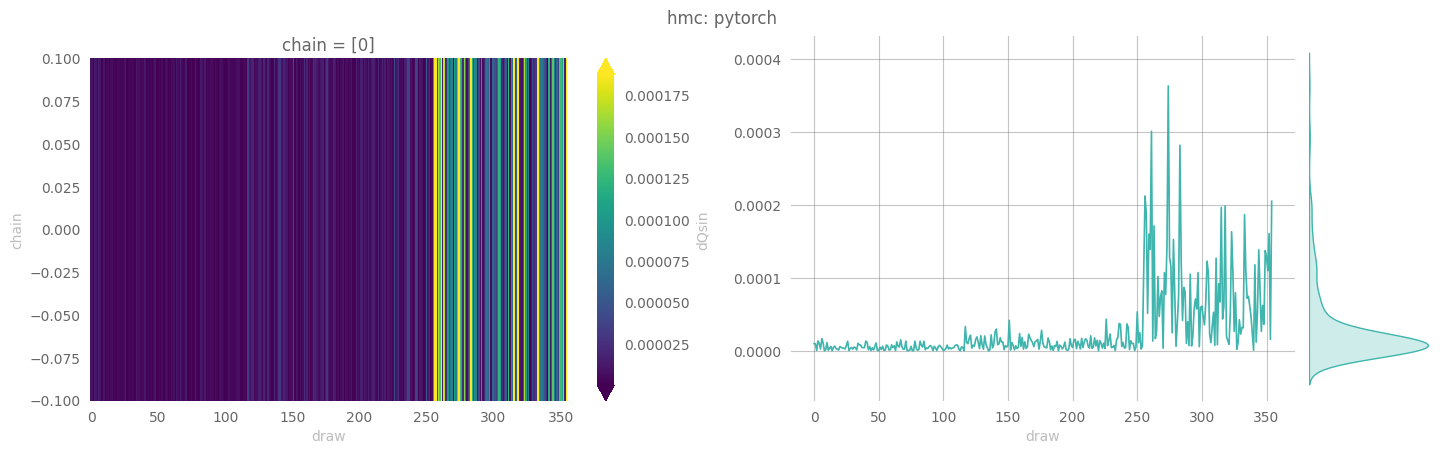

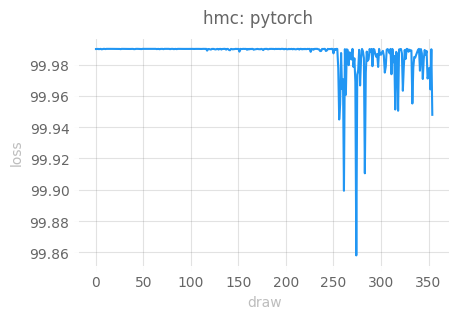

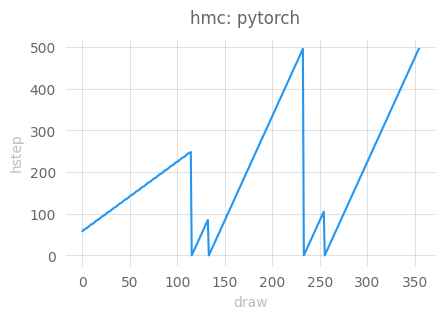

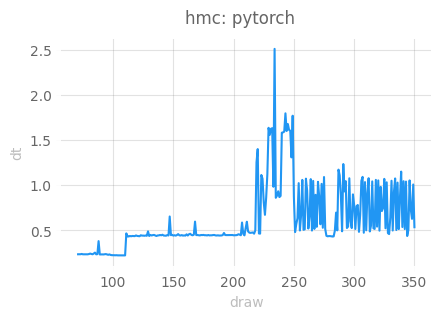

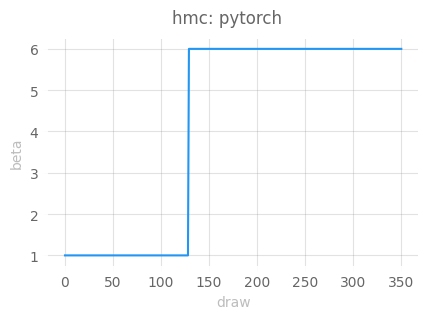

In [46]:
outputs = ptExpSU3.evaluate(job_type='hmc', eps=0.001, nleapfrog=32, eval_steps=500, nchains=4, beta=6.0)

In [ ]:
acc = torch.tensor([0.5]).cuda()
acc

In [ ]:
xpt1 = ptExpSU3.trainer.lattice.random()
xpt2 = ptExpSU3.trainer.lattice.random()
loss = ptExpSU3.trainer.loss_fn(xpt1, xpt2, acc)

In [ ]:
ptExpSU3.trainer.dynamics.xnet

In [ ]:
print(f'{ptExpSU3.trainer.dynamics.xnet.input_layer.xlayer.weight}')
print(f'{ptExpSU3.trainer.dynamics.xnet.input_layer.vlayer.weight}')

In [ ]:
print(f'xweight: {ptExpSU3.trainer.dynamics.vnet.input_layer.xlayer.weight}')
print(f'vweight: {ptExpSU3.trainer.dynamics.vnet.input_layer.vlayer.weight}')

In [ ]:
outputs_pt_hmc = ptExpSU3.evaluate(job_type='hmc', eps=0.001, nleapfrog=16)

In [ ]:
tfExpSU3.trainer.dynamics.vnet.input_layer.dtype

In [ ]:
tfExpSU3.trainer.dynamics.vnet.input_layer.dtype

In [ ]:
loss

In [ ]:
xpt_.shape

In [ ]:
metrics_pt['acc_mask']

In [ ]:
loss = ptExpSU3.trainer.loss_fn(state_pt.x, xpt_, torch.tensor(metrics_pt['acc_mask']).cuda())

In [ ]:
loss

In [ ]:
GPUtil.showUtilization()

In [ ]:
xpt = xpt.reshape(ptExpSU3.trainer.dynamics.xshape)

In [ ]:
xpt.shape

In [ ]:
gpt.checkSU(xpt)

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_context('notebook', font_scale=0.7)
plt.rcParams['figure.figsize'] = plt.rcParamsDefault['figure.figsize']

In [ ]:
with sns.plotting_context("talk", font_scale=0.6):
    ouput_pt_hmc = ptExpSU3.evaluate(job_type='hmc', eps=0.0625, nleapfrog=32)

In [ ]:
%debug

In [ ]:
xpt, metrics_pt = ptExpSU3.trainer.hmc_step(inputs, eps=0.00001, nleapfrog=16)

In [ ]:
avgs_, summary_ = ptExpSU3.trainer.record_metrics(metrics_pt, job_type='hmc')
rich.print(summary_)

In [ ]:
xpt, metrics_pt = ptExpSU3.trainer.train_step((xpt, state_pt.beta))
avgs_pt, summary_pt = ptExpSU3.trainer.record_metrics(metrics_pt, job_type='train')
rich.print(summary_pt)

In [ ]:
xpt, metrics_pt = ptExpSU3.trainer.train_step((xpt, state_pt.beta))
avgs_pt, summary_pt = ptExpSU3.trainer.record_metrics(metrics_pt, job_type='train')
rich.print(summary_pt)

In [ ]:
xpt = ptExpSU3.trainer.lattice.random()
xpt, metrics_pt = ptExpSU3.trainer.eval_step((xpt, state_pt.beta))
avgs_pt, summary_pt = ptExpSU3.trainer.record_metrics(metrics_pt, job_type='eval')
rich.print(summary_pt)

In [ ]:
pteval_out = ptExpSU3.evaluate(job_type='eval', nchains=5)

In [ ]:
avgs_pt, summary_pt = ptExpSU3.trainer.record_metrics(metrics, job_type='train')
rich.print(summary_pt)

In [ ]:
outputs_tf = tfExpSU3.trainer.train(x=tf.constant(state_pt.x.detach().cpu().numpy()))

In [ ]:
outputs_pt = ptExpSU3.trainer.train()

In [ ]:
x.shape

In [ ]:
gpt.norm2((x.reshape_as(state_pt.x) - state_pt.x)).sum()

We can compute the loss as:

\[
    \mathcal{L}_{\theta}\left(x, x'\right) = \sum_{\alpha} \gamma^{\alpha} \ell_{\alpha}\left(x, x'\right)
\]

and 

\[
    \ell_{\alpha}\left(x, x'\right) = A\left(x'|x\right)\cdot \left\|x' - x\right\|^{\alpha}
\]

In [ ]:
acc = torch.tensor(metrics_pt['acc']).to(x.device)
dx = (state_pt.x - mc_states.proposed.x)
dx2 = gpt.norm2(dx)

dx2.shape

dx2_sum = dx2.sum(tuple(range(1, len(dx2.shape))))

dx2_sum.shape

loss = - (acc * dx2_sum).mean()

loss.backward()
opt.step()

In [ ]:
outputs_pt_train = ptExpSU3.train(nera=1, nepoch=10)

In [ ]:
ptExpSU3.trainer.g.checkSU(sinit.x)

In [ ]:
loss

In [ ]:
from l2hmc.network.tensorflow.network import zero_weights
dynamics_tf = zero_weights(tfExpSU3.trainer.dynamics)

In [ ]:
tf.config.run_functions_eagerly(True)
outputs_tf_train = tfExpSU3.train(nera=1, nepoch=10)

In [ ]:
outputs_tf_train = tfExpSU3_.train(nera=1, nepoch=10)

## TensorFlow

In [ ]:
outputs_tf = tfExpSU3.evaluate(
    beta=6.0,
    eps=0.03125,
    nleapfrog=32,
    eval_steps=100,
    job_type='hmc'
)

## PyTorch:

In [ ]:
ptExpSU3.trainer.dynamics.cuda()
ptExpSU3.trainer.dynamics.eval()
outputs_pt = ptExpSU3.evaluate(
    beta=6.0,
    eps=0.03125,
    nleapfrog=32,
    eval_steps=100,
    job_type='hmc',
)

In [ ]:
import torch
import torch.nn as nn


class DeepSet(nn.Module):
    def  __init__(
            in_channels: int,
            out_channels: int,
            hidden_channels: int = 32,
    ) -> None:
        super(DeepSet, self).__init__()
        self.feature_extractor = nn.Sequential(
            nn.Linear(in_channels, hidden_channels),
            nn.Tanh(),
            nn.Linear(hidden_channels, hidden_channels)
        )
        self.regressor = nn.Sequential(
            nn.Linear(hidden_channels, hidden_channels),
            nn.Tanh(),
            nn.Linear(hidden_channels, out_channels)
        )
        
    def reset_parameters(self):
        for module in self.children():
            rest_op = getattr(module, 'reset_parameters', None)
            if callable(reset_op):
                reset_op()
                
    def forward(self, x):
        x = self.feature_extractor(x)
        x = x.sum(dim=-2)
        x = self.regressor(x)
        return x
    
    
class TimeNetwork(nn.Module):
    def __init__(self, fn):
        super(TimeNetwork, self).__init__()
        self.fn = fn
        
    def forward(self, t, x):
        if not isinstance(t, torch.Tensor):
            t = torch.tensor(t).to(x.dtype)
        t_ = t.expand(x.shape[:-1] + (1,))
        return self.fn(torch.cat((x, t_), -1))
    
    
class DeepTimeSet(nn.Module):
    def __init__(
            self,
            in_channels: int,
            out_channels: int,
            hidden_channels: int = 32
    ) -> None:
        super(DeepTimeSet, self).__init__()
        self.feature_extractor = nn.Sequential(
            nn.Linear(in_channels, hidden_channels),
            nn.Tanh(),
            nn.Linear(hidden_channels, hidden_channels)
        )
        self.regressor = TimeNetwork(
            nn.Sequential(
                nn.Linear(hidden_channels + 1, hidden_channels),
                nn.Tanh(),
                nn.Linear(hidden_channels, out_channels)
            )
        )
        
    def reset_parameters(self):
        for module in self.children():
            rest_op = getattr(module, 'reset_parameters', None)
            if callable(reset_op):
                reset_op()
        
    def forward(self, t, x):
        x = self.feature_extractor(x)
        x = x.sum(dim=-2)
        x = self.regressor(t, x)
        return x

In [ ]:
x = ptExpSU3.trainer.lattice.random()
x.shape

In [ ]:
dset_pt = ptExpSU3.trainer.histories['hmc'].get_dataset()
dset_tf = tfExpSU3.trainer.histories['hmc'].get_dataset()

In [ ]:
dset_pt

In [ ]:
dset_tf

In [ ]:
dset_tf.keys()

In [ ]:
dset_pt.keys()

In [ ]:
hist_pt = ptExpSU3.trainer.histories['hmc']
hist_tf = tfExpSU3.trainer.histories['hmc']

In [ ]:
sorted(hist_pt.history.keys())

In [ ]:
sorted(hist_tf.history.keys())

In [ ]:
print(len(sorted(hist_tf.history.keys())))
print(len(sorted(hist_pt.history.keys())))

In [ ]:
from l2hmc.common import grab_tensor

beta = 6.0
x0pt = ptExpSU3.trainer.lattice.random()
x0tf = tf.constant(grab_tensor(x0pt))

x1pt, metrics_pt = ptExpSU3.trainer.hmc_step((x0pt, beta), eps=0.03125, nleapfrog=16)
x1tf, metrics_tf = tfExpSU3.trainer.hmc_step((x0tf, tf.constant(beta)), eps=0.03125, nleapfrog=16)

In [ ]:
metrics_pt.keys()
print(len(metrics_pt.keys()))

In [ ]:
metrics_tf.keys()
print(len(metrics_tf.keys()))

In [ ]:
record_pt = {}
record_pt.update(ptExpSU3.trainer.metrics_to_numpy(metrics_pt))

In [ ]:
record_tf = {}
record_tf.update(tfExpSU3.trainer.metrics_to_numpy(metrics_tf))

In [ ]:
record_pt.keys()
print(len(record_pt.keys()))

In [ ]:
record_tf.keys()

In [ ]:
for key, val in record_pt.items():
    print(f'{key}: {val.shape}')
   

In [ ]:
for key, val in hist_tf.history.items():
    print(f'{key}: {np.array(val).shape}')

In [ ]:
from l2hmc.common import clear_cuda_cache
clear_cuda_cache()
outputs_pt_train = ptExpSU3.train(nera=1, nepoch=10)

In [ ]:
outputs_tf_train = tfExpSU3.train(nera=1, nepoch=10)

## New heading